In [4]:
import matplotlib.pyplot as plt 
import numpy as np 
import pathlib
import os
import PIL
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Reshape, Flatten, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [12]:
dataset_dir = pathlib.Path('/Users/admin/Downloads/DSGP/Data Set copy')
img_height, img_width = 180,180
batch_size = 16
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     dataset_dir,
#     validation_split=0.1,
#     subset="training",
#     seed=123,
#     label_mode="categorical",
#     image_size=(img_height, img_width),
#     batch_size=batch_size)
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_ds = data_generator.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=123,
    shuffle=True
)
X, y = train_ds.next()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_flatten = X_train.reshape(X_train.shape[0], -1)

smote = SMOTE(sampling_strategy='auto',random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_flatten, np.argmax(y_train, axis=1))


X_resampled = X_resampled.reshape(-1, img_height, img_width, 3)

y_resampled_onehot = tf.keras.utils.to_categorical(y_resampled, num_classes=3)

balanced_train_ds = tf.data.Dataset.from_tensor_slices((X_resampled, y_resampled_onehot))
balanced_train_ds = balanced_train_ds.shuffle(buffer_size=len(X_resampled)).batch(batch_size)

vali_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
vali_ds = vali_ds.batch(batch_size)

Found 10261 images belonging to 3 classes.


ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 4, n_samples = 4

In [3]:
vali_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 10261 files belonging to 3 classes.
Using 1026 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['Over Ripe', 'Ripe', 'Unripe']


In [5]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,          
    restore_best_weights=True,  
)

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

In [26]:
efficientnet_model = Sequential()

pretrained_m =tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(180,180,3),
    pooling=None,
    classes=3,
    classifier_activation="softmax",
)
for layer in pretrained_m.layers:
    layer.trainable = False

efficientnet_model.add(data_augmentation)   
efficientnet_model.add(pretrained_m)
efficientnet_model.add(BatchNormalization())
efficientnet_model.add(GlobalAveragePooling2D())
efficientnet_model.add(Flatten())
efficientnet_model.add(Dense(128, activation='relu'))
efficientnet_model.add(Dropout(0.3))
efficientnet_model.add(Dense(3, activation='softmax'))

In [27]:
efficientnet_model.build((None, img_height, img_width, 3))
efficientnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 efficientnetb7 (Functional  (None, 6, 6, 2560)        64097687  
 )                                                               
                                                                 
 batch_normalization_4 (Bat  (None, 6, 6, 2560)        10240     
 chNormalization)                                                
                                                                 
 module_wrapper_20 (ModuleW  (None, 2560)              0         
 rapper)                                                         
                                                                 
 module_wrapper_21 (ModuleW  (None, 2560)              0         
 rapper)                                              

In [28]:
efficientnet_model.compile(optimizer=LegacyAdam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [29]:
history = efficientnet_model.fit(
    train_ds,  
    epochs=3,   
    validation_data=vali_ds,  
    callbacks=[early_stopping],    
)

Epoch 1/100


2024-01-29 15:26:07.677036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/578 [..............................] - ETA: 2:05:40 - loss: 1.3118 - accuracy: 0.3125

2024-01-29 15:26:14.181982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/578 [..............................] - ETA: 5:49 - loss: 1.0693 - accuracy: 0.5312   

2024-01-29 15:26:14.789122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/578 [..............................] - ETA: 4:11 - loss: 0.9228 - accuracy: 0.5833

2024-01-29 15:26:15.055223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/578 [..............................] - ETA: 3:33 - loss: 0.8595 - accuracy: 0.6250

2024-01-29 15:26:15.295695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/578 [..............................] - ETA: 3:12 - loss: 0.8978 - accuracy: 0.6250

2024-01-29 15:26:15.522548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/578 [..............................] - ETA: 3:35 - loss: 0.9251 - accuracy: 0.6354

2024-01-29 15:26:16.061624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/578 [..............................] - ETA: 4:24 - loss: 0.9384 - accuracy: 0.6339

2024-01-29 15:26:16.954391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/578 [..............................] - ETA: 3:47 - loss: 0.9152 - accuracy: 0.6528

2024-01-29 15:26:17.168507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:17.370020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/578 [..............................] - ETA: 4:55 - loss: 0.8853 - accuracy: 0.6625

2024-01-29 15:26:18.853854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/578 [..............................] - ETA: 4:38 - loss: 0.8581 - accuracy: 0.6705

2024-01-29 15:26:19.082388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/578 [..............................] - ETA: 4:23 - loss: 0.8414 - accuracy: 0.6823

2024-01-29 15:26:19.290866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/578 [..............................] - ETA: 4:26 - loss: 0.9813 - accuracy: 0.6683

2024-01-29 15:26:19.837460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/578 [..............................] - ETA: 4:15 - loss: 0.9823 - accuracy: 0.6696

2024-01-29 15:26:20.056515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/578 [..............................] - ETA: 4:04 - loss: 0.9446 - accuracy: 0.6833

2024-01-29 15:26:20.267139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/578 [..............................] - ETA: 3:56 - loss: 0.9277 - accuracy: 0.6875

2024-01-29 15:26:20.495121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/578 [..............................] - ETA: 3:52 - loss: 0.8820 - accuracy: 0.7022

2024-01-29 15:26:20.821540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/578 [..............................] - ETA: 3:39 - loss: 0.8516 - accuracy: 0.7138

2024-01-29 15:26:21.035250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/578 [>.............................] - ETA: 3:33 - loss: 0.8479 - accuracy: 0.7156

2024-01-29 15:26:21.236674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/578 [>.............................] - ETA: 3:28 - loss: 0.8461 - accuracy: 0.7143

2024-01-29 15:26:21.442544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:21.646945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/578 [>.............................] - ETA: 3:20 - loss: 0.8166 - accuracy: 0.7283

2024-01-29 15:26:21.933148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:22.136918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/578 [>.............................] - ETA: 3:12 - loss: 0.8006 - accuracy: 0.7300

2024-01-29 15:26:22.344258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/578 [>.............................] - ETA: 3:09 - loss: 0.7928 - accuracy: 0.7332

2024-01-29 15:26:22.546740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/578 [>.............................] - ETA: 3:05 - loss: 0.7984 - accuracy: 0.7361

2024-01-29 15:26:22.749659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/578 [>.............................] - ETA: 3:02 - loss: 0.7767 - accuracy: 0.7433

2024-01-29 15:26:22.953322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:23.156536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/578 [>.............................] - ETA: 2:57 - loss: 0.7735 - accuracy: 0.7500

2024-01-29 15:26:23.363194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/578 [>.............................] - ETA: 2:54 - loss: 0.7581 - accuracy: 0.7540

2024-01-29 15:26:23.568096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:23.773679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/578 [>.............................] - ETA: 3:03 - loss: 0.7524 - accuracy: 0.7595

2024-01-29 15:26:24.722997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:24.927846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/578 [>.............................] - ETA: 2:59 - loss: 0.7719 - accuracy: 0.7625

2024-01-29 15:26:25.227151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/578 [>.............................] - ETA: 2:57 - loss: 0.7638 - accuracy: 0.7639

2024-01-29 15:26:25.431367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:25.630402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/578 [>.............................] - ETA: 2:52 - loss: 0.7389 - accuracy: 0.7681

2024-01-29 15:26:25.828572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:26.026043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/578 [=>............................] - ETA: 2:48 - loss: 0.7312 - accuracy: 0.7656

2024-01-29 15:26:26.222657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:26.425820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/578 [=>............................] - ETA: 2:45 - loss: 0.7160 - accuracy: 0.7708

2024-01-29 15:26:26.632250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/578 [=>............................] - ETA: 2:43 - loss: 0.7009 - accuracy: 0.7762

2024-01-29 15:26:26.834491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:27.032078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/578 [=>............................] - ETA: 2:40 - loss: 0.6916 - accuracy: 0.7792

2024-01-29 15:26:27.231102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:27.427545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/578 [=>............................] - ETA: 2:37 - loss: 0.6651 - accuracy: 0.7886

2024-01-29 15:26:27.625523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:27.826197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/578 [=>............................] - ETA: 2:34 - loss: 0.6460 - accuracy: 0.7946

2024-01-29 15:26:28.025244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:28.222017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/578 [=>............................] - ETA: 2:32 - loss: 0.6286 - accuracy: 0.7990

2024-01-29 15:26:28.421346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:28.617764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/578 [=>............................] - ETA: 2:29 - loss: 0.6237 - accuracy: 0.8007

2024-01-29 15:26:28.815789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:29.012127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/578 [=>............................] - ETA: 2:27 - loss: 0.6172 - accuracy: 0.8000

2024-01-29 15:26:29.208219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:29.404064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/578 [=>............................] - ETA: 2:25 - loss: 0.6116 - accuracy: 0.8004

2024-01-29 15:26:29.603663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/578 [==>...........................] - ETA: 2:24 - loss: 0.6145 - accuracy: 0.7985

2024-01-29 15:26:29.804336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:30.004997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/578 [==>...........................] - ETA: 2:22 - loss: 0.6091 - accuracy: 0.8010

2024-01-29 15:26:30.206578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:30.403992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/578 [==>...........................] - ETA: 2:20 - loss: 0.5976 - accuracy: 0.8044

2024-01-29 15:26:30.601635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:30.797530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/578 [==>...........................] - ETA: 2:18 - loss: 0.5836 - accuracy: 0.8076

2024-01-29 15:26:30.995119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:31.192683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/578 [==>...........................] - ETA: 2:17 - loss: 0.5688 - accuracy: 0.8116

2024-01-29 15:26:31.391960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:31.588088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/578 [==>...........................] - ETA: 2:15 - loss: 0.5589 - accuracy: 0.8125

2024-01-29 15:26:31.785908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:31.983341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/578 [==>...........................] - ETA: 2:13 - loss: 0.5526 - accuracy: 0.8134

2024-01-29 15:26:32.179638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:32.375719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/578 [==>...........................] - ETA: 2:12 - loss: 0.5456 - accuracy: 0.8151

2024-01-29 15:26:32.572325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:32.770873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/578 [==>...........................] - ETA: 2:11 - loss: 0.5435 - accuracy: 0.8150

2024-01-29 15:26:32.975029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:33.174059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/578 [==>...........................] - ETA: 2:09 - loss: 0.5342 - accuracy: 0.8174

2024-01-29 15:26:33.372071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:33.572308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/578 [===>..........................] - ETA: 2:08 - loss: 0.5227 - accuracy: 0.8213

2024-01-29 15:26:33.773592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:33.971701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/578 [===>..........................] - ETA: 2:07 - loss: 0.5188 - accuracy: 0.8234

2024-01-29 15:26:34.170320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:34.368757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/578 [===>..........................] - ETA: 2:06 - loss: 0.5099 - accuracy: 0.8262

2024-01-29 15:26:34.567195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:34.765985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/578 [===>..........................] - ETA: 2:04 - loss: 0.5115 - accuracy: 0.8259

2024-01-29 15:26:34.963915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:35.161644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/578 [===>..........................] - ETA: 2:03 - loss: 0.5094 - accuracy: 0.8270

2024-01-29 15:26:35.359849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:35.557759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/578 [===>..........................] - ETA: 2:02 - loss: 0.5015 - accuracy: 0.8295

2024-01-29 15:26:35.755338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:35.955765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/578 [===>..........................] - ETA: 2:02 - loss: 0.5018 - accuracy: 0.8287

2024-01-29 15:26:36.165526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/578 [===>..........................] - ETA: 2:01 - loss: 0.4997 - accuracy: 0.8299

2024-01-29 15:26:36.417155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/578 [===>..........................] - ETA: 2:01 - loss: 0.4962 - accuracy: 0.8310

2024-01-29 15:26:36.628484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/578 [===>..........................] - ETA: 2:01 - loss: 0.4916 - accuracy: 0.8329

2024-01-29 15:26:36.838830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/578 [===>..........................] - ETA: 2:00 - loss: 0.4897 - accuracy: 0.8338

2024-01-29 15:26:37.047183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/578 [===>..........................] - ETA: 1:59 - loss: 0.4871 - accuracy: 0.8349

2024-01-29 15:26:37.252556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:37.450039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/578 [===>..........................] - ETA: 1:59 - loss: 0.4838 - accuracy: 0.8359

2024-01-29 15:26:37.651205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/578 [====>.........................] - ETA: 1:58 - loss: 0.4773 - accuracy: 0.8374

2024-01-29 15:26:37.859991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:38.060403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/578 [====>.........................] - ETA: 1:57 - loss: 0.4738 - accuracy: 0.8375

2024-01-29 15:26:38.266010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/578 [====>.........................] - ETA: 1:56 - loss: 0.4722 - accuracy: 0.8379

2024-01-29 15:26:38.467447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:38.664134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/578 [====>.........................] - ETA: 1:55 - loss: 0.4668 - accuracy: 0.8398

2024-01-29 15:26:38.863346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:39.064248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/578 [====>.........................] - ETA: 1:55 - loss: 0.4638 - accuracy: 0.8405

2024-01-29 15:26:39.263112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:39.462539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/578 [====>.........................] - ETA: 1:54 - loss: 0.4595 - accuracy: 0.8417

2024-01-29 15:26:39.662710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/578 [====>.........................] - ETA: 1:53 - loss: 0.4592 - accuracy: 0.8420

2024-01-29 15:26:39.863973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:40.060860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/578 [====>.........................] - ETA: 1:52 - loss: 0.4572 - accuracy: 0.8432

2024-01-29 15:26:40.259671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:40.456010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/578 [====>.........................] - ETA: 1:51 - loss: 0.4568 - accuracy: 0.8438

2024-01-29 15:26:40.654044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:40.851160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/578 [====>.........................] - ETA: 1:51 - loss: 0.4523 - accuracy: 0.8459

2024-01-29 15:26:41.048461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:41.248161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/578 [=====>........................] - ETA: 1:50 - loss: 0.4565 - accuracy: 0.8464

2024-01-29 15:26:41.445171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:41.643542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/578 [=====>........................] - ETA: 1:49 - loss: 0.4612 - accuracy: 0.8459

2024-01-29 15:26:41.841663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/578 [=====>........................] - ETA: 1:49 - loss: 0.4592 - accuracy: 0.8466

2024-01-29 15:26:42.042890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:42.238806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/578 [=====>........................] - ETA: 1:48 - loss: 0.4557 - accuracy: 0.8476

2024-01-29 15:26:42.437037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:42.634133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/578 [=====>........................] - ETA: 1:47 - loss: 0.4565 - accuracy: 0.8476

2024-01-29 15:26:42.831039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:43.028111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/578 [=====>........................] - ETA: 1:46 - loss: 0.4571 - accuracy: 0.8480

2024-01-29 15:26:43.228646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:43.427250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/578 [=====>........................] - ETA: 1:46 - loss: 0.4514 - accuracy: 0.8494

2024-01-29 15:26:43.627712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/578 [=====>........................] - ETA: 1:45 - loss: 0.4487 - accuracy: 0.8506

2024-01-29 15:26:43.828245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/578 [=====>........................] - ETA: 1:45 - loss: 0.4483 - accuracy: 0.8508

2024-01-29 15:26:44.031334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:44.231691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/578 [=====>........................] - ETA: 1:44 - loss: 0.4487 - accuracy: 0.8521

2024-01-29 15:26:44.429243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:44.627304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/578 [=====>........................] - ETA: 1:43 - loss: 0.4467 - accuracy: 0.8524

2024-01-29 15:26:44.826141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:45.024553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/578 [======>.......................] - ETA: 1:43 - loss: 0.4470 - accuracy: 0.8523

2024-01-29 15:26:45.222172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:45.421841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/578 [======>.......................] - ETA: 1:42 - loss: 0.4474 - accuracy: 0.8531

2024-01-29 15:26:45.619502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/578 [======>.......................] - ETA: 1:42 - loss: 0.4449 - accuracy: 0.8537

2024-01-29 15:26:45.823114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:46.023313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/578 [======>.......................] - ETA: 1:41 - loss: 0.4426 - accuracy: 0.8540

2024-01-29 15:26:46.224464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:46.422958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/578 [======>.......................] - ETA: 1:40 - loss: 0.4463 - accuracy: 0.8543

2024-01-29 15:26:46.622691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/578 [======>.......................] - ETA: 1:40 - loss: 0.4482 - accuracy: 0.8536

2024-01-29 15:26:46.825901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/578 [======>.......................] - ETA: 1:40 - loss: 0.4463 - accuracy: 0.8542

2024-01-29 15:26:47.031683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:47.236274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/578 [======>.......................] - ETA: 1:39 - loss: 0.4427 - accuracy: 0.8549

2024-01-29 15:26:47.446932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:47.645766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/578 [======>.......................] - ETA: 1:39 - loss: 0.4449 - accuracy: 0.8539

2024-01-29 15:26:47.848091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/578 [======>.......................] - ETA: 1:38 - loss: 0.4427 - accuracy: 0.8544

2024-01-29 15:26:48.051352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/578 [======>.......................] - ETA: 1:38 - loss: 0.4400 - accuracy: 0.8554

2024-01-29 15:26:48.257743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:48.454242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/578 [======>.......................] - ETA: 1:37 - loss: 0.4402 - accuracy: 0.8553

2024-01-29 15:26:48.653895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:48.854772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/578 [======>.......................] - ETA: 1:37 - loss: 0.4404 - accuracy: 0.8551

2024-01-29 15:26:49.052786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:49.251216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/578 [=======>......................] - ETA: 1:36 - loss: 0.4397 - accuracy: 0.8550

2024-01-29 15:26:49.455663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:49.654785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/578 [=======>......................] - ETA: 1:35 - loss: 0.4418 - accuracy: 0.8540

2024-01-29 15:26:49.859003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/578 [=======>......................] - ETA: 1:35 - loss: 0.4419 - accuracy: 0.8538

2024-01-29 15:26:50.063335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:50.264623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/578 [=======>......................] - ETA: 1:35 - loss: 0.4385 - accuracy: 0.8548

2024-01-29 15:26:50.463874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:50.664091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/578 [=======>......................] - ETA: 1:34 - loss: 0.4357 - accuracy: 0.8558

2024-01-29 15:26:50.864132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:51.064607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/578 [=======>......................] - ETA: 1:33 - loss: 0.4375 - accuracy: 0.8561

2024-01-29 15:26:51.268728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:51.466243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/578 [=======>......................] - ETA: 1:33 - loss: 0.4370 - accuracy: 0.8567

2024-01-29 15:26:51.664644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:51.863458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/578 [=======>......................] - ETA: 1:32 - loss: 0.4352 - accuracy: 0.8569

2024-01-29 15:26:52.061263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:52.260008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/578 [=======>......................] - ETA: 1:32 - loss: 0.4333 - accuracy: 0.8571

2024-01-29 15:26:52.455958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:52.654868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/578 [=======>......................] - ETA: 1:31 - loss: 0.4322 - accuracy: 0.8569

2024-01-29 15:26:52.855562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:53.053046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/578 [========>.....................] - ETA: 1:30 - loss: 0.4290 - accuracy: 0.8579

2024-01-29 15:26:53.253980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:53.453395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/578 [========>.....................] - ETA: 1:30 - loss: 0.4263 - accuracy: 0.8588

2024-01-29 15:26:53.650102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:53.847776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/578 [========>.....................] - ETA: 1:29 - loss: 0.4224 - accuracy: 0.8600

2024-01-29 15:26:54.045242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:54.244206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/578 [========>.....................] - ETA: 1:29 - loss: 0.4231 - accuracy: 0.8598

2024-01-29 15:26:54.445990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:54.643193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/578 [========>.....................] - ETA: 1:28 - loss: 0.4194 - accuracy: 0.8610

2024-01-29 15:26:54.840895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:55.038332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/578 [========>.....................] - ETA: 1:28 - loss: 0.4173 - accuracy: 0.8611

2024-01-29 15:26:55.237344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:55.434401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/578 [========>.....................] - ETA: 1:27 - loss: 0.4143 - accuracy: 0.8623

2024-01-29 15:26:55.630467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:55.826693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/578 [========>.....................] - ETA: 1:27 - loss: 0.4127 - accuracy: 0.8628

2024-01-29 15:26:56.025506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:56.223717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/578 [========>.....................] - ETA: 1:26 - loss: 0.4110 - accuracy: 0.8632

2024-01-29 15:26:56.420522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:56.616728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/578 [=========>....................] - ETA: 1:25 - loss: 0.4103 - accuracy: 0.8633

2024-01-29 15:26:56.813069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:57.010654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/578 [=========>....................] - ETA: 1:25 - loss: 0.4082 - accuracy: 0.8641

2024-01-29 15:26:57.206296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:57.405075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/578 [=========>....................] - ETA: 1:24 - loss: 0.4082 - accuracy: 0.8636

2024-01-29 15:26:57.606040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:57.803028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/578 [=========>....................] - ETA: 1:24 - loss: 0.4070 - accuracy: 0.8637

2024-01-29 15:26:58.001462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:58.199573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/578 [=========>....................] - ETA: 1:23 - loss: 0.4039 - accuracy: 0.8650

2024-01-29 15:26:58.398000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:58.594370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/578 [=========>....................] - ETA: 1:23 - loss: 0.4015 - accuracy: 0.8658

2024-01-29 15:26:58.791842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/578 [=========>....................] - ETA: 1:22 - loss: 0.3997 - accuracy: 0.8664

2024-01-29 15:26:58.992455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:59.191323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/578 [=========>....................] - ETA: 1:22 - loss: 0.4040 - accuracy: 0.8659

2024-01-29 15:26:59.389362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:59.587253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/578 [=========>....................] - ETA: 1:21 - loss: 0.4040 - accuracy: 0.8660

2024-01-29 15:26:59.786839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:26:59.982927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/578 [=========>....................] - ETA: 1:21 - loss: 0.4016 - accuracy: 0.8664

2024-01-29 15:27:00.180406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:00.377913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/578 [==========>...................] - ETA: 1:20 - loss: 0.3988 - accuracy: 0.8670

2024-01-29 15:27:00.574087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:00.771656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/578 [==========>...................] - ETA: 1:20 - loss: 0.3972 - accuracy: 0.8677

2024-01-29 15:27:00.974851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:01.171143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/578 [==========>...................] - ETA: 1:19 - loss: 0.3954 - accuracy: 0.8683

2024-01-29 15:27:01.367744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:01.565827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/578 [==========>...................] - ETA: 1:19 - loss: 0.3968 - accuracy: 0.8684

2024-01-29 15:27:01.764048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:01.963438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/578 [==========>...................] - ETA: 1:18 - loss: 0.3944 - accuracy: 0.8693

2024-01-29 15:27:02.166828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:02.363815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/578 [==========>...................] - ETA: 1:18 - loss: 0.3923 - accuracy: 0.8699

2024-01-29 15:27:02.563104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:02.761216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/578 [==========>...................] - ETA: 1:17 - loss: 0.3917 - accuracy: 0.8703

2024-01-29 15:27:02.957508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:03.154676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/578 [==========>...................] - ETA: 1:17 - loss: 0.3946 - accuracy: 0.8692

2024-01-29 15:27:03.351921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:03.548457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/578 [==========>...................] - ETA: 1:16 - loss: 0.3932 - accuracy: 0.8695

2024-01-29 15:27:03.744351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:03.943225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/578 [==========>...................] - ETA: 1:16 - loss: 0.3925 - accuracy: 0.8696

2024-01-29 15:27:04.141750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:04.337535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/578 [===========>..................] - ETA: 1:15 - loss: 0.3932 - accuracy: 0.8685

2024-01-29 15:27:04.533082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:04.731928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/578 [===========>..................] - ETA: 1:15 - loss: 0.3924 - accuracy: 0.8686

2024-01-29 15:27:04.929018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:05.126894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/578 [===========>..................] - ETA: 1:14 - loss: 0.3929 - accuracy: 0.8681

2024-01-29 15:27:05.324425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:05.520469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/578 [===========>..................] - ETA: 1:14 - loss: 0.3918 - accuracy: 0.8684

2024-01-29 15:27:05.717462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:05.914978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/578 [===========>..................] - ETA: 1:13 - loss: 0.3905 - accuracy: 0.8687

2024-01-29 15:27:06.111923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:06.308769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/578 [===========>..................] - ETA: 1:13 - loss: 0.3924 - accuracy: 0.8683

2024-01-29 15:27:06.506274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:06.701987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/578 [===========>..................] - ETA: 1:12 - loss: 0.3904 - accuracy: 0.8689

2024-01-29 15:27:06.899708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:07.097212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/578 [===========>..................] - ETA: 1:12 - loss: 0.3940 - accuracy: 0.8681

2024-01-29 15:27:07.293090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:07.491346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/578 [===========>..................] - ETA: 1:11 - loss: 0.3914 - accuracy: 0.8690

2024-01-29 15:27:07.688999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:07.886924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/578 [===========>..................] - ETA: 1:11 - loss: 0.3886 - accuracy: 0.8698

2024-01-29 15:27:08.082948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:08.280276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/578 [============>.................] - ETA: 1:10 - loss: 0.3879 - accuracy: 0.8700

2024-01-29 15:27:08.477543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:08.676274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/578 [============>.................] - ETA: 1:10 - loss: 0.3860 - accuracy: 0.8703

2024-01-29 15:27:08.874423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:09.072631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/578 [============>.................] - ETA: 1:09 - loss: 0.3859 - accuracy: 0.8704

2024-01-29 15:27:09.269438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:09.467289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/578 [============>.................] - ETA: 1:09 - loss: 0.3856 - accuracy: 0.8704

2024-01-29 15:27:09.665198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:09.861803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/578 [============>.................] - ETA: 1:08 - loss: 0.3832 - accuracy: 0.8712

2024-01-29 15:27:10.060858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:10.257601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/578 [============>.................] - ETA: 1:08 - loss: 0.3825 - accuracy: 0.8709

2024-01-29 15:27:10.456306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:10.655485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/578 [============>.................] - ETA: 1:07 - loss: 0.3802 - accuracy: 0.8719

2024-01-29 15:27:10.852217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:11.047994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/578 [============>.................] - ETA: 1:07 - loss: 0.3794 - accuracy: 0.8722

2024-01-29 15:27:11.246199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:11.442284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/578 [============>.................] - ETA: 1:06 - loss: 0.3783 - accuracy: 0.8727

2024-01-29 15:27:11.640602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:11.837300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/578 [=============>................] - ETA: 1:06 - loss: 0.3801 - accuracy: 0.8718

2024-01-29 15:27:12.036615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:12.234657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/578 [=============>................] - ETA: 1:06 - loss: 0.3797 - accuracy: 0.8718

2024-01-29 15:27:12.432835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:12.631454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/578 [=============>................] - ETA: 1:05 - loss: 0.3798 - accuracy: 0.8718

2024-01-29 15:27:12.827490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:13.023710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/578 [=============>................] - ETA: 1:05 - loss: 0.3810 - accuracy: 0.8718

2024-01-29 15:27:13.220402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:13.418455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/578 [=============>................] - ETA: 1:04 - loss: 0.3791 - accuracy: 0.8721

2024-01-29 15:27:13.615153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/578 [=============>................] - ETA: 1:04 - loss: 0.3781 - accuracy: 0.8723

2024-01-29 15:27:13.816802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:14.013013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/578 [=============>................] - ETA: 1:03 - loss: 0.3787 - accuracy: 0.8717

2024-01-29 15:27:14.210529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:14.409590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/578 [=============>................] - ETA: 1:03 - loss: 0.3775 - accuracy: 0.8719

2024-01-29 15:27:14.609421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:14.807240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/578 [=============>................] - ETA: 1:02 - loss: 0.3765 - accuracy: 0.8719

2024-01-29 15:27:15.003849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:15.200983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/578 [=============>................] - ETA: 1:02 - loss: 0.3747 - accuracy: 0.8726

2024-01-29 15:27:15.400388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:15.598234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/578 [==============>...............] - ETA: 1:02 - loss: 0.3728 - accuracy: 0.8733

2024-01-29 15:27:15.798928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:15.996368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/578 [==============>...............] - ETA: 1:01 - loss: 0.3736 - accuracy: 0.8737

2024-01-29 15:27:16.192935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:16.391204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/578 [==============>...............] - ETA: 1:01 - loss: 0.3721 - accuracy: 0.8739

2024-01-29 15:27:16.588101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:16.784003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/578 [==============>...............] - ETA: 1:00 - loss: 0.3731 - accuracy: 0.8737

2024-01-29 15:27:16.983016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:17.181661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/578 [==============>...............] - ETA: 1:00 - loss: 0.3714 - accuracy: 0.8744

2024-01-29 15:27:17.377190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/578 [==============>...............] - ETA: 59s - loss: 0.3707 - accuracy: 0.8746 

2024-01-29 15:27:17.577589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/578 [==============>...............] - ETA: 59s - loss: 0.3709 - accuracy: 0.8746

2024-01-29 15:27:17.780073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/578 [==============>...............] - ETA: 59s - loss: 0.3703 - accuracy: 0.8746

2024-01-29 15:27:17.981213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:18.180292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/578 [==============>...............] - ETA: 59s - loss: 0.3686 - accuracy: 0.8752

2024-01-29 15:27:18.379233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/578 [==============>...............] - ETA: 58s - loss: 0.3677 - accuracy: 0.8754

2024-01-29 15:27:18.580123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:18.776703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/578 [==============>...............] - ETA: 58s - loss: 0.3658 - accuracy: 0.8760

2024-01-29 15:27:18.979940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:19.177376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/578 [==============>...............] - ETA: 57s - loss: 0.3651 - accuracy: 0.8762

2024-01-29 15:27:19.372834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:19.573486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/578 [===============>..............] - ETA: 57s - loss: 0.3651 - accuracy: 0.8762

2024-01-29 15:27:19.769719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:19.965769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/578 [===============>..............] - ETA: 57s - loss: 0.3668 - accuracy: 0.8764

2024-01-29 15:27:20.164204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:20.360844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/578 [===============>..............] - ETA: 56s - loss: 0.3658 - accuracy: 0.8768

2024-01-29 15:27:20.560724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:20.757612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/578 [===============>..............] - ETA: 56s - loss: 0.3672 - accuracy: 0.8768

2024-01-29 15:27:20.953719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:21.150542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/578 [===============>..............] - ETA: 55s - loss: 0.3679 - accuracy: 0.8768

2024-01-29 15:27:21.348520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:21.545817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/578 [===============>..............] - ETA: 55s - loss: 0.3662 - accuracy: 0.8774

2024-01-29 15:27:21.744418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:21.941911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/578 [===============>..............] - ETA: 54s - loss: 0.3647 - accuracy: 0.8779

2024-01-29 15:27:22.138227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:22.335118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/578 [===============>..............] - ETA: 54s - loss: 0.3643 - accuracy: 0.8777

2024-01-29 15:27:22.532439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:22.729387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/578 [===============>..............] - ETA: 53s - loss: 0.3623 - accuracy: 0.8783

2024-01-29 15:27:22.926007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:23.122760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/578 [===============>..............] - ETA: 53s - loss: 0.3617 - accuracy: 0.8786

2024-01-29 15:27:23.323560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:23.522841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/578 [================>.............] - ETA: 52s - loss: 0.3617 - accuracy: 0.8786

2024-01-29 15:27:23.719935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:23.916475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/578 [================>.............] - ETA: 52s - loss: 0.3612 - accuracy: 0.8788

2024-01-29 15:27:24.114388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:24.311612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/578 [================>.............] - ETA: 52s - loss: 0.3611 - accuracy: 0.8784

2024-01-29 15:27:24.508761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:24.704601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/578 [================>.............] - ETA: 51s - loss: 0.3595 - accuracy: 0.8787

2024-01-29 15:27:24.901632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:25.098859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/578 [================>.............] - ETA: 51s - loss: 0.3608 - accuracy: 0.8791

2024-01-29 15:27:25.297298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/578 [================>.............] - ETA: 50s - loss: 0.3608 - accuracy: 0.8789

2024-01-29 15:27:25.498772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:25.696204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/578 [================>.............] - ETA: 50s - loss: 0.3603 - accuracy: 0.8790

2024-01-29 15:27:25.893185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:26.089140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/578 [================>.............] - ETA: 50s - loss: 0.3594 - accuracy: 0.8790

2024-01-29 15:27:26.286674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:26.487396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/578 [================>.............] - ETA: 49s - loss: 0.3591 - accuracy: 0.8790

2024-01-29 15:27:26.683593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:26.881037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/578 [================>.............] - ETA: 49s - loss: 0.3590 - accuracy: 0.8792

2024-01-29 15:27:27.078010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/578 [=================>............] - ETA: 48s - loss: 0.3591 - accuracy: 0.8791

2024-01-29 15:27:27.280490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/578 [=================>............] - ETA: 48s - loss: 0.3586 - accuracy: 0.8793

2024-01-29 15:27:27.481473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:27.678588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/578 [=================>............] - ETA: 48s - loss: 0.3601 - accuracy: 0.8793

2024-01-29 15:27:27.876486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:28.072454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


352/578 [=================>............] - ETA: 47s - loss: 0.3591 - accuracy: 0.8798

2024-01-29 15:27:28.271368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:28.468639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


354/578 [=================>............] - ETA: 47s - loss: 0.3589 - accuracy: 0.8799

2024-01-29 15:27:28.665827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:28.861864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


356/578 [=================>............] - ETA: 46s - loss: 0.3588 - accuracy: 0.8801

2024-01-29 15:27:29.060696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:29.256299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


358/578 [=================>............] - ETA: 46s - loss: 0.3575 - accuracy: 0.8804

2024-01-29 15:27:29.452563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:29.649764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


360/578 [=================>............] - ETA: 46s - loss: 0.3562 - accuracy: 0.8807

2024-01-29 15:27:29.850053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:30.048537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


362/578 [=================>............] - ETA: 45s - loss: 0.3565 - accuracy: 0.8805

2024-01-29 15:27:30.246889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


363/578 [=================>............] - ETA: 45s - loss: 0.3557 - accuracy: 0.8809

2024-01-29 15:27:30.450313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:30.650240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


365/578 [=================>............] - ETA: 44s - loss: 0.3548 - accuracy: 0.8808

2024-01-29 15:27:30.847718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:31.043530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


367/578 [==================>...........] - ETA: 44s - loss: 0.3560 - accuracy: 0.8810

2024-01-29 15:27:31.241098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:31.441456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


369/578 [==================>...........] - ETA: 44s - loss: 0.3551 - accuracy: 0.8811

2024-01-29 15:27:31.638735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:31.835211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


371/578 [==================>...........] - ETA: 43s - loss: 0.3546 - accuracy: 0.8812

2024-01-29 15:27:32.033161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:32.231516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


373/578 [==================>...........] - ETA: 43s - loss: 0.3539 - accuracy: 0.8814

2024-01-29 15:27:32.430779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:32.629476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


375/578 [==================>...........] - ETA: 42s - loss: 0.3565 - accuracy: 0.8808

2024-01-29 15:27:32.825547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:33.024246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


377/578 [==================>...........] - ETA: 42s - loss: 0.3557 - accuracy: 0.8810

2024-01-29 15:27:33.222684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:33.419383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/578 [==================>...........] - ETA: 41s - loss: 0.3549 - accuracy: 0.8811

2024-01-29 15:27:33.618873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


380/578 [==================>...........] - ETA: 41s - loss: 0.3540 - accuracy: 0.8814

2024-01-29 15:27:33.820963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/578 [==================>...........] - ETA: 41s - loss: 0.3532 - accuracy: 0.8817

2024-01-29 15:27:34.023276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:34.219305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


383/578 [==================>...........] - ETA: 41s - loss: 0.3516 - accuracy: 0.8823

2024-01-29 15:27:34.415888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:34.614822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


385/578 [==================>...........] - ETA: 40s - loss: 0.3503 - accuracy: 0.8828

2024-01-29 15:27:34.810870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:35.007533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


387/578 [===================>..........] - ETA: 40s - loss: 0.3502 - accuracy: 0.8829

2024-01-29 15:27:35.204827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:35.400765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


389/578 [===================>..........] - ETA: 39s - loss: 0.3499 - accuracy: 0.8830

2024-01-29 15:27:35.598327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:35.796945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


391/578 [===================>..........] - ETA: 39s - loss: 0.3488 - accuracy: 0.8835

2024-01-29 15:27:35.995552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:36.194280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


393/578 [===================>..........] - ETA: 38s - loss: 0.3482 - accuracy: 0.8836

2024-01-29 15:27:36.393255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:36.588972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/578 [===================>..........] - ETA: 38s - loss: 0.3483 - accuracy: 0.8835

2024-01-29 15:27:36.785446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:36.983150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


397/578 [===================>..........] - ETA: 38s - loss: 0.3474 - accuracy: 0.8835

2024-01-29 15:27:37.181213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:37.382120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


399/578 [===================>..........] - ETA: 37s - loss: 0.3475 - accuracy: 0.8835

2024-01-29 15:27:37.582185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:37.779452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


401/578 [===================>..........] - ETA: 37s - loss: 0.3499 - accuracy: 0.8831

2024-01-29 15:27:37.978996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:38.175905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


403/578 [===================>..........] - ETA: 36s - loss: 0.3499 - accuracy: 0.8831

2024-01-29 15:27:38.374756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:38.571489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


405/578 [====================>.........] - ETA: 36s - loss: 0.3496 - accuracy: 0.8833

2024-01-29 15:27:38.772225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:38.970870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


407/578 [====================>.........] - ETA: 35s - loss: 0.3484 - accuracy: 0.8838

2024-01-29 15:27:39.168008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:39.366168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


409/578 [====================>.........] - ETA: 35s - loss: 0.3496 - accuracy: 0.8833

2024-01-29 15:27:39.562151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:39.759597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


411/578 [====================>.........] - ETA: 35s - loss: 0.3492 - accuracy: 0.8831

2024-01-29 15:27:39.961206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:40.157689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


413/578 [====================>.........] - ETA: 34s - loss: 0.3492 - accuracy: 0.8830

2024-01-29 15:27:40.355255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:40.552520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/578 [====================>.........] - ETA: 34s - loss: 0.3489 - accuracy: 0.8828

2024-01-29 15:27:40.748760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:40.945483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/578 [====================>.........] - ETA: 33s - loss: 0.3480 - accuracy: 0.8832

2024-01-29 15:27:41.142036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:41.340487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


419/578 [====================>.........] - ETA: 33s - loss: 0.3476 - accuracy: 0.8832

2024-01-29 15:27:41.537260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


420/578 [====================>.........] - ETA: 33s - loss: 0.3482 - accuracy: 0.8830

2024-01-29 15:27:41.738110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:41.934979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


422/578 [====================>.........] - ETA: 32s - loss: 0.3470 - accuracy: 0.8833

2024-01-29 15:27:42.130838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:42.328226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


424/578 [=====================>........] - ETA: 32s - loss: 0.3469 - accuracy: 0.8833

2024-01-29 15:27:42.526051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:42.723276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


426/578 [=====================>........] - ETA: 31s - loss: 0.3456 - accuracy: 0.8837

2024-01-29 15:27:42.919337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:43.115420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


428/578 [=====================>........] - ETA: 31s - loss: 0.3444 - accuracy: 0.8839

2024-01-29 15:27:43.311986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:43.507942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


430/578 [=====================>........] - ETA: 30s - loss: 0.3434 - accuracy: 0.8842

2024-01-29 15:27:43.705661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:43.903488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


432/578 [=====================>........] - ETA: 30s - loss: 0.3437 - accuracy: 0.8838

2024-01-29 15:27:44.101411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:44.299094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


434/578 [=====================>........] - ETA: 30s - loss: 0.3429 - accuracy: 0.8841

2024-01-29 15:27:44.496016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:44.691700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


436/578 [=====================>........] - ETA: 29s - loss: 0.3435 - accuracy: 0.8842

2024-01-29 15:27:44.889959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:45.090801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


438/578 [=====================>........] - ETA: 29s - loss: 0.3430 - accuracy: 0.8843

2024-01-29 15:27:45.290502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:45.486386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


440/578 [=====================>........] - ETA: 28s - loss: 0.3420 - accuracy: 0.8845

2024-01-29 15:27:45.683625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:45.879473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


442/578 [=====================>........] - ETA: 28s - loss: 0.3408 - accuracy: 0.8849

2024-01-29 15:27:46.077013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:46.275647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


444/578 [======================>.......] - ETA: 27s - loss: 0.3411 - accuracy: 0.8849

2024-01-29 15:27:46.472878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:46.671721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


446/578 [======================>.......] - ETA: 27s - loss: 0.3400 - accuracy: 0.8852

2024-01-29 15:27:46.870287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:47.068212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


448/578 [======================>.......] - ETA: 27s - loss: 0.3387 - accuracy: 0.8857

2024-01-29 15:27:47.266334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:47.464609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


450/578 [======================>.......] - ETA: 26s - loss: 0.3389 - accuracy: 0.8856

2024-01-29 15:27:47.662067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:47.858402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/578 [======================>.......] - ETA: 26s - loss: 0.3385 - accuracy: 0.8856

2024-01-29 15:27:48.056790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:48.255447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


454/578 [======================>.......] - ETA: 25s - loss: 0.3373 - accuracy: 0.8860

2024-01-29 15:27:48.456436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:48.655151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


456/578 [======================>.......] - ETA: 25s - loss: 0.3382 - accuracy: 0.8858

2024-01-29 15:27:48.853946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:49.051027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


458/578 [======================>.......] - ETA: 25s - loss: 0.3371 - accuracy: 0.8862

2024-01-29 15:27:49.247427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:49.443114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


460/578 [======================>.......] - ETA: 24s - loss: 0.3369 - accuracy: 0.8861

2024-01-29 15:27:49.641948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


461/578 [======================>.......] - ETA: 24s - loss: 0.3363 - accuracy: 0.8864

2024-01-29 15:27:49.843693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


462/578 [======================>.......] - ETA: 24s - loss: 0.3356 - accuracy: 0.8866

2024-01-29 15:27:50.044613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:50.242792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


464/578 [=======================>......] - ETA: 23s - loss: 0.3348 - accuracy: 0.8869

2024-01-29 15:27:50.439986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:50.635791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


466/578 [=======================>......] - ETA: 23s - loss: 0.3347 - accuracy: 0.8868

2024-01-29 15:27:50.833467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:51.030828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


468/578 [=======================>......] - ETA: 22s - loss: 0.3337 - accuracy: 0.8872

2024-01-29 15:27:51.228818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:51.426976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


470/578 [=======================>......] - ETA: 22s - loss: 0.3326 - accuracy: 0.8876

2024-01-29 15:27:51.624359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:51.821078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


472/578 [=======================>......] - ETA: 22s - loss: 0.3325 - accuracy: 0.8878

2024-01-29 15:27:52.018225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:52.215165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


474/578 [=======================>......] - ETA: 21s - loss: 0.3318 - accuracy: 0.8881

2024-01-29 15:27:52.413594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:52.612716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


476/578 [=======================>......] - ETA: 21s - loss: 0.3320 - accuracy: 0.8880

2024-01-29 15:27:52.811514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:53.007671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


478/578 [=======================>......] - ETA: 20s - loss: 0.3313 - accuracy: 0.8881

2024-01-29 15:27:53.204010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:53.400259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


480/578 [=======================>......] - ETA: 20s - loss: 0.3307 - accuracy: 0.8883

2024-01-29 15:27:53.599294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:53.797623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


482/578 [========================>.....] - ETA: 19s - loss: 0.3299 - accuracy: 0.8886

2024-01-29 15:27:53.993879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:54.190288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


484/578 [========================>.....] - ETA: 19s - loss: 0.3297 - accuracy: 0.8884

2024-01-29 15:27:54.388059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:54.588056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


486/578 [========================>.....] - ETA: 19s - loss: 0.3297 - accuracy: 0.8886

2024-01-29 15:27:54.785924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:54.985076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


488/578 [========================>.....] - ETA: 18s - loss: 0.3294 - accuracy: 0.8887

2024-01-29 15:27:55.181137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:55.378330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


490/578 [========================>.....] - ETA: 18s - loss: 0.3304 - accuracy: 0.8885

2024-01-29 15:27:55.576172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:55.774008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


492/578 [========================>.....] - ETA: 17s - loss: 0.3308 - accuracy: 0.8882

2024-01-29 15:27:55.971001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


493/578 [========================>.....] - ETA: 17s - loss: 0.3310 - accuracy: 0.8883

2024-01-29 15:27:56.173156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:56.369642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


495/578 [========================>.....] - ETA: 17s - loss: 0.3302 - accuracy: 0.8885

2024-01-29 15:27:56.569322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:56.767155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


497/578 [========================>.....] - ETA: 16s - loss: 0.3296 - accuracy: 0.8888

2024-01-29 15:27:56.963782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:57.161874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


499/578 [========================>.....] - ETA: 16s - loss: 0.3299 - accuracy: 0.8888

2024-01-29 15:27:57.358232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:57.554428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


501/578 [=========================>....] - ETA: 15s - loss: 0.3293 - accuracy: 0.8887

2024-01-29 15:27:57.751495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


502/578 [=========================>....] - ETA: 15s - loss: 0.3287 - accuracy: 0.8889

2024-01-29 15:27:57.955030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:58.151017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


504/578 [=========================>....] - ETA: 15s - loss: 0.3285 - accuracy: 0.8891

2024-01-29 15:27:58.346498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:58.543076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


506/578 [=========================>....] - ETA: 14s - loss: 0.3285 - accuracy: 0.8888

2024-01-29 15:27:58.741194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:58.937282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


508/578 [=========================>....] - ETA: 14s - loss: 0.3281 - accuracy: 0.8889

2024-01-29 15:27:59.135838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:59.336560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


510/578 [=========================>....] - ETA: 14s - loss: 0.3276 - accuracy: 0.8892

2024-01-29 15:27:59.534744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:27:59.733203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


512/578 [=========================>....] - ETA: 13s - loss: 0.3275 - accuracy: 0.8893

2024-01-29 15:27:59.930140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:00.129460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


514/578 [=========================>....] - ETA: 13s - loss: 0.3273 - accuracy: 0.8892

2024-01-29 15:28:00.326054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:00.524141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


516/578 [=========================>....] - ETA: 12s - loss: 0.3269 - accuracy: 0.8893

2024-01-29 15:28:00.723273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:00.921413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


518/578 [=========================>....] - ETA: 12s - loss: 0.3274 - accuracy: 0.8892

2024-01-29 15:28:01.119836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:01.317605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


520/578 [=========================>....] - ETA: 12s - loss: 0.3272 - accuracy: 0.8892

2024-01-29 15:28:01.513883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:01.710616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


522/578 [==========================>...] - ETA: 11s - loss: 0.3265 - accuracy: 0.8892

2024-01-29 15:28:01.907593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:02.105244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


524/578 [==========================>...] - ETA: 11s - loss: 0.3273 - accuracy: 0.8891

2024-01-29 15:28:02.302179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:02.499154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


526/578 [==========================>...] - ETA: 10s - loss: 0.3270 - accuracy: 0.8891

2024-01-29 15:28:02.695891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:02.892779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


528/578 [==========================>...] - ETA: 10s - loss: 0.3268 - accuracy: 0.8894

2024-01-29 15:28:03.090900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:03.286985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


530/578 [==========================>...] - ETA: 9s - loss: 0.3259 - accuracy: 0.8896 

2024-01-29 15:28:03.483738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:03.680474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


532/578 [==========================>...] - ETA: 9s - loss: 0.3270 - accuracy: 0.8895

2024-01-29 15:28:03.880316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:04.076728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


534/578 [==========================>...] - ETA: 9s - loss: 0.3270 - accuracy: 0.8896

2024-01-29 15:28:04.273525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:04.472448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


536/578 [==========================>...] - ETA: 8s - loss: 0.3263 - accuracy: 0.8899

2024-01-29 15:28:04.668301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:04.865302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


538/578 [==========================>...] - ETA: 8s - loss: 0.3269 - accuracy: 0.8898

2024-01-29 15:28:05.064449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:05.260690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


540/578 [===========================>..] - ETA: 7s - loss: 0.3265 - accuracy: 0.8898

2024-01-29 15:28:05.459658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:05.657214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


542/578 [===========================>..] - ETA: 7s - loss: 0.3262 - accuracy: 0.8898

2024-01-29 15:28:05.859754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:06.058574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


544/578 [===========================>..] - ETA: 7s - loss: 0.3262 - accuracy: 0.8895

2024-01-29 15:28:06.256811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:06.456671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


546/578 [===========================>..] - ETA: 6s - loss: 0.3255 - accuracy: 0.8897

2024-01-29 15:28:06.653408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:06.849463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


548/578 [===========================>..] - ETA: 6s - loss: 0.3260 - accuracy: 0.8896

2024-01-29 15:28:07.046623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:07.244231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


550/578 [===========================>..] - ETA: 5s - loss: 0.3259 - accuracy: 0.8897

2024-01-29 15:28:07.441578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:07.638721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


552/578 [===========================>..] - ETA: 5s - loss: 0.3259 - accuracy: 0.8898

2024-01-29 15:28:07.836410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:08.032605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


554/578 [===========================>..] - ETA: 4s - loss: 0.3261 - accuracy: 0.8898

2024-01-29 15:28:08.233719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:08.430165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


556/578 [===========================>..] - ETA: 4s - loss: 0.3262 - accuracy: 0.8897

2024-01-29 15:28:08.628647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:08.825732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


558/578 [===========================>..] - ETA: 4s - loss: 0.3258 - accuracy: 0.8898

2024-01-29 15:28:09.022513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:09.219023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


560/578 [============================>.] - ETA: 3s - loss: 0.3253 - accuracy: 0.8901

2024-01-29 15:28:09.419964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:09.617361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


562/578 [============================>.] - ETA: 3s - loss: 0.3264 - accuracy: 0.8899

2024-01-29 15:28:09.814773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:10.012568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


564/578 [============================>.] - ETA: 2s - loss: 0.3256 - accuracy: 0.8902

2024-01-29 15:28:10.208458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:10.407202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


566/578 [============================>.] - ETA: 2s - loss: 0.3254 - accuracy: 0.8901

2024-01-29 15:28:10.606667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:10.803519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


568/578 [============================>.] - ETA: 2s - loss: 0.3243 - accuracy: 0.8905

2024-01-29 15:28:11.000348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:11.197205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


570/578 [============================>.] - ETA: 1s - loss: 0.3246 - accuracy: 0.8905

2024-01-29 15:28:11.394858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:11.590543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


572/578 [============================>.] - ETA: 1s - loss: 0.3237 - accuracy: 0.8908

2024-01-29 15:28:11.787640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:11.983464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


574/578 [============================>.] - ETA: 0s - loss: 0.3234 - accuracy: 0.8909

2024-01-29 15:28:12.181719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:12.379969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


576/578 [============================>.] - ETA: 0s - loss: 0.3232 - accuracy: 0.8910

2024-01-29 15:28:12.576338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:12.771849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


577/578 [============================>.] - ETA: 0s - loss: 0.3231 - accuracy: 0.8909

2024-01-29 15:28:12.967822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


578/578 [==============================] - 168s 268ms/step - loss: 0.3230 - accuracy: 0.8910 - val_loss: 0.1576 - val_accuracy: 0.9308
Epoch 2/100


2024-01-29 15:28:48.867191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/578 [..............................] - ETA: 1:51 - loss: 0.1320 - accuracy: 0.9375

2024-01-29 15:28:49.198521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:49.393584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/578 [..............................] - ETA: 1:53 - loss: 0.1159 - accuracy: 0.9531

2024-01-29 15:28:49.593966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:49.794336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/578 [..............................] - ETA: 1:53 - loss: 0.2422 - accuracy: 0.9271

2024-01-29 15:28:49.991929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:50.190726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/578 [..............................] - ETA: 1:52 - loss: 0.2312 - accuracy: 0.9297

2024-01-29 15:28:50.387294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:50.584738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/578 [..............................] - ETA: 1:52 - loss: 0.3159 - accuracy: 0.8938

2024-01-29 15:28:50.781938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:50.977849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/578 [..............................] - ETA: 1:51 - loss: 0.2858 - accuracy: 0.9010

2024-01-29 15:28:51.173968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:51.369675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/578 [..............................] - ETA: 1:51 - loss: 0.2976 - accuracy: 0.8929

2024-01-29 15:28:51.565235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:51.765896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/578 [..............................] - ETA: 1:50 - loss: 0.2651 - accuracy: 0.9062

2024-01-29 15:28:51.961897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:52.158281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/578 [..............................] - ETA: 1:50 - loss: 0.2783 - accuracy: 0.8993

2024-01-29 15:28:52.355422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:52.552937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/578 [>.............................] - ETA: 1:50 - loss: 0.2873 - accuracy: 0.8906

2024-01-29 15:28:52.755046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/578 [>.............................] - ETA: 1:50 - loss: 0.2797 - accuracy: 0.8929

2024-01-29 15:28:52.956842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:53.154374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/578 [>.............................] - ETA: 1:49 - loss: 0.2734 - accuracy: 0.8940

2024-01-29 15:28:53.350118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:53.548310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/578 [>.............................] - ETA: 1:49 - loss: 0.2766 - accuracy: 0.8975

2024-01-29 15:28:53.747582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:53.945954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/578 [>.............................] - ETA: 1:49 - loss: 0.2757 - accuracy: 0.8981

2024-01-29 15:28:54.145813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:54.343274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/578 [>.............................] - ETA: 1:48 - loss: 0.2657 - accuracy: 0.9009

2024-01-29 15:28:54.540463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:54.737353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/578 [>.............................] - ETA: 1:48 - loss: 0.2543 - accuracy: 0.9052

2024-01-29 15:28:54.932718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:55.130623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/578 [>.............................] - ETA: 1:47 - loss: 0.2578 - accuracy: 0.9034

2024-01-29 15:28:55.326725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:55.522639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/578 [>.............................] - ETA: 1:47 - loss: 0.2601 - accuracy: 0.9000

2024-01-29 15:28:55.719281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:55.915302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/578 [>.............................] - ETA: 1:46 - loss: 0.2580 - accuracy: 0.9037

2024-01-29 15:28:56.111244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:56.307864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/578 [=>............................] - ETA: 1:46 - loss: 0.2496 - accuracy: 0.9071

2024-01-29 15:28:56.504022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:56.702052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/578 [=>............................] - ETA: 1:46 - loss: 0.2500 - accuracy: 0.9085

2024-01-29 15:28:56.899385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/578 [=>............................] - ETA: 1:45 - loss: 0.2556 - accuracy: 0.9092

2024-01-29 15:28:57.101110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:57.296839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/578 [=>............................] - ETA: 1:45 - loss: 0.2606 - accuracy: 0.9091

2024-01-29 15:28:57.492582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:57.689430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/578 [=>............................] - ETA: 1:45 - loss: 0.2521 - accuracy: 0.9117

2024-01-29 15:28:57.885975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:58.082530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/578 [=>............................] - ETA: 1:44 - loss: 0.2570 - accuracy: 0.9076

2024-01-29 15:28:58.281845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:58.477564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/578 [=>............................] - ETA: 1:44 - loss: 0.2559 - accuracy: 0.9087

2024-01-29 15:28:58.674645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:58.871400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/578 [=>............................] - ETA: 1:43 - loss: 0.2490 - accuracy: 0.9111

2024-01-29 15:28:59.067494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/578 [=>............................] - ETA: 1:43 - loss: 0.2461 - accuracy: 0.9116

2024-01-29 15:28:59.269722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:59.469421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/578 [=>............................] - ETA: 1:43 - loss: 0.2510 - accuracy: 0.9114

2024-01-29 15:28:59.666204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:28:59.863139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/578 [=>............................] - ETA: 1:42 - loss: 0.2520 - accuracy: 0.9112

2024-01-29 15:29:00.062861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:00.260413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/578 [==>...........................] - ETA: 1:42 - loss: 0.2520 - accuracy: 0.9121

2024-01-29 15:29:00.456590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:00.655927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/578 [==>...........................] - ETA: 1:42 - loss: 0.2523 - accuracy: 0.9129

2024-01-29 15:29:00.852120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:01.048117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/578 [==>...........................] - ETA: 1:41 - loss: 0.2523 - accuracy: 0.9107

2024-01-29 15:29:01.246228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:01.441816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/578 [==>...........................] - ETA: 1:41 - loss: 0.2459 - accuracy: 0.9125

2024-01-29 15:29:01.638048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:01.834544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/578 [==>...........................] - ETA: 1:40 - loss: 0.2412 - accuracy: 0.9142

2024-01-29 15:29:02.030622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:02.228733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/578 [==>...........................] - ETA: 1:40 - loss: 0.2381 - accuracy: 0.9158

2024-01-29 15:29:02.424899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:02.620818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/578 [==>...........................] - ETA: 1:40 - loss: 0.2362 - accuracy: 0.9155

2024-01-29 15:29:02.818302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:03.014223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/578 [==>...........................] - ETA: 1:39 - loss: 0.2411 - accuracy: 0.9135

2024-01-29 15:29:03.210767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:03.408423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/578 [==>...........................] - ETA: 1:39 - loss: 0.2386 - accuracy: 0.9142

2024-01-29 15:29:03.607529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:03.806441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/578 [==>...........................] - ETA: 1:38 - loss: 0.2348 - accuracy: 0.9148

2024-01-29 15:29:04.003846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:04.200631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/578 [===>..........................] - ETA: 1:38 - loss: 0.2394 - accuracy: 0.9122

2024-01-29 15:29:04.397152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:04.594100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/578 [===>..........................] - ETA: 1:38 - loss: 0.2352 - accuracy: 0.9144

2024-01-29 15:29:04.792929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:04.990783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/578 [===>..........................] - ETA: 1:37 - loss: 0.2343 - accuracy: 0.9149

2024-01-29 15:29:05.186693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:05.383789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/578 [===>..........................] - ETA: 1:37 - loss: 0.2466 - accuracy: 0.9125

2024-01-29 15:29:05.579563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:05.775644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/578 [===>..........................] - ETA: 1:36 - loss: 0.2443 - accuracy: 0.9131

2024-01-29 15:29:05.974614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:06.171486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/578 [===>..........................] - ETA: 1:36 - loss: 0.2444 - accuracy: 0.9129

2024-01-29 15:29:06.368021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:06.565098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/578 [===>..........................] - ETA: 1:36 - loss: 0.2410 - accuracy: 0.9135

2024-01-29 15:29:06.763883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:06.962141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/578 [===>..........................] - ETA: 1:35 - loss: 0.2483 - accuracy: 0.9106

2024-01-29 15:29:07.161310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:07.358375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/578 [===>..........................] - ETA: 1:35 - loss: 0.2455 - accuracy: 0.9105

2024-01-29 15:29:07.556605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:07.755274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/578 [====>.........................] - ETA: 1:34 - loss: 0.2484 - accuracy: 0.9091

2024-01-29 15:29:07.952532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:08.149330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/578 [====>.........................] - ETA: 1:34 - loss: 0.2442 - accuracy: 0.9104

2024-01-29 15:29:08.348162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/578 [====>.........................] - ETA: 1:34 - loss: 0.2460 - accuracy: 0.9100

2024-01-29 15:29:08.549230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:08.744821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/578 [====>.........................] - ETA: 1:33 - loss: 0.2499 - accuracy: 0.9081

2024-01-29 15:29:08.941758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:09.141030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/578 [====>.........................] - ETA: 1:33 - loss: 0.2510 - accuracy: 0.9081

2024-01-29 15:29:09.339171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:09.537355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/578 [====>.........................] - ETA: 1:33 - loss: 0.2535 - accuracy: 0.9057

2024-01-29 15:29:09.737608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:09.935512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/578 [====>.........................] - ETA: 1:32 - loss: 0.2511 - accuracy: 0.9062

2024-01-29 15:29:10.135863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:10.332936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/578 [====>.........................] - ETA: 1:32 - loss: 0.2568 - accuracy: 0.9057

2024-01-29 15:29:10.531903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:10.727747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/578 [====>.........................] - ETA: 1:32 - loss: 0.2559 - accuracy: 0.9057

2024-01-29 15:29:10.925193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:11.123389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/578 [====>.........................] - ETA: 1:31 - loss: 0.2559 - accuracy: 0.9057

2024-01-29 15:29:11.318680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:11.516279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/578 [=====>........................] - ETA: 1:31 - loss: 0.2581 - accuracy: 0.9052

2024-01-29 15:29:11.712479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:11.909777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/578 [=====>........................] - ETA: 1:30 - loss: 0.2553 - accuracy: 0.9062

2024-01-29 15:29:12.109309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:12.306195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/578 [=====>........................] - ETA: 1:30 - loss: 0.2641 - accuracy: 0.9068

2024-01-29 15:29:12.502305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:12.701227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/578 [=====>........................] - ETA: 1:30 - loss: 0.2622 - accuracy: 0.9073

2024-01-29 15:29:12.900170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:13.096741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/578 [=====>........................] - ETA: 1:29 - loss: 0.2667 - accuracy: 0.9068

2024-01-29 15:29:13.292867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:13.489527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/578 [=====>........................] - ETA: 1:29 - loss: 0.2662 - accuracy: 0.9067

2024-01-29 15:29:13.687033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:13.883721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/578 [=====>........................] - ETA: 1:28 - loss: 0.2656 - accuracy: 0.9067

2024-01-29 15:29:14.081498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:14.279435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/578 [=====>........................] - ETA: 1:28 - loss: 0.2630 - accuracy: 0.9077

2024-01-29 15:29:14.475069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:14.672255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/578 [=====>........................] - ETA: 1:28 - loss: 0.2628 - accuracy: 0.9081

2024-01-29 15:29:14.868107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:15.064716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/578 [=====>........................] - ETA: 1:27 - loss: 0.2600 - accuracy: 0.9090

2024-01-29 15:29:15.261252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:15.456786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/578 [======>.......................] - ETA: 1:27 - loss: 0.2605 - accuracy: 0.9085

2024-01-29 15:29:15.657649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:15.854195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/578 [======>.......................] - ETA: 1:26 - loss: 0.2600 - accuracy: 0.9090

2024-01-29 15:29:16.050132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:16.248695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/578 [======>.......................] - ETA: 1:26 - loss: 0.2620 - accuracy: 0.9085

2024-01-29 15:29:16.447175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:16.644093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/578 [======>.......................] - ETA: 1:26 - loss: 0.2599 - accuracy: 0.9093

2024-01-29 15:29:16.840015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:17.036144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/578 [======>.......................] - ETA: 1:25 - loss: 0.2617 - accuracy: 0.9093

2024-01-29 15:29:17.232862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:17.428722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/578 [======>.......................] - ETA: 1:25 - loss: 0.2647 - accuracy: 0.9080

2024-01-29 15:29:17.625355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:17.822255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/578 [======>.......................] - ETA: 1:24 - loss: 0.2627 - accuracy: 0.9088

2024-01-29 15:29:18.020237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:18.216958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/578 [======>.......................] - ETA: 1:24 - loss: 0.2616 - accuracy: 0.9087

2024-01-29 15:29:18.414913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:18.611191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/578 [======>.......................] - ETA: 1:24 - loss: 0.2612 - accuracy: 0.9087

2024-01-29 15:29:18.807448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:19.006366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/578 [======>.......................] - ETA: 1:23 - loss: 0.2588 - accuracy: 0.9095

2024-01-29 15:29:19.202625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:19.399816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/578 [=======>......................] - ETA: 1:23 - loss: 0.2592 - accuracy: 0.9095

2024-01-29 15:29:19.596204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:19.793236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/578 [=======>......................] - ETA: 1:22 - loss: 0.2625 - accuracy: 0.9078

2024-01-29 15:29:19.990116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:20.186941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/578 [=======>......................] - ETA: 1:22 - loss: 0.2601 - accuracy: 0.9086

2024-01-29 15:29:20.384070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:20.581841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/578 [=======>......................] - ETA: 1:22 - loss: 0.2602 - accuracy: 0.9090

2024-01-29 15:29:20.778112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:20.977233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/578 [=======>......................] - ETA: 1:21 - loss: 0.2627 - accuracy: 0.9085

2024-01-29 15:29:21.173611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:21.369645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/578 [=======>......................] - ETA: 1:21 - loss: 0.2603 - accuracy: 0.9089

2024-01-29 15:29:21.566476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:21.763031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/578 [=======>......................] - ETA: 1:20 - loss: 0.2610 - accuracy: 0.9085

2024-01-29 15:29:21.958845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:22.155802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/578 [=======>......................] - ETA: 1:20 - loss: 0.2601 - accuracy: 0.9085

2024-01-29 15:29:22.353192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:22.549886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/578 [=======>......................] - ETA: 1:20 - loss: 0.2636 - accuracy: 0.9084

2024-01-29 15:29:22.746829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:22.947174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/578 [========>.....................] - ETA: 1:19 - loss: 0.2629 - accuracy: 0.9084

2024-01-29 15:29:23.144401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:23.340317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/578 [========>.....................] - ETA: 1:19 - loss: 0.2642 - accuracy: 0.9080

2024-01-29 15:29:23.537651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:23.734042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/578 [========>.....................] - ETA: 1:18 - loss: 0.2637 - accuracy: 0.9077

2024-01-29 15:29:23.931972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:24.130109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/578 [========>.....................] - ETA: 1:18 - loss: 0.2665 - accuracy: 0.9062

2024-01-29 15:29:24.328126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:24.524377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/578 [========>.....................] - ETA: 1:18 - loss: 0.2648 - accuracy: 0.9066

2024-01-29 15:29:24.722343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:24.919198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/578 [========>.....................] - ETA: 1:17 - loss: 0.2641 - accuracy: 0.9069

2024-01-29 15:29:25.118520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:25.316418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/578 [========>.....................] - ETA: 1:17 - loss: 0.2644 - accuracy: 0.9069

2024-01-29 15:29:25.516224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:25.716615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/578 [========>.....................] - ETA: 1:16 - loss: 0.2630 - accuracy: 0.9072

2024-01-29 15:29:25.918089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:26.118338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/578 [========>.....................] - ETA: 1:16 - loss: 0.2606 - accuracy: 0.9082

2024-01-29 15:29:26.315655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:26.512016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/578 [========>.....................] - ETA: 1:16 - loss: 0.2588 - accuracy: 0.9089

2024-01-29 15:29:26.708166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:26.905256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/578 [=========>....................] - ETA: 1:15 - loss: 0.2581 - accuracy: 0.9088

2024-01-29 15:29:27.103023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:27.299069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/578 [=========>....................] - ETA: 1:15 - loss: 0.2567 - accuracy: 0.9088

2024-01-29 15:29:27.497062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:27.696093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/578 [=========>....................] - ETA: 1:15 - loss: 0.2559 - accuracy: 0.9091

2024-01-29 15:29:27.892873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:28.091206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/578 [=========>....................] - ETA: 1:14 - loss: 0.2551 - accuracy: 0.9094

2024-01-29 15:29:28.288622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:28.486328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/578 [=========>....................] - ETA: 1:14 - loss: 0.2566 - accuracy: 0.9090

2024-01-29 15:29:28.686438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:28.884805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/578 [=========>....................] - ETA: 1:13 - loss: 0.2565 - accuracy: 0.9096

2024-01-29 15:29:29.083217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:29.282916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/578 [=========>....................] - ETA: 1:13 - loss: 0.2588 - accuracy: 0.9090

2024-01-29 15:29:29.481585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:29.677430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/578 [=========>....................] - ETA: 1:13 - loss: 0.2585 - accuracy: 0.9090

2024-01-29 15:29:29.875686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:30.072056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/578 [=========>....................] - ETA: 1:12 - loss: 0.2587 - accuracy: 0.9086

2024-01-29 15:29:30.268933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:30.466712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/578 [==========>...................] - ETA: 1:12 - loss: 0.2577 - accuracy: 0.9092

2024-01-29 15:29:30.662924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:30.860068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/578 [==========>...................] - ETA: 1:11 - loss: 0.2564 - accuracy: 0.9092

2024-01-29 15:29:31.058598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:31.257808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/578 [==========>...................] - ETA: 1:11 - loss: 0.2574 - accuracy: 0.9089

2024-01-29 15:29:31.453862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:31.650938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/578 [==========>...................] - ETA: 1:11 - loss: 0.2575 - accuracy: 0.9094

2024-01-29 15:29:31.849410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:32.046363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/578 [==========>...................] - ETA: 1:10 - loss: 0.2561 - accuracy: 0.9099

2024-01-29 15:29:32.242016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:32.441599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/578 [==========>...................] - ETA: 1:10 - loss: 0.2551 - accuracy: 0.9102

2024-01-29 15:29:32.640004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:32.840344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/578 [==========>...................] - ETA: 1:09 - loss: 0.2561 - accuracy: 0.9096

2024-01-29 15:29:33.036396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:33.235461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/578 [==========>...................] - ETA: 1:09 - loss: 0.2551 - accuracy: 0.9096

2024-01-29 15:29:33.432590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:33.628492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/578 [==========>...................] - ETA: 1:09 - loss: 0.2563 - accuracy: 0.9090

2024-01-29 15:29:33.824182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:34.022036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/578 [==========>...................] - ETA: 1:08 - loss: 0.2551 - accuracy: 0.9095

2024-01-29 15:29:34.218284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:34.414857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/578 [===========>..................] - ETA: 1:08 - loss: 0.2550 - accuracy: 0.9095

2024-01-29 15:29:34.610923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:34.807545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/578 [===========>..................] - ETA: 1:07 - loss: 0.2568 - accuracy: 0.9089

2024-01-29 15:29:35.003763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:35.201757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/578 [===========>..................] - ETA: 1:07 - loss: 0.2588 - accuracy: 0.9092

2024-01-29 15:29:35.399741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:35.595920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/578 [===========>..................] - ETA: 1:07 - loss: 0.2600 - accuracy: 0.9089

2024-01-29 15:29:35.792011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:35.989886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/578 [===========>..................] - ETA: 1:06 - loss: 0.2594 - accuracy: 0.9091

2024-01-29 15:29:36.187693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:36.384079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/578 [===========>..................] - ETA: 1:06 - loss: 0.2600 - accuracy: 0.9088

2024-01-29 15:29:36.582227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:36.780429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/578 [===========>..................] - ETA: 1:05 - loss: 0.2610 - accuracy: 0.9078

2024-01-29 15:29:36.978052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:37.175208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/578 [===========>..................] - ETA: 1:05 - loss: 0.2598 - accuracy: 0.9083

2024-01-29 15:29:37.371813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:37.570495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/578 [===========>..................] - ETA: 1:05 - loss: 0.2592 - accuracy: 0.9088

2024-01-29 15:29:37.767307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/578 [===========>..................] - ETA: 1:04 - loss: 0.2596 - accuracy: 0.9086

2024-01-29 15:29:37.968631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:38.165518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/578 [============>.................] - ETA: 1:04 - loss: 0.2582 - accuracy: 0.9091

2024-01-29 15:29:38.365033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:38.560869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/578 [============>.................] - ETA: 1:04 - loss: 0.2569 - accuracy: 0.9093

2024-01-29 15:29:38.762093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:38.959127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/578 [============>.................] - ETA: 1:03 - loss: 0.2559 - accuracy: 0.9096

2024-01-29 15:29:39.158772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:39.354276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/578 [============>.................] - ETA: 1:03 - loss: 0.2547 - accuracy: 0.9100

2024-01-29 15:29:39.552617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:39.752811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/578 [============>.................] - ETA: 1:02 - loss: 0.2535 - accuracy: 0.9105

2024-01-29 15:29:39.949826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:40.150076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/578 [============>.................] - ETA: 1:02 - loss: 0.2540 - accuracy: 0.9102

2024-01-29 15:29:40.347735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/578 [============>.................] - ETA: 1:02 - loss: 0.2545 - accuracy: 0.9101

2024-01-29 15:29:40.550226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:40.749938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/578 [============>.................] - ETA: 1:02 - loss: 0.2541 - accuracy: 0.9103

2024-01-29 15:29:40.946110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:41.141873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/578 [============>.................] - ETA: 1:01 - loss: 0.2554 - accuracy: 0.9100

2024-01-29 15:29:41.339784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:41.536804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/578 [============>.................] - ETA: 1:01 - loss: 0.2542 - accuracy: 0.9104

2024-01-29 15:29:41.737588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:41.937487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/578 [=============>................] - ETA: 1:00 - loss: 0.2555 - accuracy: 0.9102

2024-01-29 15:29:42.135312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/578 [=============>................] - ETA: 1:00 - loss: 0.2546 - accuracy: 0.9105

2024-01-29 15:29:42.337171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:42.535675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/578 [=============>................] - ETA: 1:00 - loss: 0.2539 - accuracy: 0.9107

2024-01-29 15:29:42.732996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:42.929789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/578 [=============>................] - ETA: 59s - loss: 0.2537 - accuracy: 0.9109 

2024-01-29 15:29:43.126307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:43.324352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/578 [=============>................] - ETA: 59s - loss: 0.2527 - accuracy: 0.9111

2024-01-29 15:29:43.519962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:43.716521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/578 [=============>................] - ETA: 59s - loss: 0.2515 - accuracy: 0.9115

2024-01-29 15:29:43.914763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:44.110915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/578 [=============>................] - ETA: 58s - loss: 0.2505 - accuracy: 0.9117

2024-01-29 15:29:44.308362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:44.504936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/578 [=============>................] - ETA: 58s - loss: 0.2509 - accuracy: 0.9114

2024-01-29 15:29:44.702145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:44.899058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/578 [=============>................] - ETA: 57s - loss: 0.2521 - accuracy: 0.9114

2024-01-29 15:29:45.096058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:45.293764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/578 [=============>................] - ETA: 57s - loss: 0.2510 - accuracy: 0.9116

2024-01-29 15:29:45.491080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:45.691226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/578 [==============>...............] - ETA: 57s - loss: 0.2506 - accuracy: 0.9115

2024-01-29 15:29:45.889261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:46.087203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/578 [==============>...............] - ETA: 56s - loss: 0.2497 - accuracy: 0.9117

2024-01-29 15:29:46.284005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:46.482418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/578 [==============>...............] - ETA: 56s - loss: 0.2489 - accuracy: 0.9119

2024-01-29 15:29:46.679982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:46.877052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/578 [==============>...............] - ETA: 55s - loss: 0.2495 - accuracy: 0.9121

2024-01-29 15:29:47.073062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:47.269685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/578 [==============>...............] - ETA: 55s - loss: 0.2480 - accuracy: 0.9127

2024-01-29 15:29:47.464833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:47.661248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/578 [==============>...............] - ETA: 55s - loss: 0.2472 - accuracy: 0.9130

2024-01-29 15:29:47.858479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:48.054403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/578 [==============>...............] - ETA: 54s - loss: 0.2479 - accuracy: 0.9130

2024-01-29 15:29:48.251574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:48.447753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/578 [==============>...............] - ETA: 54s - loss: 0.2473 - accuracy: 0.9131

2024-01-29 15:29:48.647309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/578 [==============>...............] - ETA: 54s - loss: 0.2465 - accuracy: 0.9134

2024-01-29 15:29:48.877442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/578 [==============>...............] - ETA: 54s - loss: 0.2496 - accuracy: 0.9128

2024-01-29 15:29:49.107405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/578 [==============>...............] - ETA: 53s - loss: 0.2489 - accuracy: 0.9131

2024-01-29 15:29:49.331407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/578 [==============>...............] - ETA: 53s - loss: 0.2488 - accuracy: 0.9132

2024-01-29 15:29:49.572987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/578 [==============>...............] - ETA: 53s - loss: 0.2491 - accuracy: 0.9131

2024-01-29 15:29:49.792729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/578 [==============>...............] - ETA: 53s - loss: 0.2495 - accuracy: 0.9131

2024-01-29 15:29:50.002702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/578 [===============>..............] - ETA: 53s - loss: 0.2491 - accuracy: 0.9132

2024-01-29 15:29:50.211355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/578 [===============>..............] - ETA: 53s - loss: 0.2509 - accuracy: 0.9127

2024-01-29 15:29:50.421365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/578 [===============>..............] - ETA: 52s - loss: 0.2502 - accuracy: 0.9130

2024-01-29 15:29:50.631105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/578 [===============>..............] - ETA: 52s - loss: 0.2494 - accuracy: 0.9133

2024-01-29 15:29:50.859585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/578 [===============>..............] - ETA: 52s - loss: 0.2489 - accuracy: 0.9134

2024-01-29 15:29:51.064214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:51.268575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/578 [===============>..............] - ETA: 51s - loss: 0.2491 - accuracy: 0.9134

2024-01-29 15:29:51.475820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/578 [===============>..............] - ETA: 51s - loss: 0.2487 - accuracy: 0.9134

2024-01-29 15:29:51.682062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/578 [===============>..............] - ETA: 51s - loss: 0.2489 - accuracy: 0.9133

2024-01-29 15:29:51.886690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/578 [===============>..............] - ETA: 51s - loss: 0.2483 - accuracy: 0.9136

2024-01-29 15:29:52.091963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/578 [===============>..............] - ETA: 51s - loss: 0.2477 - accuracy: 0.9139

2024-01-29 15:29:52.296805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/578 [===============>..............] - ETA: 51s - loss: 0.2476 - accuracy: 0.9139

2024-01-29 15:29:52.501834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:52.707347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/578 [===============>..............] - ETA: 50s - loss: 0.2473 - accuracy: 0.9141

2024-01-29 15:29:52.915971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/578 [===============>..............] - ETA: 50s - loss: 0.2469 - accuracy: 0.9142

2024-01-29 15:29:53.121187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/578 [===============>..............] - ETA: 50s - loss: 0.2463 - accuracy: 0.9144

2024-01-29 15:29:53.328222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/578 [===============>..............] - ETA: 50s - loss: 0.2463 - accuracy: 0.9145

2024-01-29 15:29:53.534604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:53.740541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/578 [================>.............] - ETA: 49s - loss: 0.2458 - accuracy: 0.9146

2024-01-29 15:29:53.948612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/578 [================>.............] - ETA: 49s - loss: 0.2451 - accuracy: 0.9149

2024-01-29 15:29:54.154047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/578 [================>.............] - ETA: 49s - loss: 0.2459 - accuracy: 0.9148

2024-01-29 15:29:54.359415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/578 [================>.............] - ETA: 49s - loss: 0.2458 - accuracy: 0.9148

2024-01-29 15:29:54.563426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/578 [================>.............] - ETA: 48s - loss: 0.2452 - accuracy: 0.9151

2024-01-29 15:29:54.769371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/578 [================>.............] - ETA: 48s - loss: 0.2448 - accuracy: 0.9150

2024-01-29 15:29:54.975077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/578 [================>.............] - ETA: 48s - loss: 0.2443 - accuracy: 0.9152

2024-01-29 15:29:55.180078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/578 [================>.............] - ETA: 48s - loss: 0.2445 - accuracy: 0.9151

2024-01-29 15:29:55.385354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/578 [================>.............] - ETA: 48s - loss: 0.2448 - accuracy: 0.9148

2024-01-29 15:29:55.588718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/578 [================>.............] - ETA: 47s - loss: 0.2446 - accuracy: 0.9149

2024-01-29 15:29:55.792797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/578 [================>.............] - ETA: 47s - loss: 0.2442 - accuracy: 0.9151

2024-01-29 15:29:55.996599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/578 [================>.............] - ETA: 47s - loss: 0.2449 - accuracy: 0.9146

2024-01-29 15:29:56.202483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:56.407821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/578 [================>.............] - ETA: 47s - loss: 0.2452 - accuracy: 0.9143

2024-01-29 15:29:56.614153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/578 [================>.............] - ETA: 46s - loss: 0.2440 - accuracy: 0.9148

2024-01-29 15:29:56.820674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:57.026909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/578 [================>.............] - ETA: 46s - loss: 0.2437 - accuracy: 0.9146

2024-01-29 15:29:57.234872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/578 [================>.............] - ETA: 46s - loss: 0.2448 - accuracy: 0.9143

2024-01-29 15:29:57.442330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:57.647080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/578 [================>.............] - ETA: 46s - loss: 0.2448 - accuracy: 0.9142

2024-01-29 15:29:57.856183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/578 [=================>............] - ETA: 45s - loss: 0.2445 - accuracy: 0.9142

2024-01-29 15:29:58.068272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:58.273080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/578 [=================>............] - ETA: 45s - loss: 0.2448 - accuracy: 0.9141

2024-01-29 15:29:58.481794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


351/578 [=================>............] - ETA: 45s - loss: 0.2447 - accuracy: 0.9142

2024-01-29 15:29:58.686513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


352/578 [=================>............] - ETA: 45s - loss: 0.2441 - accuracy: 0.9144

2024-01-29 15:29:58.893202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


353/578 [=================>............] - ETA: 44s - loss: 0.2443 - accuracy: 0.9141

2024-01-29 15:29:59.100361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


354/578 [=================>............] - ETA: 44s - loss: 0.2439 - accuracy: 0.9142

2024-01-29 15:29:59.306835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:29:59.512049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


356/578 [=================>............] - ETA: 44s - loss: 0.2431 - accuracy: 0.9145

2024-01-29 15:29:59.718416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


357/578 [=================>............] - ETA: 44s - loss: 0.2425 - accuracy: 0.9147

2024-01-29 15:29:59.923438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


358/578 [=================>............] - ETA: 43s - loss: 0.2421 - accuracy: 0.9148

2024-01-29 15:30:00.126898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


359/578 [=================>............] - ETA: 43s - loss: 0.2414 - accuracy: 0.9150

2024-01-29 15:30:00.332378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


360/578 [=================>............] - ETA: 43s - loss: 0.2426 - accuracy: 0.9148

2024-01-29 15:30:00.538203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:00.744443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


361/578 [=================>............] - ETA: 43s - loss: 0.2422 - accuracy: 0.9148

2024-01-29 15:30:00.957623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


362/578 [=================>............] - ETA: 43s - loss: 0.2429 - accuracy: 0.9145

2024-01-29 15:30:01.171510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


363/578 [=================>............] - ETA: 42s - loss: 0.2425 - accuracy: 0.9146

2024-01-29 15:30:01.383555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


364/578 [=================>............] - ETA: 42s - loss: 0.2423 - accuracy: 0.9147

2024-01-29 15:30:01.594279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


365/578 [=================>............] - ETA: 42s - loss: 0.2423 - accuracy: 0.9146

2024-01-29 15:30:01.807299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


366/578 [=================>............] - ETA: 42s - loss: 0.2422 - accuracy: 0.9146

2024-01-29 15:30:02.029793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


367/578 [==================>...........] - ETA: 42s - loss: 0.2423 - accuracy: 0.9147

2024-01-29 15:30:02.288906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


369/578 [==================>...........] - ETA: 41s - loss: 0.2422 - accuracy: 0.9145

2024-01-29 15:30:02.509791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


370/578 [==================>...........] - ETA: 41s - loss: 0.2426 - accuracy: 0.9140

2024-01-29 15:30:02.713557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


371/578 [==================>...........] - ETA: 41s - loss: 0.2435 - accuracy: 0.9137

2024-01-29 15:30:02.916937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


372/578 [==================>...........] - ETA: 41s - loss: 0.2441 - accuracy: 0.9135

2024-01-29 15:30:03.118319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


373/578 [==================>...........] - ETA: 40s - loss: 0.2437 - accuracy: 0.9137

2024-01-29 15:30:03.319071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


374/578 [==================>...........] - ETA: 40s - loss: 0.2432 - accuracy: 0.9139

2024-01-29 15:30:03.523771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


375/578 [==================>...........] - ETA: 40s - loss: 0.2430 - accuracy: 0.9140

2024-01-29 15:30:03.725718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


376/578 [==================>...........] - ETA: 40s - loss: 0.2428 - accuracy: 0.9141

2024-01-29 15:30:03.931955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:04.131619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


378/578 [==================>...........] - ETA: 39s - loss: 0.2418 - accuracy: 0.9145

2024-01-29 15:30:04.334421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/578 [==================>...........] - ETA: 39s - loss: 0.2417 - accuracy: 0.9144

2024-01-29 15:30:04.537622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


380/578 [==================>...........] - ETA: 39s - loss: 0.2411 - accuracy: 0.9146

2024-01-29 15:30:04.739668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/578 [==================>...........] - ETA: 39s - loss: 0.2408 - accuracy: 0.9147

2024-01-29 15:30:04.943900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


382/578 [==================>...........] - ETA: 39s - loss: 0.2405 - accuracy: 0.9148

2024-01-29 15:30:05.145621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


383/578 [==================>...........] - ETA: 38s - loss: 0.2404 - accuracy: 0.9148

2024-01-29 15:30:05.348137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:05.553559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


384/578 [==================>...........] - ETA: 38s - loss: 0.2399 - accuracy: 0.9150

2024-01-29 15:30:05.766964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


385/578 [==================>...........] - ETA: 38s - loss: 0.2395 - accuracy: 0.9151

2024-01-29 15:30:05.978893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


386/578 [===================>..........] - ETA: 38s - loss: 0.2394 - accuracy: 0.9152

2024-01-29 15:30:06.191940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


387/578 [===================>..........] - ETA: 38s - loss: 0.2390 - accuracy: 0.9152

2024-01-29 15:30:06.405742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


388/578 [===================>..........] - ETA: 38s - loss: 0.2409 - accuracy: 0.9148

2024-01-29 15:30:06.620687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


389/578 [===================>..........] - ETA: 37s - loss: 0.2404 - accuracy: 0.9150

2024-01-29 15:30:06.834698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


390/578 [===================>..........] - ETA: 37s - loss: 0.2401 - accuracy: 0.9151

2024-01-29 15:30:07.048664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


391/578 [===================>..........] - ETA: 37s - loss: 0.2432 - accuracy: 0.9148

2024-01-29 15:30:07.264542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


392/578 [===================>..........] - ETA: 37s - loss: 0.2431 - accuracy: 0.9147

2024-01-29 15:30:07.480214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


393/578 [===================>..........] - ETA: 37s - loss: 0.2427 - accuracy: 0.9149

2024-01-29 15:30:07.697312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/578 [===================>..........] - ETA: 36s - loss: 0.2453 - accuracy: 0.9149

2024-01-29 15:30:07.906623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


396/578 [===================>..........] - ETA: 36s - loss: 0.2448 - accuracy: 0.9151

2024-01-29 15:30:08.107716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:08.307184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


397/578 [===================>..........] - ETA: 36s - loss: 0.2444 - accuracy: 0.9153

2024-01-29 15:30:08.509104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


398/578 [===================>..........] - ETA: 36s - loss: 0.2456 - accuracy: 0.9152

2024-01-29 15:30:08.722970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


400/578 [===================>..........] - ETA: 35s - loss: 0.2466 - accuracy: 0.9150

2024-01-29 15:30:08.932439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


401/578 [===================>..........] - ETA: 35s - loss: 0.2469 - accuracy: 0.9149

2024-01-29 15:30:09.139423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:09.338940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


403/578 [===================>..........] - ETA: 35s - loss: 0.2474 - accuracy: 0.9147

2024-01-29 15:30:09.536884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:09.736630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


405/578 [====================>.........] - ETA: 34s - loss: 0.2469 - accuracy: 0.9150

2024-01-29 15:30:09.936670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:10.142549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


406/578 [====================>.........] - ETA: 34s - loss: 0.2467 - accuracy: 0.9150

2024-01-29 15:30:10.350427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


407/578 [====================>.........] - ETA: 34s - loss: 0.2471 - accuracy: 0.9149

2024-01-29 15:30:10.561893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


409/578 [====================>.........] - ETA: 33s - loss: 0.2475 - accuracy: 0.9146

2024-01-29 15:30:10.770258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


410/578 [====================>.........] - ETA: 33s - loss: 0.2471 - accuracy: 0.9148

2024-01-29 15:30:10.976898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:11.183154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


411/578 [====================>.........] - ETA: 33s - loss: 0.2477 - accuracy: 0.9145

2024-01-29 15:30:11.393095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


413/578 [====================>.........] - ETA: 33s - loss: 0.2492 - accuracy: 0.9143

2024-01-29 15:30:11.600571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:11.806279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/578 [====================>.........] - ETA: 32s - loss: 0.2504 - accuracy: 0.9142

2024-01-29 15:30:12.013685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


416/578 [====================>.........] - ETA: 32s - loss: 0.2501 - accuracy: 0.9142

2024-01-29 15:30:12.218087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:12.422282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/578 [====================>.........] - ETA: 32s - loss: 0.2499 - accuracy: 0.9143

2024-01-29 15:30:12.631127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


419/578 [====================>.........] - ETA: 31s - loss: 0.2494 - accuracy: 0.9145

2024-01-29 15:30:12.839306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


420/578 [====================>.........] - ETA: 31s - loss: 0.2497 - accuracy: 0.9141

2024-01-29 15:30:13.043391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


421/578 [====================>.........] - ETA: 31s - loss: 0.2496 - accuracy: 0.9142

2024-01-29 15:30:13.250417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:13.450090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


423/578 [====================>.........] - ETA: 31s - loss: 0.2493 - accuracy: 0.9145

2024-01-29 15:30:13.655003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


424/578 [=====================>........] - ETA: 30s - loss: 0.2490 - accuracy: 0.9145

2024-01-29 15:30:13.859613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


425/578 [=====================>........] - ETA: 30s - loss: 0.2485 - accuracy: 0.9147

2024-01-29 15:30:14.061447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:14.259172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


427/578 [=====================>........] - ETA: 30s - loss: 0.2482 - accuracy: 0.9148

2024-01-29 15:30:14.456085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:14.652597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


429/578 [=====================>........] - ETA: 29s - loss: 0.2483 - accuracy: 0.9146

2024-01-29 15:30:14.849827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:15.049011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


431/578 [=====================>........] - ETA: 29s - loss: 0.2479 - accuracy: 0.9147

2024-01-29 15:30:15.245403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:15.442835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


433/578 [=====================>........] - ETA: 29s - loss: 0.2477 - accuracy: 0.9150

2024-01-29 15:30:15.641394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:15.840296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


435/578 [=====================>........] - ETA: 28s - loss: 0.2489 - accuracy: 0.9144

2024-01-29 15:30:16.037058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:16.234790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


437/578 [=====================>........] - ETA: 28s - loss: 0.2512 - accuracy: 0.9140

2024-01-29 15:30:16.433825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:16.633931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


439/578 [=====================>........] - ETA: 27s - loss: 0.2506 - accuracy: 0.9143

2024-01-29 15:30:16.829469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:17.026509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


441/578 [=====================>........] - ETA: 27s - loss: 0.2499 - accuracy: 0.9145

2024-01-29 15:30:17.223133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:17.418788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


443/578 [=====================>........] - ETA: 27s - loss: 0.2500 - accuracy: 0.9145

2024-01-29 15:30:17.615779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:17.813304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


445/578 [======================>.......] - ETA: 26s - loss: 0.2492 - accuracy: 0.9147

2024-01-29 15:30:18.011949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:18.210513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


447/578 [======================>.......] - ETA: 26s - loss: 0.2489 - accuracy: 0.9148

2024-01-29 15:30:18.407198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:18.606769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


449/578 [======================>.......] - ETA: 25s - loss: 0.2481 - accuracy: 0.9151

2024-01-29 15:30:18.804861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


450/578 [======================>.......] - ETA: 25s - loss: 0.2479 - accuracy: 0.9151

2024-01-29 15:30:19.006784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:19.205456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/578 [======================>.......] - ETA: 25s - loss: 0.2474 - accuracy: 0.9152

2024-01-29 15:30:19.403060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:19.603162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


454/578 [======================>.......] - ETA: 24s - loss: 0.2465 - accuracy: 0.9156

2024-01-29 15:30:19.801211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:20.000620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


456/578 [======================>.......] - ETA: 24s - loss: 0.2461 - accuracy: 0.9156

2024-01-29 15:30:20.197361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:20.393608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


458/578 [======================>.......] - ETA: 24s - loss: 0.2458 - accuracy: 0.9158

2024-01-29 15:30:20.592522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:20.789038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


460/578 [======================>.......] - ETA: 23s - loss: 0.2449 - accuracy: 0.9162

2024-01-29 15:30:20.985535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:21.181970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


462/578 [======================>.......] - ETA: 23s - loss: 0.2451 - accuracy: 0.9159

2024-01-29 15:30:21.380644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:21.580745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


464/578 [=======================>......] - ETA: 22s - loss: 0.2455 - accuracy: 0.9155

2024-01-29 15:30:21.778392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:21.974854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


466/578 [=======================>......] - ETA: 22s - loss: 0.2452 - accuracy: 0.9156

2024-01-29 15:30:22.173004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:22.370254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


468/578 [=======================>......] - ETA: 22s - loss: 0.2445 - accuracy: 0.9157

2024-01-29 15:30:22.569742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:22.767668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


470/578 [=======================>......] - ETA: 21s - loss: 0.2439 - accuracy: 0.9160

2024-01-29 15:30:22.964432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:23.161718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


472/578 [=======================>......] - ETA: 21s - loss: 0.2436 - accuracy: 0.9160

2024-01-29 15:30:23.358801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:23.555680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


474/578 [=======================>......] - ETA: 20s - loss: 0.2439 - accuracy: 0.9159

2024-01-29 15:30:23.753368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:23.948624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


476/578 [=======================>......] - ETA: 20s - loss: 0.2441 - accuracy: 0.9157

2024-01-29 15:30:24.150300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:24.346477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


478/578 [=======================>......] - ETA: 20s - loss: 0.2445 - accuracy: 0.9158

2024-01-29 15:30:24.543216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:24.739042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


480/578 [=======================>......] - ETA: 19s - loss: 0.2441 - accuracy: 0.9158

2024-01-29 15:30:24.937269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:25.134779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


482/578 [========================>.....] - ETA: 19s - loss: 0.2439 - accuracy: 0.9160

2024-01-29 15:30:25.332272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:25.530372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


484/578 [========================>.....] - ETA: 18s - loss: 0.2442 - accuracy: 0.9158

2024-01-29 15:30:25.728474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:25.926521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


486/578 [========================>.....] - ETA: 18s - loss: 0.2438 - accuracy: 0.9159

2024-01-29 15:30:26.125491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:26.322811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


488/578 [========================>.....] - ETA: 18s - loss: 0.2435 - accuracy: 0.9160

2024-01-29 15:30:26.518853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:26.714705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


490/578 [========================>.....] - ETA: 17s - loss: 0.2441 - accuracy: 0.9159

2024-01-29 15:30:26.911464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:27.109479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


492/578 [========================>.....] - ETA: 17s - loss: 0.2439 - accuracy: 0.9160

2024-01-29 15:30:27.307603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:27.504959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


494/578 [========================>.....] - ETA: 16s - loss: 0.2436 - accuracy: 0.9161

2024-01-29 15:30:27.700985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:27.896957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


496/578 [========================>.....] - ETA: 16s - loss: 0.2435 - accuracy: 0.9162

2024-01-29 15:30:28.094587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:28.290967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


498/578 [========================>.....] - ETA: 16s - loss: 0.2431 - accuracy: 0.9164

2024-01-29 15:30:28.489907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:28.686278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


500/578 [========================>.....] - ETA: 15s - loss: 0.2426 - accuracy: 0.9165

2024-01-29 15:30:28.882406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:29.079614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


502/578 [=========================>....] - ETA: 15s - loss: 0.2423 - accuracy: 0.9166

2024-01-29 15:30:29.278030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:29.474921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


504/578 [=========================>....] - ETA: 14s - loss: 0.2416 - accuracy: 0.9168

2024-01-29 15:30:29.673137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


505/578 [=========================>....] - ETA: 14s - loss: 0.2414 - accuracy: 0.9168

2024-01-29 15:30:29.874972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:30.073407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


507/578 [=========================>....] - ETA: 14s - loss: 0.2432 - accuracy: 0.9165

2024-01-29 15:30:30.270918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:30.468751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


509/578 [=========================>....] - ETA: 13s - loss: 0.2438 - accuracy: 0.9165

2024-01-29 15:30:30.666138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


510/578 [=========================>....] - ETA: 13s - loss: 0.2442 - accuracy: 0.9163

2024-01-29 15:30:30.867038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:31.065337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


512/578 [=========================>....] - ETA: 13s - loss: 0.2439 - accuracy: 0.9164

2024-01-29 15:30:31.260834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:31.456380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


514/578 [=========================>....] - ETA: 12s - loss: 0.2442 - accuracy: 0.9162

2024-01-29 15:30:31.653231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:31.852342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


516/578 [=========================>....] - ETA: 12s - loss: 0.2444 - accuracy: 0.9162

2024-01-29 15:30:32.049245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:32.246253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


518/578 [=========================>....] - ETA: 12s - loss: 0.2437 - accuracy: 0.9164

2024-01-29 15:30:32.444988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:32.643247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


520/578 [=========================>....] - ETA: 11s - loss: 0.2429 - accuracy: 0.9167

2024-01-29 15:30:32.840769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:33.036381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


522/578 [==========================>...] - ETA: 11s - loss: 0.2432 - accuracy: 0.9167

2024-01-29 15:30:33.233192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:33.429260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


524/578 [==========================>...] - ETA: 10s - loss: 0.2436 - accuracy: 0.9164

2024-01-29 15:30:33.627234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:33.823670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


526/578 [==========================>...] - ETA: 10s - loss: 0.2435 - accuracy: 0.9166

2024-01-29 15:30:34.019544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:34.217854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


528/578 [==========================>...] - ETA: 10s - loss: 0.2435 - accuracy: 0.9162

2024-01-29 15:30:34.415087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:34.611961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


530/578 [==========================>...] - ETA: 9s - loss: 0.2433 - accuracy: 0.9162

2024-01-29 15:30:34.808477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:35.004363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


532/578 [==========================>...] - ETA: 9s - loss: 0.2431 - accuracy: 0.9161

2024-01-29 15:30:35.202980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:35.398439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


534/578 [==========================>...] - ETA: 8s - loss: 0.2429 - accuracy: 0.9162

2024-01-29 15:30:35.595834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:35.792450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


536/578 [==========================>...] - ETA: 8s - loss: 0.2423 - accuracy: 0.9164

2024-01-29 15:30:35.989180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:36.186330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


538/578 [==========================>...] - ETA: 7s - loss: 0.2415 - accuracy: 0.9166

2024-01-29 15:30:36.384507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:36.580574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


540/578 [===========================>..] - ETA: 7s - loss: 0.2415 - accuracy: 0.9166

2024-01-29 15:30:36.777762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:36.973753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


542/578 [===========================>..] - ETA: 7s - loss: 0.2418 - accuracy: 0.9162

2024-01-29 15:30:37.172736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:37.371017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


544/578 [===========================>..] - ETA: 6s - loss: 0.2416 - accuracy: 0.9162

2024-01-29 15:30:37.568055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:37.765982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


546/578 [===========================>..] - ETA: 6s - loss: 0.2410 - accuracy: 0.9164

2024-01-29 15:30:37.962079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:38.158355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


548/578 [===========================>..] - ETA: 5s - loss: 0.2405 - accuracy: 0.9166

2024-01-29 15:30:38.353746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:38.550891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


550/578 [===========================>..] - ETA: 5s - loss: 0.2409 - accuracy: 0.9161

2024-01-29 15:30:38.747209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:38.944125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


552/578 [===========================>..] - ETA: 5s - loss: 0.2406 - accuracy: 0.9162

2024-01-29 15:30:39.139656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:39.335425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


554/578 [===========================>..] - ETA: 4s - loss: 0.2407 - accuracy: 0.9161

2024-01-29 15:30:39.532277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:39.728517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


556/578 [===========================>..] - ETA: 4s - loss: 0.2404 - accuracy: 0.9160

2024-01-29 15:30:39.928510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:40.126493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


558/578 [===========================>..] - ETA: 3s - loss: 0.2405 - accuracy: 0.9161

2024-01-29 15:30:40.322827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:40.521372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


560/578 [============================>.] - ETA: 3s - loss: 0.2400 - accuracy: 0.9162

2024-01-29 15:30:40.718942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:40.915286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


562/578 [============================>.] - ETA: 3s - loss: 0.2396 - accuracy: 0.9164

2024-01-29 15:30:41.113812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:41.313035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


564/578 [============================>.] - ETA: 2s - loss: 0.2392 - accuracy: 0.9164

2024-01-29 15:30:41.509478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:41.708873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


566/578 [============================>.] - ETA: 2s - loss: 0.2404 - accuracy: 0.9164

2024-01-29 15:30:41.905442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:42.102500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


568/578 [============================>.] - ETA: 1s - loss: 0.2404 - accuracy: 0.9164

2024-01-29 15:30:42.300802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:42.495953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


570/578 [============================>.] - ETA: 1s - loss: 0.2411 - accuracy: 0.9164

2024-01-29 15:30:42.694190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:42.891291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


572/578 [============================>.] - ETA: 1s - loss: 0.2412 - accuracy: 0.9165

2024-01-29 15:30:43.087304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:43.283022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


574/578 [============================>.] - ETA: 0s - loss: 0.2407 - accuracy: 0.9166

2024-01-29 15:30:43.478832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:43.676264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


576/578 [============================>.] - ETA: 0s - loss: 0.2402 - accuracy: 0.9168

2024-01-29 15:30:43.872789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:44.068035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


577/578 [============================>.] - ETA: 0s - loss: 0.2403 - accuracy: 0.9168

2024-01-29 15:30:44.264393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


578/578 [==============================] - 130s 225ms/step - loss: 0.2405 - accuracy: 0.9167 - val_loss: 0.1380 - val_accuracy: 0.9522
Epoch 3/100


2024-01-29 15:30:59.142022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/578 [..............................] - ETA: 1:52 - loss: 0.2890 - accuracy: 0.9375

2024-01-29 15:30:59.472218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:30:59.667146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/578 [..............................] - ETA: 1:52 - loss: 0.2242 - accuracy: 0.9531

2024-01-29 15:30:59.861111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:00.061712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/578 [..............................] - ETA: 1:51 - loss: 0.2697 - accuracy: 0.9375

2024-01-29 15:31:00.255827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:00.450572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/578 [..............................] - ETA: 1:51 - loss: 0.4025 - accuracy: 0.9141

2024-01-29 15:31:00.648105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:00.844907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/578 [..............................] - ETA: 1:51 - loss: 0.3539 - accuracy: 0.9125

2024-01-29 15:31:01.040382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:01.235967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/578 [..............................] - ETA: 1:51 - loss: 0.3543 - accuracy: 0.9010

2024-01-29 15:31:01.432341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:01.630157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/578 [..............................] - ETA: 1:50 - loss: 0.3357 - accuracy: 0.9018

2024-01-29 15:31:01.829824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:02.029108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/578 [..............................] - ETA: 1:50 - loss: 0.3303 - accuracy: 0.9023

2024-01-29 15:31:02.226359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:02.424110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/578 [..............................] - ETA: 1:50 - loss: 0.3627 - accuracy: 0.8924

2024-01-29 15:31:02.619408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:02.817701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/578 [>.............................] - ETA: 1:49 - loss: 0.3606 - accuracy: 0.8875

2024-01-29 15:31:03.014307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:03.211948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/578 [>.............................] - ETA: 1:49 - loss: 0.3582 - accuracy: 0.8892

2024-01-29 15:31:03.408965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:03.606702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/578 [>.............................] - ETA: 1:49 - loss: 0.3379 - accuracy: 0.8932

2024-01-29 15:31:03.804223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:04.001593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/578 [>.............................] - ETA: 1:48 - loss: 0.3137 - accuracy: 0.9014

2024-01-29 15:31:04.199718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:04.395915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/578 [>.............................] - ETA: 1:48 - loss: 0.3023 - accuracy: 0.9062

2024-01-29 15:31:04.591406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:04.789822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/578 [>.............................] - ETA: 1:47 - loss: 0.3243 - accuracy: 0.9042

2024-01-29 15:31:04.986049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:05.182388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/578 [>.............................] - ETA: 1:47 - loss: 0.3261 - accuracy: 0.9023

2024-01-29 15:31:05.381421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:05.577471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/578 [>.............................] - ETA: 1:47 - loss: 0.3266 - accuracy: 0.8989

2024-01-29 15:31:05.773667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:05.969520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/578 [>.............................] - ETA: 1:46 - loss: 0.3227 - accuracy: 0.8993

2024-01-29 15:31:06.166623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:06.362565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/578 [>.............................] - ETA: 1:46 - loss: 0.3278 - accuracy: 0.8980

2024-01-29 15:31:06.561248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:06.759134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/578 [=>............................] - ETA: 1:46 - loss: 0.3292 - accuracy: 0.8984

2024-01-29 15:31:06.957493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:07.156267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/578 [=>............................] - ETA: 1:45 - loss: 0.3239 - accuracy: 0.8973

2024-01-29 15:31:07.359033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:07.556788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/578 [=>............................] - ETA: 1:45 - loss: 0.3198 - accuracy: 0.8977

2024-01-29 15:31:07.753221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:07.951347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/578 [=>............................] - ETA: 1:44 - loss: 0.3183 - accuracy: 0.8967

2024-01-29 15:31:08.146466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:08.341791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/578 [=>............................] - ETA: 1:44 - loss: 0.3178 - accuracy: 0.8958

2024-01-29 15:31:08.539702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:08.736591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/578 [=>............................] - ETA: 1:44 - loss: 0.3205 - accuracy: 0.8938

2024-01-29 15:31:08.934328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:09.132023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/578 [=>............................] - ETA: 1:43 - loss: 0.3179 - accuracy: 0.8954

2024-01-29 15:31:09.328174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/578 [=>............................] - ETA: 1:43 - loss: 0.3142 - accuracy: 0.8962

2024-01-29 15:31:09.529436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:09.726311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/578 [=>............................] - ETA: 1:43 - loss: 0.3034 - accuracy: 0.9000

2024-01-29 15:31:09.921151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:10.116742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/578 [=>............................] - ETA: 1:42 - loss: 0.2971 - accuracy: 0.9013

2024-01-29 15:31:10.314257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:10.510681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/578 [==>...........................] - ETA: 1:42 - loss: 0.2988 - accuracy: 0.9025

2024-01-29 15:31:10.707295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/578 [==>...........................] - ETA: 1:42 - loss: 0.2950 - accuracy: 0.9031

2024-01-29 15:31:10.907795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:11.104702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/578 [==>...........................] - ETA: 1:41 - loss: 0.2870 - accuracy: 0.9062

2024-01-29 15:31:11.300262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:11.495550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/578 [==>...........................] - ETA: 1:41 - loss: 0.2791 - accuracy: 0.9092

2024-01-29 15:31:11.691328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:11.887508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/578 [==>...........................] - ETA: 1:40 - loss: 0.2812 - accuracy: 0.9091

2024-01-29 15:31:12.082554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:12.279281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/578 [==>...........................] - ETA: 1:40 - loss: 0.2828 - accuracy: 0.9072

2024-01-29 15:31:12.477936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:12.674233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/578 [==>...........................] - ETA: 1:40 - loss: 0.2751 - accuracy: 0.9098

2024-01-29 15:31:12.871326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:13.067856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/578 [==>...........................] - ETA: 1:39 - loss: 0.2785 - accuracy: 0.9097

2024-01-29 15:31:13.264144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:13.459980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/578 [==>...........................] - ETA: 1:39 - loss: 0.2787 - accuracy: 0.9096

2024-01-29 15:31:13.657852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:13.855955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/578 [==>...........................] - ETA: 1:38 - loss: 0.2741 - accuracy: 0.9104

2024-01-29 15:31:14.056156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:14.252870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/578 [==>...........................] - ETA: 1:38 - loss: 0.2768 - accuracy: 0.9091

2024-01-29 15:31:14.451231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/578 [===>..........................] - ETA: 1:38 - loss: 0.2751 - accuracy: 0.9090

2024-01-29 15:31:14.664878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:14.861304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/578 [===>..........................] - ETA: 1:38 - loss: 0.2688 - accuracy: 0.9113

2024-01-29 15:31:15.059816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:15.255202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/578 [===>..........................] - ETA: 1:37 - loss: 0.2691 - accuracy: 0.9119

2024-01-29 15:31:15.451235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:15.646464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/578 [===>..........................] - ETA: 1:37 - loss: 0.2678 - accuracy: 0.9125

2024-01-29 15:31:15.843310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:16.040083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/578 [===>..........................] - ETA: 1:36 - loss: 0.2696 - accuracy: 0.9124

2024-01-29 15:31:16.237601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:16.436738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/578 [===>..........................] - ETA: 1:36 - loss: 0.2725 - accuracy: 0.9122

2024-01-29 15:31:16.632854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:16.830671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/578 [===>..........................] - ETA: 1:36 - loss: 0.2776 - accuracy: 0.9107

2024-01-29 15:31:17.026125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:17.223270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/578 [===>..........................] - ETA: 1:35 - loss: 0.2772 - accuracy: 0.9120

2024-01-29 15:31:17.421667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:17.620000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/578 [===>..........................] - ETA: 1:35 - loss: 0.2817 - accuracy: 0.9125

2024-01-29 15:31:17.822177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:18.022831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/578 [====>.........................] - ETA: 1:34 - loss: 0.2777 - accuracy: 0.9130

2024-01-29 15:31:18.221475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:18.419440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/578 [====>.........................] - ETA: 1:34 - loss: 0.2750 - accuracy: 0.9141

2024-01-29 15:31:18.616877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:18.815928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/578 [====>.........................] - ETA: 1:34 - loss: 0.2784 - accuracy: 0.9127

2024-01-29 15:31:19.011978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:19.207219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/578 [====>.........................] - ETA: 1:33 - loss: 0.2767 - accuracy: 0.9132

2024-01-29 15:31:19.406307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:19.603614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/578 [====>.........................] - ETA: 1:33 - loss: 0.2769 - accuracy: 0.9131

2024-01-29 15:31:19.804259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:20.002344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/578 [====>.........................] - ETA: 1:32 - loss: 0.2775 - accuracy: 0.9141

2024-01-29 15:31:20.198637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:20.396166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/578 [====>.........................] - ETA: 1:32 - loss: 0.2871 - accuracy: 0.9117

2024-01-29 15:31:20.593590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:20.792614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/578 [====>.........................] - ETA: 1:32 - loss: 0.2882 - accuracy: 0.9110

2024-01-29 15:31:20.990546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:21.187600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/578 [====>.........................] - ETA: 1:31 - loss: 0.2858 - accuracy: 0.9115

2024-01-29 15:31:21.383457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:21.579017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/578 [====>.........................] - ETA: 1:31 - loss: 0.2836 - accuracy: 0.9125

2024-01-29 15:31:21.776050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:21.972021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/578 [=====>........................] - ETA: 1:30 - loss: 0.2844 - accuracy: 0.9129

2024-01-29 15:31:22.169577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:22.365318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/578 [=====>........................] - ETA: 1:30 - loss: 0.2882 - accuracy: 0.9112

2024-01-29 15:31:22.562415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:22.761841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/578 [=====>........................] - ETA: 1:30 - loss: 0.2848 - accuracy: 0.9122

2024-01-29 15:31:22.960301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:23.157223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/578 [=====>........................] - ETA: 1:29 - loss: 0.2837 - accuracy: 0.9131

2024-01-29 15:31:23.353945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:23.550237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/578 [=====>........................] - ETA: 1:29 - loss: 0.2838 - accuracy: 0.9135

2024-01-29 15:31:23.746984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:23.945339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/578 [=====>........................] - ETA: 1:29 - loss: 0.2801 - accuracy: 0.9144

2024-01-29 15:31:24.141956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:24.340900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/578 [=====>........................] - ETA: 1:28 - loss: 0.2772 - accuracy: 0.9152

2024-01-29 15:31:24.537925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:24.734692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/578 [=====>........................] - ETA: 1:28 - loss: 0.2788 - accuracy: 0.9151

2024-01-29 15:31:24.933557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:25.130134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/578 [=====>........................] - ETA: 1:27 - loss: 0.2815 - accuracy: 0.9140

2024-01-29 15:31:25.326784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:25.522474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/578 [======>.......................] - ETA: 1:27 - loss: 0.2798 - accuracy: 0.9148

2024-01-29 15:31:25.719516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/578 [======>.......................] - ETA: 1:27 - loss: 0.2822 - accuracy: 0.9145

2024-01-29 15:31:25.921021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:26.116862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/578 [======>.......................] - ETA: 1:26 - loss: 0.2797 - accuracy: 0.9153

2024-01-29 15:31:26.314794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:26.511730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/578 [======>.......................] - ETA: 1:26 - loss: 0.2791 - accuracy: 0.9152

2024-01-29 15:31:26.712276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:26.907948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/578 [======>.......................] - ETA: 1:26 - loss: 0.2760 - accuracy: 0.9164

2024-01-29 15:31:27.106034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:27.303731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/578 [======>.......................] - ETA: 1:25 - loss: 0.2793 - accuracy: 0.9158

2024-01-29 15:31:27.498833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:27.694503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/578 [======>.......................] - ETA: 1:25 - loss: 0.2823 - accuracy: 0.9152

2024-01-29 15:31:27.890267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:28.086190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/578 [======>.......................] - ETA: 1:24 - loss: 0.2839 - accuracy: 0.9147

2024-01-29 15:31:28.283613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:28.480589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/578 [======>.......................] - ETA: 1:24 - loss: 0.2827 - accuracy: 0.9146

2024-01-29 15:31:28.678839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:28.873881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/578 [======>.......................] - ETA: 1:24 - loss: 0.2808 - accuracy: 0.9149

2024-01-29 15:31:29.070218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:29.267696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/578 [======>.......................] - ETA: 1:23 - loss: 0.2776 - accuracy: 0.9160

2024-01-29 15:31:29.465253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:29.663174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/578 [=======>......................] - ETA: 1:23 - loss: 0.2764 - accuracy: 0.9159

2024-01-29 15:31:29.859690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:30.056422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/578 [=======>......................] - ETA: 1:22 - loss: 0.2748 - accuracy: 0.9165

2024-01-29 15:31:30.253163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:30.452955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/578 [=======>......................] - ETA: 1:22 - loss: 0.2742 - accuracy: 0.9168

2024-01-29 15:31:30.649866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:30.849940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/578 [=======>......................] - ETA: 1:22 - loss: 0.2728 - accuracy: 0.9171

2024-01-29 15:31:31.048691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/578 [=======>......................] - ETA: 1:21 - loss: 0.2742 - accuracy: 0.9168

2024-01-29 15:31:31.251347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:31.446724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/578 [=======>......................] - ETA: 1:21 - loss: 0.2721 - accuracy: 0.9174

2024-01-29 15:31:31.644414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:31.842551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/578 [=======>......................] - ETA: 1:21 - loss: 0.2777 - accuracy: 0.9173

2024-01-29 15:31:32.039577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:32.237728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/578 [=======>......................] - ETA: 1:20 - loss: 0.2768 - accuracy: 0.9175

2024-01-29 15:31:32.435076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/578 [=======>......................] - ETA: 1:20 - loss: 0.2755 - accuracy: 0.9180

2024-01-29 15:31:32.637772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:32.835111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/578 [=======>......................] - ETA: 1:20 - loss: 0.2764 - accuracy: 0.9179

2024-01-29 15:31:33.033073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:33.230285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/578 [========>.....................] - ETA: 1:19 - loss: 0.2792 - accuracy: 0.9177

2024-01-29 15:31:33.428539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:33.627305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/578 [========>.....................] - ETA: 1:19 - loss: 0.2832 - accuracy: 0.9183

2024-01-29 15:31:33.829483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/578 [========>.....................] - ETA: 1:19 - loss: 0.2816 - accuracy: 0.9188

2024-01-29 15:31:34.034054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/578 [========>.....................] - ETA: 1:19 - loss: 0.2817 - accuracy: 0.9185

2024-01-29 15:31:34.237093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:34.433595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/578 [========>.....................] - ETA: 1:18 - loss: 0.2821 - accuracy: 0.9177

2024-01-29 15:31:34.630571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:34.828509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/578 [========>.....................] - ETA: 1:18 - loss: 0.2811 - accuracy: 0.9179

2024-01-29 15:31:35.028411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:35.225618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/578 [========>.....................] - ETA: 1:17 - loss: 0.2803 - accuracy: 0.9178

2024-01-29 15:31:35.424238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:35.620730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/578 [========>.....................] - ETA: 1:17 - loss: 0.2794 - accuracy: 0.9177

2024-01-29 15:31:35.817889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:36.014147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/578 [========>.....................] - ETA: 1:17 - loss: 0.2786 - accuracy: 0.9176

2024-01-29 15:31:36.210017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:36.407347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/578 [========>.....................] - ETA: 1:16 - loss: 0.2781 - accuracy: 0.9174

2024-01-29 15:31:36.604749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:36.800906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/578 [========>.....................] - ETA: 1:16 - loss: 0.2770 - accuracy: 0.9170

2024-01-29 15:31:36.997746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/578 [=========>....................] - ETA: 1:16 - loss: 0.2773 - accuracy: 0.9171

2024-01-29 15:31:37.200673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/578 [=========>....................] - ETA: 1:15 - loss: 0.2766 - accuracy: 0.9172

2024-01-29 15:31:37.406452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/578 [=========>....................] - ETA: 1:15 - loss: 0.2763 - accuracy: 0.9170

2024-01-29 15:31:37.609567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:37.809315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/578 [=========>....................] - ETA: 1:15 - loss: 0.2774 - accuracy: 0.9156

2024-01-29 15:31:38.011873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:38.212168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/578 [=========>....................] - ETA: 1:14 - loss: 0.2757 - accuracy: 0.9161

2024-01-29 15:31:38.409404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:38.606665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/578 [=========>....................] - ETA: 1:14 - loss: 0.2736 - accuracy: 0.9164

2024-01-29 15:31:38.802599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:39.009921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/578 [=========>....................] - ETA: 1:14 - loss: 0.2717 - accuracy: 0.9169

2024-01-29 15:31:39.216945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/578 [=========>....................] - ETA: 1:13 - loss: 0.2715 - accuracy: 0.9170

2024-01-29 15:31:39.417765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:39.618495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/578 [=========>....................] - ETA: 1:13 - loss: 0.2723 - accuracy: 0.9166

2024-01-29 15:31:39.819613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/578 [=========>....................] - ETA: 1:13 - loss: 0.2710 - accuracy: 0.9170

2024-01-29 15:31:40.026753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:40.224362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/578 [=========>....................] - ETA: 1:12 - loss: 0.2698 - accuracy: 0.9175

2024-01-29 15:31:40.420341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:40.617257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/578 [=========>....................] - ETA: 1:12 - loss: 0.2723 - accuracy: 0.9171

2024-01-29 15:31:40.813657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:41.012274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/578 [==========>...................] - ETA: 1:12 - loss: 0.2721 - accuracy: 0.9167

2024-01-29 15:31:41.219011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:41.419117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/578 [==========>...................] - ETA: 1:11 - loss: 0.2711 - accuracy: 0.9166

2024-01-29 15:31:41.616935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:41.816809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/578 [==========>...................] - ETA: 1:11 - loss: 0.2736 - accuracy: 0.9162

2024-01-29 15:31:42.013568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:42.212886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/578 [==========>...................] - ETA: 1:11 - loss: 0.2728 - accuracy: 0.9161

2024-01-29 15:31:42.410364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:42.609403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/578 [==========>...................] - ETA: 1:10 - loss: 0.2715 - accuracy: 0.9163

2024-01-29 15:31:42.809308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:43.008628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/578 [==========>...................] - ETA: 1:10 - loss: 0.2696 - accuracy: 0.9168

2024-01-29 15:31:43.208076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:43.405962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/578 [==========>...................] - ETA: 1:09 - loss: 0.2685 - accuracy: 0.9167

2024-01-29 15:31:43.604830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:43.801683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/578 [==========>...................] - ETA: 1:09 - loss: 0.2678 - accuracy: 0.9169

2024-01-29 15:31:44.000621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:44.196997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/578 [==========>...................] - ETA: 1:09 - loss: 0.2679 - accuracy: 0.9170

2024-01-29 15:31:44.396352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:44.595573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/578 [==========>...................] - ETA: 1:08 - loss: 0.2667 - accuracy: 0.9175

2024-01-29 15:31:44.792233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:44.989156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/578 [===========>..................] - ETA: 1:08 - loss: 0.2652 - accuracy: 0.9179

2024-01-29 15:31:45.186789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:45.383426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/578 [===========>..................] - ETA: 1:07 - loss: 0.2637 - accuracy: 0.9181

2024-01-29 15:31:45.582342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:45.780562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/578 [===========>..................] - ETA: 1:07 - loss: 0.2653 - accuracy: 0.9180

2024-01-29 15:31:45.980940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:46.180678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/578 [===========>..................] - ETA: 1:07 - loss: 0.2665 - accuracy: 0.9176

2024-01-29 15:31:46.380215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/578 [===========>..................] - ETA: 1:06 - loss: 0.2655 - accuracy: 0.9180

2024-01-29 15:31:46.581325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:46.779466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/578 [===========>..................] - ETA: 1:06 - loss: 0.2637 - accuracy: 0.9184

2024-01-29 15:31:46.977815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:47.174818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/578 [===========>..................] - ETA: 1:06 - loss: 0.2642 - accuracy: 0.9183

2024-01-29 15:31:47.373320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:47.571450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/578 [===========>..................] - ETA: 1:05 - loss: 0.2622 - accuracy: 0.9190

2024-01-29 15:31:47.768985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:47.965907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/578 [===========>..................] - ETA: 1:05 - loss: 0.2628 - accuracy: 0.9183

2024-01-29 15:31:48.164532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:48.364564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/578 [===========>..................] - ETA: 1:04 - loss: 0.2633 - accuracy: 0.9185

2024-01-29 15:31:48.560811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:48.758241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/578 [============>.................] - ETA: 1:04 - loss: 0.2629 - accuracy: 0.9187

2024-01-29 15:31:48.955593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:49.153598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/578 [============>.................] - ETA: 1:04 - loss: 0.2609 - accuracy: 0.9193

2024-01-29 15:31:49.353059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:49.553413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/578 [============>.................] - ETA: 1:03 - loss: 0.2596 - accuracy: 0.9197

2024-01-29 15:31:49.753544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/578 [============>.................] - ETA: 1:03 - loss: 0.2593 - accuracy: 0.9197

2024-01-29 15:31:49.955874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/578 [============>.................] - ETA: 1:03 - loss: 0.2587 - accuracy: 0.9198

2024-01-29 15:31:50.161722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/578 [============>.................] - ETA: 1:03 - loss: 0.2584 - accuracy: 0.9196

2024-01-29 15:31:50.364032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/578 [============>.................] - ETA: 1:02 - loss: 0.2590 - accuracy: 0.9195

2024-01-29 15:31:50.566689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:50.763945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/578 [============>.................] - ETA: 1:02 - loss: 0.2582 - accuracy: 0.9198

2024-01-29 15:31:50.963372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:51.162178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/578 [============>.................] - ETA: 1:02 - loss: 0.2572 - accuracy: 0.9197

2024-01-29 15:31:51.360726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:51.558731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/578 [============>.................] - ETA: 1:01 - loss: 0.2556 - accuracy: 0.9201

2024-01-29 15:31:51.761565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:51.959284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/578 [============>.................] - ETA: 1:01 - loss: 0.2558 - accuracy: 0.9202

2024-01-29 15:31:52.157100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:52.356101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/578 [=============>................] - ETA: 1:01 - loss: 0.2559 - accuracy: 0.9199

2024-01-29 15:31:52.553107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:52.752940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/578 [=============>................] - ETA: 1:00 - loss: 0.2558 - accuracy: 0.9198

2024-01-29 15:31:52.955140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/578 [=============>................] - ETA: 1:00 - loss: 0.2557 - accuracy: 0.9196

2024-01-29 15:31:53.155972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:53.353450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/578 [=============>................] - ETA: 1:00 - loss: 0.2550 - accuracy: 0.9200

2024-01-29 15:31:53.553012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:53.750994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/578 [=============>................] - ETA: 59s - loss: 0.2537 - accuracy: 0.9204

2024-01-29 15:31:53.948429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:54.145829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/578 [=============>................] - ETA: 59s - loss: 0.2539 - accuracy: 0.9203

2024-01-29 15:31:54.345318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/578 [=============>................] - ETA: 59s - loss: 0.2530 - accuracy: 0.9205

2024-01-29 15:31:54.547997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/578 [=============>................] - ETA: 58s - loss: 0.2531 - accuracy: 0.9204

2024-01-29 15:31:54.749266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:54.949384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/578 [=============>................] - ETA: 58s - loss: 0.2543 - accuracy: 0.9201

2024-01-29 15:31:55.150360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/578 [=============>................] - ETA: 58s - loss: 0.2538 - accuracy: 0.9201

2024-01-29 15:31:55.353198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/578 [=============>................] - ETA: 58s - loss: 0.2530 - accuracy: 0.9204

2024-01-29 15:31:55.555190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/578 [=============>................] - ETA: 57s - loss: 0.2536 - accuracy: 0.9202

2024-01-29 15:31:55.757919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/578 [=============>................] - ETA: 57s - loss: 0.2533 - accuracy: 0.9203

2024-01-29 15:31:55.959834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/578 [=============>................] - ETA: 57s - loss: 0.2525 - accuracy: 0.9206

2024-01-29 15:31:56.163101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:56.363375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/578 [==============>...............] - ETA: 57s - loss: 0.2519 - accuracy: 0.9207

2024-01-29 15:31:56.562373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:56.761705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/578 [==============>...............] - ETA: 56s - loss: 0.2563 - accuracy: 0.9202

2024-01-29 15:31:56.959255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:57.158105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/578 [==============>...............] - ETA: 56s - loss: 0.2568 - accuracy: 0.9203

2024-01-29 15:31:57.356533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:57.556760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/578 [==============>...............] - ETA: 55s - loss: 0.2556 - accuracy: 0.9206

2024-01-29 15:31:57.756695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:57.955344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/578 [==============>...............] - ETA: 55s - loss: 0.2564 - accuracy: 0.9205

2024-01-29 15:31:58.155317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:58.354082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/578 [==============>...............] - ETA: 55s - loss: 0.2557 - accuracy: 0.9206

2024-01-29 15:31:58.552213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:58.750040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/578 [==============>...............] - ETA: 54s - loss: 0.2545 - accuracy: 0.9209

2024-01-29 15:31:58.948826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:59.149127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/578 [==============>...............] - ETA: 54s - loss: 0.2532 - accuracy: 0.9213

2024-01-29 15:31:59.347757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:59.545214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/578 [==============>...............] - ETA: 53s - loss: 0.2538 - accuracy: 0.9214

2024-01-29 15:31:59.745421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:31:59.948216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/578 [==============>...............] - ETA: 53s - loss: 0.2524 - accuracy: 0.9219

2024-01-29 15:32:00.155530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/578 [===============>..............] - ETA: 53s - loss: 0.2528 - accuracy: 0.9217

2024-01-29 15:32:00.356712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:00.556240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/578 [===============>..............] - ETA: 52s - loss: 0.2517 - accuracy: 0.9218

2024-01-29 15:32:00.758754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/578 [===============>..............] - ETA: 52s - loss: 0.2513 - accuracy: 0.9219

2024-01-29 15:32:00.960158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/578 [===============>..............] - ETA: 52s - loss: 0.2523 - accuracy: 0.9219

2024-01-29 15:32:01.163512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/578 [===============>..............] - ETA: 52s - loss: 0.2527 - accuracy: 0.9220

2024-01-29 15:32:01.365374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/578 [===============>..............] - ETA: 52s - loss: 0.2526 - accuracy: 0.9220

2024-01-29 15:32:01.568140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/578 [===============>..............] - ETA: 51s - loss: 0.2518 - accuracy: 0.9223

2024-01-29 15:32:01.769410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:01.969321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/578 [===============>..............] - ETA: 51s - loss: 0.2508 - accuracy: 0.9226

2024-01-29 15:32:02.166530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/578 [===============>..............] - ETA: 51s - loss: 0.2501 - accuracy: 0.9228

2024-01-29 15:32:02.369337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/578 [===============>..............] - ETA: 51s - loss: 0.2496 - accuracy: 0.9229

2024-01-29 15:32:02.575783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/578 [===============>..............] - ETA: 51s - loss: 0.2499 - accuracy: 0.9229

2024-01-29 15:32:02.782273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:02.986256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/578 [===============>..............] - ETA: 50s - loss: 0.2492 - accuracy: 0.9228

2024-01-29 15:32:03.196073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:03.400786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/578 [===============>..............] - ETA: 50s - loss: 0.2485 - accuracy: 0.9230

2024-01-29 15:32:03.615247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/578 [===============>..............] - ETA: 50s - loss: 0.2484 - accuracy: 0.9231

2024-01-29 15:32:03.826710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/578 [===============>..............] - ETA: 49s - loss: 0.2479 - accuracy: 0.9230

2024-01-29 15:32:04.037866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:04.241969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/578 [================>.............] - ETA: 49s - loss: 0.2481 - accuracy: 0.9228

2024-01-29 15:32:04.451546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/578 [================>.............] - ETA: 49s - loss: 0.2498 - accuracy: 0.9223

2024-01-29 15:32:04.662123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/578 [================>.............] - ETA: 49s - loss: 0.2517 - accuracy: 0.9220

2024-01-29 15:32:04.869017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/578 [================>.............] - ETA: 48s - loss: 0.2515 - accuracy: 0.9221

2024-01-29 15:32:05.070536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:05.274456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/578 [================>.............] - ETA: 48s - loss: 0.2515 - accuracy: 0.9217

2024-01-29 15:32:05.485370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/578 [================>.............] - ETA: 48s - loss: 0.2511 - accuracy: 0.9218

2024-01-29 15:32:05.700418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/578 [================>.............] - ETA: 48s - loss: 0.2504 - accuracy: 0.9220

2024-01-29 15:32:05.913495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/578 [================>.............] - ETA: 48s - loss: 0.2501 - accuracy: 0.9219

2024-01-29 15:32:06.131275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/578 [================>.............] - ETA: 47s - loss: 0.2500 - accuracy: 0.9220

2024-01-29 15:32:06.341883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/578 [================>.............] - ETA: 47s - loss: 0.2502 - accuracy: 0.9218

2024-01-29 15:32:06.546084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:06.754217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/578 [================>.............] - ETA: 47s - loss: 0.2496 - accuracy: 0.9221

2024-01-29 15:32:06.968345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/578 [================>.............] - ETA: 46s - loss: 0.2488 - accuracy: 0.9220

2024-01-29 15:32:07.176369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:07.379428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/578 [================>.............] - ETA: 46s - loss: 0.2491 - accuracy: 0.9220

2024-01-29 15:32:07.590653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/578 [================>.............] - ETA: 46s - loss: 0.2505 - accuracy: 0.9214

2024-01-29 15:32:07.799685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/578 [================>.............] - ETA: 46s - loss: 0.2506 - accuracy: 0.9214

2024-01-29 15:32:08.002248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/578 [=================>............] - ETA: 46s - loss: 0.2508 - accuracy: 0.9215

2024-01-29 15:32:08.205835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/578 [=================>............] - ETA: 45s - loss: 0.2515 - accuracy: 0.9212

2024-01-29 15:32:08.411209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/578 [=================>............] - ETA: 45s - loss: 0.2511 - accuracy: 0.9212

2024-01-29 15:32:08.614395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/578 [=================>............] - ETA: 45s - loss: 0.2533 - accuracy: 0.9209

2024-01-29 15:32:08.818632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:09.019612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


351/578 [=================>............] - ETA: 45s - loss: 0.2534 - accuracy: 0.9209

2024-01-29 15:32:09.230250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


352/578 [=================>............] - ETA: 45s - loss: 0.2533 - accuracy: 0.9210

2024-01-29 15:32:09.445063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


354/578 [=================>............] - ETA: 44s - loss: 0.2526 - accuracy: 0.9209

2024-01-29 15:32:09.654162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:09.859450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


356/578 [=================>............] - ETA: 44s - loss: 0.2524 - accuracy: 0.9208

2024-01-29 15:32:10.068429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:10.275288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


357/578 [=================>............] - ETA: 44s - loss: 0.2525 - accuracy: 0.9209

2024-01-29 15:32:10.484861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


359/578 [=================>............] - ETA: 43s - loss: 0.2526 - accuracy: 0.9206

2024-01-29 15:32:10.694588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


360/578 [=================>............] - ETA: 43s - loss: 0.2525 - accuracy: 0.9207

2024-01-29 15:32:10.900255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


361/578 [=================>............] - ETA: 43s - loss: 0.2531 - accuracy: 0.9204

2024-01-29 15:32:11.103078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


362/578 [=================>............] - ETA: 43s - loss: 0.2527 - accuracy: 0.9204

2024-01-29 15:32:11.308241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:11.513422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


363/578 [=================>............] - ETA: 42s - loss: 0.2534 - accuracy: 0.9201

2024-01-29 15:32:11.722730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


365/578 [=================>............] - ETA: 42s - loss: 0.2539 - accuracy: 0.9197

2024-01-29 15:32:11.931664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:12.137756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


366/578 [=================>............] - ETA: 42s - loss: 0.2534 - accuracy: 0.9199

2024-01-29 15:32:12.345721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


367/578 [==================>...........] - ETA: 42s - loss: 0.2527 - accuracy: 0.9201

2024-01-29 15:32:12.555219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


368/578 [==================>...........] - ETA: 41s - loss: 0.2524 - accuracy: 0.9202

2024-01-29 15:32:12.763890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


369/578 [==================>...........] - ETA: 41s - loss: 0.2520 - accuracy: 0.9202

2024-01-29 15:32:12.972426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


370/578 [==================>...........] - ETA: 41s - loss: 0.2519 - accuracy: 0.9203

2024-01-29 15:32:13.182362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


371/578 [==================>...........] - ETA: 41s - loss: 0.2514 - accuracy: 0.9205

2024-01-29 15:32:13.390694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


372/578 [==================>...........] - ETA: 41s - loss: 0.2519 - accuracy: 0.9204

2024-01-29 15:32:13.598522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


373/578 [==================>...........] - ETA: 40s - loss: 0.2528 - accuracy: 0.9204

2024-01-29 15:32:13.807586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


374/578 [==================>...........] - ETA: 40s - loss: 0.2525 - accuracy: 0.9205

2024-01-29 15:32:14.016517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


375/578 [==================>...........] - ETA: 40s - loss: 0.2538 - accuracy: 0.9202

2024-01-29 15:32:14.225339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


376/578 [==================>...........] - ETA: 40s - loss: 0.2538 - accuracy: 0.9202

2024-01-29 15:32:14.435051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


377/578 [==================>...........] - ETA: 40s - loss: 0.2542 - accuracy: 0.9199

2024-01-29 15:32:14.643050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


378/578 [==================>...........] - ETA: 39s - loss: 0.2549 - accuracy: 0.9198

2024-01-29 15:32:14.852404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/578 [==================>...........] - ETA: 39s - loss: 0.2542 - accuracy: 0.9200

2024-01-29 15:32:15.061529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/578 [==================>...........] - ETA: 39s - loss: 0.2535 - accuracy: 0.9203

2024-01-29 15:32:15.270622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:15.478771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


382/578 [==================>...........] - ETA: 39s - loss: 0.2529 - accuracy: 0.9205

2024-01-29 15:32:15.687517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


384/578 [==================>...........] - ETA: 38s - loss: 0.2530 - accuracy: 0.9201

2024-01-29 15:32:15.898289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:16.104803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


385/578 [==================>...........] - ETA: 38s - loss: 0.2530 - accuracy: 0.9201

2024-01-29 15:32:16.315777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


386/578 [===================>..........] - ETA: 38s - loss: 0.2529 - accuracy: 0.9202

2024-01-29 15:32:16.523409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


387/578 [===================>..........] - ETA: 38s - loss: 0.2524 - accuracy: 0.9204

2024-01-29 15:32:16.735219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


388/578 [===================>..........] - ETA: 38s - loss: 0.2519 - accuracy: 0.9206

2024-01-29 15:32:16.944891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


389/578 [===================>..........] - ETA: 37s - loss: 0.2514 - accuracy: 0.9208

2024-01-29 15:32:17.154807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


390/578 [===================>..........] - ETA: 37s - loss: 0.2531 - accuracy: 0.9207

2024-01-29 15:32:17.362086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


391/578 [===================>..........] - ETA: 37s - loss: 0.2528 - accuracy: 0.9207

2024-01-29 15:32:17.570181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


393/578 [===================>..........] - ETA: 37s - loss: 0.2517 - accuracy: 0.9211

2024-01-29 15:32:17.781254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


394/578 [===================>..........] - ETA: 36s - loss: 0.2519 - accuracy: 0.9210

2024-01-29 15:32:17.984492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/578 [===================>..........] - ETA: 36s - loss: 0.2515 - accuracy: 0.9210

2024-01-29 15:32:18.186555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


396/578 [===================>..........] - ETA: 36s - loss: 0.2518 - accuracy: 0.9208

2024-01-29 15:32:18.392813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:18.598070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


398/578 [===================>..........] - ETA: 36s - loss: 0.2516 - accuracy: 0.9207

2024-01-29 15:32:18.806509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


399/578 [===================>..........] - ETA: 35s - loss: 0.2519 - accuracy: 0.9206

2024-01-29 15:32:19.014064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:19.219693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


400/578 [===================>..........] - ETA: 35s - loss: 0.2513 - accuracy: 0.9208

2024-01-29 15:32:19.429674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


402/578 [===================>..........] - ETA: 35s - loss: 0.2506 - accuracy: 0.9209

2024-01-29 15:32:19.638792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:19.843715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


403/578 [===================>..........] - ETA: 35s - loss: 0.2504 - accuracy: 0.9208

2024-01-29 15:32:20.055349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


405/578 [====================>.........] - ETA: 34s - loss: 0.2534 - accuracy: 0.9205

2024-01-29 15:32:20.266358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


406/578 [====================>.........] - ETA: 34s - loss: 0.2533 - accuracy: 0.9204

2024-01-29 15:32:20.473916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:20.674249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


407/578 [====================>.........] - ETA: 34s - loss: 0.2535 - accuracy: 0.9203

2024-01-29 15:32:20.882890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


409/578 [====================>.........] - ETA: 33s - loss: 0.2542 - accuracy: 0.9204

2024-01-29 15:32:21.091073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:21.292181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


410/578 [====================>.........] - ETA: 33s - loss: 0.2550 - accuracy: 0.9201

2024-01-29 15:32:21.500277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


411/578 [====================>.........] - ETA: 33s - loss: 0.2556 - accuracy: 0.9202

2024-01-29 15:32:21.712591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


412/578 [====================>.........] - ETA: 33s - loss: 0.2554 - accuracy: 0.9201

2024-01-29 15:32:21.924221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


414/578 [====================>.........] - ETA: 32s - loss: 0.2551 - accuracy: 0.9198

2024-01-29 15:32:22.137509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:22.342893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/578 [====================>.........] - ETA: 32s - loss: 0.2550 - accuracy: 0.9199

2024-01-29 15:32:22.552342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


416/578 [====================>.........] - ETA: 32s - loss: 0.2545 - accuracy: 0.9199

2024-01-29 15:32:22.764807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/578 [====================>.........] - ETA: 32s - loss: 0.2552 - accuracy: 0.9197

2024-01-29 15:32:22.975046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


419/578 [====================>.........] - ETA: 31s - loss: 0.2544 - accuracy: 0.9199

2024-01-29 15:32:23.185975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:23.388598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


421/578 [====================>.........] - ETA: 31s - loss: 0.2542 - accuracy: 0.9200

2024-01-29 15:32:23.596383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


422/578 [====================>.........] - ETA: 31s - loss: 0.2554 - accuracy: 0.9197

2024-01-29 15:32:23.799228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:24.001754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


424/578 [=====================>........] - ETA: 30s - loss: 0.2546 - accuracy: 0.9201

2024-01-29 15:32:24.215642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:24.419526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


425/578 [=====================>........] - ETA: 30s - loss: 0.2543 - accuracy: 0.9200

2024-01-29 15:32:24.628539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


427/578 [=====================>........] - ETA: 30s - loss: 0.2543 - accuracy: 0.9201

2024-01-29 15:32:24.837685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:25.037578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


428/578 [=====================>........] - ETA: 30s - loss: 0.2548 - accuracy: 0.9201

2024-01-29 15:32:25.244595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


430/578 [=====================>........] - ETA: 29s - loss: 0.2550 - accuracy: 0.9202

2024-01-29 15:32:25.451909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:25.655825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


432/578 [=====================>........] - ETA: 29s - loss: 0.2554 - accuracy: 0.9198

2024-01-29 15:32:25.867364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


433/578 [=====================>........] - ETA: 29s - loss: 0.2561 - accuracy: 0.9195

2024-01-29 15:32:26.074359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:26.280821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


434/578 [=====================>........] - ETA: 28s - loss: 0.2557 - accuracy: 0.9195

2024-01-29 15:32:26.490180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


435/578 [=====================>........] - ETA: 28s - loss: 0.2557 - accuracy: 0.9194

2024-01-29 15:32:26.702822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


436/578 [=====================>........] - ETA: 28s - loss: 0.2561 - accuracy: 0.9192

2024-01-29 15:32:26.912875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


438/578 [=====================>........] - ETA: 28s - loss: 0.2559 - accuracy: 0.9192

2024-01-29 15:32:27.122014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


439/578 [=====================>........] - ETA: 27s - loss: 0.2575 - accuracy: 0.9191

2024-01-29 15:32:27.328030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


440/578 [=====================>........] - ETA: 27s - loss: 0.2580 - accuracy: 0.9190

2024-01-29 15:32:27.532709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


441/578 [=====================>........] - ETA: 27s - loss: 0.2577 - accuracy: 0.9191

2024-01-29 15:32:27.734753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:27.934577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


442/578 [=====================>........] - ETA: 27s - loss: 0.2575 - accuracy: 0.9191

2024-01-29 15:32:28.136170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


443/578 [=====================>........] - ETA: 27s - loss: 0.2573 - accuracy: 0.9190

2024-01-29 15:32:28.345639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


444/578 [======================>.......] - ETA: 26s - loss: 0.2570 - accuracy: 0.9191

2024-01-29 15:32:28.554595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


445/578 [======================>.......] - ETA: 26s - loss: 0.2569 - accuracy: 0.9190

2024-01-29 15:32:28.764093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


446/578 [======================>.......] - ETA: 26s - loss: 0.2576 - accuracy: 0.9187

2024-01-29 15:32:28.974156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


447/578 [======================>.......] - ETA: 26s - loss: 0.2575 - accuracy: 0.9186

2024-01-29 15:32:29.187055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


448/578 [======================>.......] - ETA: 26s - loss: 0.2576 - accuracy: 0.9187

2024-01-29 15:32:29.396730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


449/578 [======================>.......] - ETA: 25s - loss: 0.2573 - accuracy: 0.9187

2024-01-29 15:32:29.607471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


451/578 [======================>.......] - ETA: 25s - loss: 0.2565 - accuracy: 0.9189

2024-01-29 15:32:29.817114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:30.021959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/578 [======================>.......] - ETA: 25s - loss: 0.2560 - accuracy: 0.9191

2024-01-29 15:32:30.230816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


453/578 [======================>.......] - ETA: 25s - loss: 0.2556 - accuracy: 0.9192

2024-01-29 15:32:30.439183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


455/578 [======================>.......] - ETA: 24s - loss: 0.2546 - accuracy: 0.9195

2024-01-29 15:32:30.649510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


456/578 [======================>.......] - ETA: 24s - loss: 0.2549 - accuracy: 0.9194

2024-01-29 15:32:30.857866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


457/578 [======================>.......] - ETA: 24s - loss: 0.2546 - accuracy: 0.9194

2024-01-29 15:32:31.064996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


458/578 [======================>.......] - ETA: 24s - loss: 0.2543 - accuracy: 0.9195

2024-01-29 15:32:31.268797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


459/578 [======================>.......] - ETA: 23s - loss: 0.2546 - accuracy: 0.9195

2024-01-29 15:32:31.472770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


460/578 [======================>.......] - ETA: 23s - loss: 0.2542 - accuracy: 0.9197

2024-01-29 15:32:31.675541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


461/578 [======================>.......] - ETA: 23s - loss: 0.2538 - accuracy: 0.9197

2024-01-29 15:32:31.877113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


462/578 [======================>.......] - ETA: 23s - loss: 0.2535 - accuracy: 0.9198

2024-01-29 15:32:32.081587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


463/578 [=======================>......] - ETA: 23s - loss: 0.2550 - accuracy: 0.9197

2024-01-29 15:32:32.284686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


464/578 [=======================>......] - ETA: 22s - loss: 0.2546 - accuracy: 0.9199

2024-01-29 15:32:32.487277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


465/578 [=======================>......] - ETA: 22s - loss: 0.2544 - accuracy: 0.9199

2024-01-29 15:32:32.691025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


466/578 [=======================>......] - ETA: 22s - loss: 0.2546 - accuracy: 0.9199

2024-01-29 15:32:32.893536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


467/578 [=======================>......] - ETA: 22s - loss: 0.2553 - accuracy: 0.9198

2024-01-29 15:32:33.097104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:33.297284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


469/578 [=======================>......] - ETA: 21s - loss: 0.2546 - accuracy: 0.9199

2024-01-29 15:32:33.498732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:33.699930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


471/578 [=======================>......] - ETA: 21s - loss: 0.2543 - accuracy: 0.9200

2024-01-29 15:32:33.903974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


472/578 [=======================>......] - ETA: 21s - loss: 0.2541 - accuracy: 0.9199

2024-01-29 15:32:34.106056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


473/578 [=======================>......] - ETA: 21s - loss: 0.2538 - accuracy: 0.9199

2024-01-29 15:32:34.308809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


474/578 [=======================>......] - ETA: 20s - loss: 0.2553 - accuracy: 0.9194

2024-01-29 15:32:34.510702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


475/578 [=======================>......] - ETA: 20s - loss: 0.2555 - accuracy: 0.9195

2024-01-29 15:32:34.713988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


476/578 [=======================>......] - ETA: 20s - loss: 0.2555 - accuracy: 0.9195

2024-01-29 15:32:34.916418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:35.116955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


478/578 [=======================>......] - ETA: 20s - loss: 0.2550 - accuracy: 0.9196

2024-01-29 15:32:35.320299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


479/578 [=======================>......] - ETA: 19s - loss: 0.2548 - accuracy: 0.9196

2024-01-29 15:32:35.522339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


480/578 [=======================>......] - ETA: 19s - loss: 0.2542 - accuracy: 0.9198

2024-01-29 15:32:35.727655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


481/578 [=======================>......] - ETA: 19s - loss: 0.2538 - accuracy: 0.9198

2024-01-29 15:32:35.929945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


482/578 [========================>.....] - ETA: 19s - loss: 0.2534 - accuracy: 0.9200

2024-01-29 15:32:36.131938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


483/578 [========================>.....] - ETA: 19s - loss: 0.2530 - accuracy: 0.9202

2024-01-29 15:32:36.334513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


484/578 [========================>.....] - ETA: 18s - loss: 0.2529 - accuracy: 0.9202

2024-01-29 15:32:36.536843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


485/578 [========================>.....] - ETA: 18s - loss: 0.2525 - accuracy: 0.9204

2024-01-29 15:32:36.737874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


486/578 [========================>.....] - ETA: 18s - loss: 0.2525 - accuracy: 0.9203

2024-01-29 15:32:36.941559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


487/578 [========================>.....] - ETA: 18s - loss: 0.2521 - accuracy: 0.9203

2024-01-29 15:32:37.143827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


488/578 [========================>.....] - ETA: 18s - loss: 0.2516 - accuracy: 0.9205

2024-01-29 15:32:37.346353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


489/578 [========================>.....] - ETA: 17s - loss: 0.2523 - accuracy: 0.9202

2024-01-29 15:32:37.550619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


490/578 [========================>.....] - ETA: 17s - loss: 0.2521 - accuracy: 0.9203

2024-01-29 15:32:37.755788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


491/578 [========================>.....] - ETA: 17s - loss: 0.2524 - accuracy: 0.9203

2024-01-29 15:32:37.960384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


492/578 [========================>.....] - ETA: 17s - loss: 0.2521 - accuracy: 0.9204

2024-01-29 15:32:38.164924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


493/578 [========================>.....] - ETA: 17s - loss: 0.2523 - accuracy: 0.9203

2024-01-29 15:32:38.366225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


494/578 [========================>.....] - ETA: 16s - loss: 0.2519 - accuracy: 0.9204

2024-01-29 15:32:38.570141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:38.770987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


496/578 [========================>.....] - ETA: 16s - loss: 0.2516 - accuracy: 0.9205

2024-01-29 15:32:38.972857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


497/578 [========================>.....] - ETA: 16s - loss: 0.2527 - accuracy: 0.9203

2024-01-29 15:32:39.174027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


498/578 [========================>.....] - ETA: 16s - loss: 0.2524 - accuracy: 0.9203

2024-01-29 15:32:39.376429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:39.576880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


500/578 [========================>.....] - ETA: 15s - loss: 0.2521 - accuracy: 0.9205

2024-01-29 15:32:39.778160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


501/578 [=========================>....] - ETA: 15s - loss: 0.2516 - accuracy: 0.9207

2024-01-29 15:32:39.980495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


502/578 [=========================>....] - ETA: 15s - loss: 0.2512 - accuracy: 0.9208

2024-01-29 15:32:40.183829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:40.383710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


504/578 [=========================>....] - ETA: 14s - loss: 0.2511 - accuracy: 0.9209

2024-01-29 15:32:40.587199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


505/578 [=========================>....] - ETA: 14s - loss: 0.2507 - accuracy: 0.9210

2024-01-29 15:32:40.789061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


506/578 [=========================>....] - ETA: 14s - loss: 0.2509 - accuracy: 0.9211

2024-01-29 15:32:40.990924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


507/578 [=========================>....] - ETA: 14s - loss: 0.2508 - accuracy: 0.9211

2024-01-29 15:32:41.192184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


508/578 [=========================>....] - ETA: 14s - loss: 0.2509 - accuracy: 0.9210

2024-01-29 15:32:41.394846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


509/578 [=========================>....] - ETA: 13s - loss: 0.2506 - accuracy: 0.9212

2024-01-29 15:32:41.597483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


510/578 [=========================>....] - ETA: 13s - loss: 0.2515 - accuracy: 0.9212

2024-01-29 15:32:41.801061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


511/578 [=========================>....] - ETA: 13s - loss: 0.2516 - accuracy: 0.9212

2024-01-29 15:32:42.003106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


512/578 [=========================>....] - ETA: 13s - loss: 0.2512 - accuracy: 0.9214

2024-01-29 15:32:42.204520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


513/578 [=========================>....] - ETA: 13s - loss: 0.2510 - accuracy: 0.9214

2024-01-29 15:32:42.407989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:42.607300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


515/578 [=========================>....] - ETA: 12s - loss: 0.2513 - accuracy: 0.9214

2024-01-29 15:32:42.810576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


516/578 [=========================>....] - ETA: 12s - loss: 0.2511 - accuracy: 0.9214

2024-01-29 15:32:43.011968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


517/578 [=========================>....] - ETA: 12s - loss: 0.2510 - accuracy: 0.9213

2024-01-29 15:32:43.214620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:43.415452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


519/578 [=========================>....] - ETA: 11s - loss: 0.2508 - accuracy: 0.9214

2024-01-29 15:32:43.617594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


520/578 [=========================>....] - ETA: 11s - loss: 0.2508 - accuracy: 0.9212

2024-01-29 15:32:43.820692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


521/578 [==========================>...] - ETA: 11s - loss: 0.2504 - accuracy: 0.9213

2024-01-29 15:32:44.023337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


522/578 [==========================>...] - ETA: 11s - loss: 0.2500 - accuracy: 0.9215

2024-01-29 15:32:44.225943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


523/578 [==========================>...] - ETA: 11s - loss: 0.2496 - accuracy: 0.9216

2024-01-29 15:32:44.429580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


524/578 [==========================>...] - ETA: 10s - loss: 0.2494 - accuracy: 0.9216

2024-01-29 15:32:44.632880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


525/578 [==========================>...] - ETA: 10s - loss: 0.2496 - accuracy: 0.9215

2024-01-29 15:32:44.834721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


526/578 [==========================>...] - ETA: 10s - loss: 0.2494 - accuracy: 0.9216

2024-01-29 15:32:45.037091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


527/578 [==========================>...] - ETA: 10s - loss: 0.2494 - accuracy: 0.9214

2024-01-29 15:32:45.239363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


528/578 [==========================>...] - ETA: 10s - loss: 0.2494 - accuracy: 0.9212

2024-01-29 15:32:45.441672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


529/578 [==========================>...] - ETA: 9s - loss: 0.2492 - accuracy: 0.9212 

2024-01-29 15:32:45.643425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


530/578 [==========================>...] - ETA: 9s - loss: 0.2494 - accuracy: 0.9212

2024-01-29 15:32:45.845306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


531/578 [==========================>...] - ETA: 9s - loss: 0.2495 - accuracy: 0.9211

2024-01-29 15:32:46.046908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


532/578 [==========================>...] - ETA: 9s - loss: 0.2497 - accuracy: 0.9211

2024-01-29 15:32:46.249608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


533/578 [==========================>...] - ETA: 9s - loss: 0.2493 - accuracy: 0.9212

2024-01-29 15:32:46.452465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


534/578 [==========================>...] - ETA: 8s - loss: 0.2504 - accuracy: 0.9210

2024-01-29 15:32:46.655616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


535/578 [==========================>...] - ETA: 8s - loss: 0.2506 - accuracy: 0.9209

2024-01-29 15:32:46.858842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:47.059575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


537/578 [==========================>...] - ETA: 8s - loss: 0.2500 - accuracy: 0.9210

2024-01-29 15:32:47.261712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


538/578 [==========================>...] - ETA: 8s - loss: 0.2497 - accuracy: 0.9210

2024-01-29 15:32:47.463712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


539/578 [==========================>...] - ETA: 7s - loss: 0.2498 - accuracy: 0.9209

2024-01-29 15:32:47.667279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


540/578 [===========================>..] - ETA: 7s - loss: 0.2500 - accuracy: 0.9208

2024-01-29 15:32:47.869127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


541/578 [===========================>..] - ETA: 7s - loss: 0.2497 - accuracy: 0.9209

2024-01-29 15:32:48.072048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


542/578 [===========================>..] - ETA: 7s - loss: 0.2493 - accuracy: 0.9210

2024-01-29 15:32:48.274066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


543/578 [===========================>..] - ETA: 7s - loss: 0.2491 - accuracy: 0.9212

2024-01-29 15:32:48.476800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


544/578 [===========================>..] - ETA: 6s - loss: 0.2489 - accuracy: 0.9212

2024-01-29 15:32:48.679112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


545/578 [===========================>..] - ETA: 6s - loss: 0.2491 - accuracy: 0.9210

2024-01-29 15:32:48.881629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


546/578 [===========================>..] - ETA: 6s - loss: 0.2493 - accuracy: 0.9210

2024-01-29 15:32:49.085488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


547/578 [===========================>..] - ETA: 6s - loss: 0.2489 - accuracy: 0.9212

2024-01-29 15:32:49.287054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


548/578 [===========================>..] - ETA: 6s - loss: 0.2501 - accuracy: 0.9211

2024-01-29 15:32:49.488830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


549/578 [===========================>..] - ETA: 5s - loss: 0.2500 - accuracy: 0.9211

2024-01-29 15:32:49.689413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


550/578 [===========================>..] - ETA: 5s - loss: 0.2495 - accuracy: 0.9212

2024-01-29 15:32:49.891539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


551/578 [===========================>..] - ETA: 5s - loss: 0.2492 - accuracy: 0.9213

2024-01-29 15:32:50.096057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:50.296380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


553/578 [===========================>..] - ETA: 5s - loss: 0.2497 - accuracy: 0.9212

2024-01-29 15:32:50.497439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


554/578 [===========================>..] - ETA: 4s - loss: 0.2495 - accuracy: 0.9213

2024-01-29 15:32:50.699417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


555/578 [===========================>..] - ETA: 4s - loss: 0.2491 - accuracy: 0.9214

2024-01-29 15:32:50.900905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


556/578 [===========================>..] - ETA: 4s - loss: 0.2489 - accuracy: 0.9214

2024-01-29 15:32:51.101965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


557/578 [===========================>..] - ETA: 4s - loss: 0.2486 - accuracy: 0.9215

2024-01-29 15:32:51.304593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


558/578 [===========================>..] - ETA: 4s - loss: 0.2484 - accuracy: 0.9215

2024-01-29 15:32:51.509186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


559/578 [============================>.] - ETA: 3s - loss: 0.2481 - accuracy: 0.9216

2024-01-29 15:32:51.712175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


560/578 [============================>.] - ETA: 3s - loss: 0.2483 - accuracy: 0.9217

2024-01-29 15:32:51.914850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


561/578 [============================>.] - ETA: 3s - loss: 0.2490 - accuracy: 0.9216

2024-01-29 15:32:52.116255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:52.317062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


563/578 [============================>.] - ETA: 3s - loss: 0.2489 - accuracy: 0.9216

2024-01-29 15:32:52.520018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:52.720837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


565/578 [============================>.] - ETA: 2s - loss: 0.2489 - accuracy: 0.9217

2024-01-29 15:32:52.923189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


566/578 [============================>.] - ETA: 2s - loss: 0.2490 - accuracy: 0.9216

2024-01-29 15:32:53.127180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


567/578 [============================>.] - ETA: 2s - loss: 0.2493 - accuracy: 0.9214

2024-01-29 15:32:53.329237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


568/578 [============================>.] - ETA: 2s - loss: 0.2490 - accuracy: 0.9214

2024-01-29 15:32:53.533569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


569/578 [============================>.] - ETA: 1s - loss: 0.2486 - accuracy: 0.9216

2024-01-29 15:32:53.737952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


570/578 [============================>.] - ETA: 1s - loss: 0.2491 - accuracy: 0.9215

2024-01-29 15:32:53.946150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


571/578 [============================>.] - ETA: 1s - loss: 0.2488 - accuracy: 0.9216

2024-01-29 15:32:54.147715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


572/578 [============================>.] - ETA: 1s - loss: 0.2492 - accuracy: 0.9214

2024-01-29 15:32:54.350250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


573/578 [============================>.] - ETA: 1s - loss: 0.2489 - accuracy: 0.9216

2024-01-29 15:32:54.552927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


574/578 [============================>.] - ETA: 0s - loss: 0.2487 - accuracy: 0.9216

2024-01-29 15:32:54.753824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:54.953213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


576/578 [============================>.] - ETA: 0s - loss: 0.2499 - accuracy: 0.9209

2024-01-29 15:32:55.154123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


577/578 [============================>.] - ETA: 0s - loss: 0.2496 - accuracy: 0.9210

2024-01-29 15:32:55.355934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:32:55.555646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


578/578 [==============================] - 130s 224ms/step - loss: 0.2507 - accuracy: 0.9208 - val_loss: 0.1406 - val_accuracy: 0.9396
Epoch 4/100


2024-01-29 15:33:08.940226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/578 [..............................] - ETA: 1:56 - loss: 0.1629 - accuracy: 0.9062

2024-01-29 15:33:09.271636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/578 [..............................] - ETA: 1:56 - loss: 0.3277 - accuracy: 0.8750

2024-01-29 15:33:09.474920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/578 [..............................] - ETA: 1:57 - loss: 0.3531 - accuracy: 0.8750

2024-01-29 15:33:09.678825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/578 [..............................] - ETA: 1:57 - loss: 0.4390 - accuracy: 0.8750

2024-01-29 15:33:09.885890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/578 [..............................] - ETA: 1:56 - loss: 0.4305 - accuracy: 0.8750

2024-01-29 15:33:10.092687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:10.292375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/578 [..............................] - ETA: 1:56 - loss: 0.5016 - accuracy: 0.8594

2024-01-29 15:33:10.494872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/578 [..............................] - ETA: 1:55 - loss: 0.4624 - accuracy: 0.8681

2024-01-29 15:33:10.697079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:10.897447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/578 [..............................] - ETA: 1:55 - loss: 0.4251 - accuracy: 0.8693

2024-01-29 15:33:11.098028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/578 [..............................] - ETA: 1:54 - loss: 0.4095 - accuracy: 0.8698

2024-01-29 15:33:11.300769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/578 [..............................] - ETA: 1:54 - loss: 0.3857 - accuracy: 0.8750

2024-01-29 15:33:11.503639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/578 [..............................] - ETA: 1:54 - loss: 0.3985 - accuracy: 0.8705

2024-01-29 15:33:11.706758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/578 [..............................] - ETA: 1:54 - loss: 0.3751 - accuracy: 0.8792

2024-01-29 15:33:11.909674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:12.110569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/578 [..............................] - ETA: 1:53 - loss: 0.3465 - accuracy: 0.8897

2024-01-29 15:33:12.313988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:12.514396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/578 [..............................] - ETA: 1:53 - loss: 0.3502 - accuracy: 0.8816

2024-01-29 15:33:12.716838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/578 [>.............................] - ETA: 1:53 - loss: 0.3513 - accuracy: 0.8813

2024-01-29 15:33:12.918551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:13.119142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/578 [>.............................] - ETA: 1:52 - loss: 0.3378 - accuracy: 0.8807

2024-01-29 15:33:13.321234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/578 [>.............................] - ETA: 1:52 - loss: 0.3250 - accuracy: 0.8859

2024-01-29 15:33:13.523242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/578 [>.............................] - ETA: 1:52 - loss: 0.3127 - accuracy: 0.8906

2024-01-29 15:33:13.728583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/578 [>.............................] - ETA: 1:51 - loss: 0.3012 - accuracy: 0.8950

2024-01-29 15:33:13.930576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:14.131306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/578 [>.............................] - ETA: 1:51 - loss: 0.2826 - accuracy: 0.9028

2024-01-29 15:33:14.332456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/578 [>.............................] - ETA: 1:51 - loss: 0.2734 - accuracy: 0.9062

2024-01-29 15:33:14.534332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/578 [>.............................] - ETA: 1:51 - loss: 0.2725 - accuracy: 0.9073

2024-01-29 15:33:14.734985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/578 [>.............................] - ETA: 1:50 - loss: 0.2659 - accuracy: 0.9083

2024-01-29 15:33:14.937894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/578 [>.............................] - ETA: 1:50 - loss: 0.2603 - accuracy: 0.9093

2024-01-29 15:33:15.139666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/578 [>.............................] - ETA: 1:50 - loss: 0.2525 - accuracy: 0.9121

2024-01-29 15:33:15.343057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/578 [>.............................] - ETA: 1:50 - loss: 0.2579 - accuracy: 0.9110

2024-01-29 15:33:15.544799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/578 [>.............................] - ETA: 1:50 - loss: 0.2516 - accuracy: 0.9136

2024-01-29 15:33:15.746900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/578 [>.............................] - ETA: 1:49 - loss: 0.2479 - accuracy: 0.9143

2024-01-29 15:33:15.948948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/578 [>.............................] - ETA: 1:49 - loss: 0.2486 - accuracy: 0.9149

2024-01-29 15:33:16.152105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:16.352571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/578 [>.............................] - ETA: 1:49 - loss: 0.2570 - accuracy: 0.9145

2024-01-29 15:33:16.554655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/578 [=>............................] - ETA: 1:49 - loss: 0.2510 - accuracy: 0.9167

2024-01-29 15:33:16.757133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/578 [=>............................] - ETA: 1:48 - loss: 0.2458 - accuracy: 0.9187

2024-01-29 15:33:16.961129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/578 [=>............................] - ETA: 1:48 - loss: 0.2436 - accuracy: 0.9192

2024-01-29 15:33:17.162201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/578 [=>............................] - ETA: 1:48 - loss: 0.2422 - accuracy: 0.9196

2024-01-29 15:33:17.363631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/578 [=>............................] - ETA: 1:48 - loss: 0.2372 - accuracy: 0.9215

2024-01-29 15:33:17.565170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/578 [=>............................] - ETA: 1:47 - loss: 0.2334 - accuracy: 0.9219

2024-01-29 15:33:17.766079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/578 [=>............................] - ETA: 1:47 - loss: 0.2286 - accuracy: 0.9236

2024-01-29 15:33:17.967749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:18.168673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/578 [=>............................] - ETA: 1:47 - loss: 0.2301 - accuracy: 0.9229

2024-01-29 15:33:18.370839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/578 [=>............................] - ETA: 1:47 - loss: 0.2257 - accuracy: 0.9245

2024-01-29 15:33:18.573618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:18.775619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/578 [=>............................] - ETA: 1:46 - loss: 0.2282 - accuracy: 0.9212

2024-01-29 15:33:18.989355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/578 [=>............................] - ETA: 1:46 - loss: 0.2298 - accuracy: 0.9179

2024-01-29 15:33:19.192917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:19.393188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/578 [=>............................] - ETA: 1:46 - loss: 0.2300 - accuracy: 0.9175

2024-01-29 15:33:19.595223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/578 [=>............................] - ETA: 1:46 - loss: 0.2322 - accuracy: 0.9167

2024-01-29 15:33:19.797232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/578 [=>............................] - ETA: 1:45 - loss: 0.2288 - accuracy: 0.9182

2024-01-29 15:33:20.000687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/578 [=>............................] - ETA: 1:45 - loss: 0.2271 - accuracy: 0.9185

2024-01-29 15:33:20.203097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/578 [=>............................] - ETA: 1:45 - loss: 0.2242 - accuracy: 0.9189

2024-01-29 15:33:20.407695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/578 [==>...........................] - ETA: 1:45 - loss: 0.2377 - accuracy: 0.9159

2024-01-29 15:33:20.613733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/578 [==>...........................] - ETA: 1:45 - loss: 0.2363 - accuracy: 0.9163

2024-01-29 15:33:20.815907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/578 [==>...........................] - ETA: 1:44 - loss: 0.2331 - accuracy: 0.9177

2024-01-29 15:33:21.018202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/578 [==>...........................] - ETA: 1:44 - loss: 0.2339 - accuracy: 0.9160

2024-01-29 15:33:21.220057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/578 [==>...........................] - ETA: 1:44 - loss: 0.2301 - accuracy: 0.9173

2024-01-29 15:33:21.424749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/578 [==>...........................] - ETA: 1:44 - loss: 0.2324 - accuracy: 0.9177

2024-01-29 15:33:21.626171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:21.827270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/578 [==>...........................] - ETA: 1:43 - loss: 0.2453 - accuracy: 0.9173

2024-01-29 15:33:22.028941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/578 [==>...........................] - ETA: 1:43 - loss: 0.2457 - accuracy: 0.9176

2024-01-29 15:33:22.230750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/578 [==>...........................] - ETA: 1:43 - loss: 0.2439 - accuracy: 0.9179

2024-01-29 15:33:22.431677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/578 [==>...........................] - ETA: 1:43 - loss: 0.2502 - accuracy: 0.9164

2024-01-29 15:33:22.634584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/578 [==>...........................] - ETA: 1:43 - loss: 0.2485 - accuracy: 0.9167

2024-01-29 15:33:22.838981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/578 [==>...........................] - ETA: 1:42 - loss: 0.2459 - accuracy: 0.9179

2024-01-29 15:33:23.042120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/578 [==>...........................] - ETA: 1:42 - loss: 0.2444 - accuracy: 0.9181

2024-01-29 15:33:23.243090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:23.444122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/578 [==>...........................] - ETA: 1:42 - loss: 0.2441 - accuracy: 0.9195

2024-01-29 15:33:23.645644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/578 [==>...........................] - ETA: 1:42 - loss: 0.2411 - accuracy: 0.9206

2024-01-29 15:33:23.848368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/578 [==>...........................] - ETA: 1:41 - loss: 0.2499 - accuracy: 0.9200

2024-01-29 15:33:24.052521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/578 [==>...........................] - ETA: 1:41 - loss: 0.2593 - accuracy: 0.9178

2024-01-29 15:33:24.254575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/578 [==>...........................] - ETA: 1:41 - loss: 0.2584 - accuracy: 0.9180

2024-01-29 15:33:24.456962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/578 [===>..........................] - ETA: 1:41 - loss: 0.2615 - accuracy: 0.9159

2024-01-29 15:33:24.659248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/578 [===>..........................] - ETA: 1:41 - loss: 0.2633 - accuracy: 0.9161

2024-01-29 15:33:24.861615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/578 [===>..........................] - ETA: 1:40 - loss: 0.2602 - accuracy: 0.9172

2024-01-29 15:33:25.064613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/578 [===>..........................] - ETA: 1:40 - loss: 0.2577 - accuracy: 0.9182

2024-01-29 15:33:25.270685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/578 [===>..........................] - ETA: 1:40 - loss: 0.2588 - accuracy: 0.9184

2024-01-29 15:33:25.472672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/578 [===>..........................] - ETA: 1:40 - loss: 0.2585 - accuracy: 0.9187

2024-01-29 15:33:25.679509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/578 [===>..........................] - ETA: 1:40 - loss: 0.2609 - accuracy: 0.9174

2024-01-29 15:33:25.882664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/578 [===>..........................] - ETA: 1:39 - loss: 0.2652 - accuracy: 0.9162

2024-01-29 15:33:26.089620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/578 [===>..........................] - ETA: 1:39 - loss: 0.2658 - accuracy: 0.9164

2024-01-29 15:33:26.292636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/578 [===>..........................] - ETA: 1:39 - loss: 0.2639 - accuracy: 0.9167

2024-01-29 15:33:26.493800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/578 [===>..........................] - ETA: 1:39 - loss: 0.2611 - accuracy: 0.9176

2024-01-29 15:33:26.695165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/578 [===>..........................] - ETA: 1:39 - loss: 0.2595 - accuracy: 0.9185

2024-01-29 15:33:26.897118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/578 [===>..........................] - ETA: 1:38 - loss: 0.2601 - accuracy: 0.9187

2024-01-29 15:33:27.099985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/578 [===>..........................] - ETA: 1:38 - loss: 0.2627 - accuracy: 0.9176

2024-01-29 15:33:27.303179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/578 [===>..........................] - ETA: 1:38 - loss: 0.2622 - accuracy: 0.9171

2024-01-29 15:33:27.505554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/578 [===>..........................] - ETA: 1:38 - loss: 0.2625 - accuracy: 0.9173

2024-01-29 15:33:27.709478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/578 [===>..........................] - ETA: 1:38 - loss: 0.2621 - accuracy: 0.9169

2024-01-29 15:33:27.911816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/578 [===>..........................] - ETA: 1:37 - loss: 0.2621 - accuracy: 0.9164

2024-01-29 15:33:28.113279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/578 [===>..........................] - ETA: 1:37 - loss: 0.2610 - accuracy: 0.9160

2024-01-29 15:33:28.316150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:28.517249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/578 [====>.........................] - ETA: 1:37 - loss: 0.2584 - accuracy: 0.9165

2024-01-29 15:33:28.721567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/578 [====>.........................] - ETA: 1:37 - loss: 0.2588 - accuracy: 0.9167

2024-01-29 15:33:28.923998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/578 [====>.........................] - ETA: 1:36 - loss: 0.2567 - accuracy: 0.9175

2024-01-29 15:33:29.127885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:29.328334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/578 [====>.........................] - ETA: 1:36 - loss: 0.2544 - accuracy: 0.9179

2024-01-29 15:33:29.531764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/578 [====>.........................] - ETA: 1:36 - loss: 0.2540 - accuracy: 0.9181

2024-01-29 15:33:29.734596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/578 [====>.........................] - ETA: 1:36 - loss: 0.2523 - accuracy: 0.9183

2024-01-29 15:33:29.936418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/578 [====>.........................] - ETA: 1:35 - loss: 0.2521 - accuracy: 0.9185

2024-01-29 15:33:30.137259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/578 [====>.........................] - ETA: 1:35 - loss: 0.2513 - accuracy: 0.9186

2024-01-29 15:33:30.338222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/578 [====>.........................] - ETA: 1:35 - loss: 0.2543 - accuracy: 0.9182

2024-01-29 15:33:30.539865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/578 [====>.........................] - ETA: 1:35 - loss: 0.2530 - accuracy: 0.9184

2024-01-29 15:33:30.742524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:30.943452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/578 [====>.........................] - ETA: 1:34 - loss: 0.2502 - accuracy: 0.9193

2024-01-29 15:33:31.147515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/578 [====>.........................] - ETA: 1:34 - loss: 0.2502 - accuracy: 0.9189

2024-01-29 15:33:31.349734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/578 [====>.........................] - ETA: 1:34 - loss: 0.2482 - accuracy: 0.9196

2024-01-29 15:33:31.551660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/578 [====>.........................] - ETA: 1:34 - loss: 0.2466 - accuracy: 0.9204

2024-01-29 15:33:31.753516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:31.954012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/578 [====>.........................] - ETA: 1:33 - loss: 0.2478 - accuracy: 0.9196

2024-01-29 15:33:32.157130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/578 [=====>........................] - ETA: 1:33 - loss: 0.2501 - accuracy: 0.9197

2024-01-29 15:33:32.358397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/578 [=====>........................] - ETA: 1:33 - loss: 0.2517 - accuracy: 0.9193

2024-01-29 15:33:32.561909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/578 [=====>........................] - ETA: 1:33 - loss: 0.2505 - accuracy: 0.9195

2024-01-29 15:33:32.764801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/578 [=====>........................] - ETA: 1:32 - loss: 0.2544 - accuracy: 0.9181

2024-01-29 15:33:32.966190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/578 [=====>........................] - ETA: 1:32 - loss: 0.2524 - accuracy: 0.9187

2024-01-29 15:33:33.168070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/578 [=====>........................] - ETA: 1:32 - loss: 0.2505 - accuracy: 0.9194

2024-01-29 15:33:33.370310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/578 [=====>........................] - ETA: 1:32 - loss: 0.2497 - accuracy: 0.9191

2024-01-29 15:33:33.572636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/578 [=====>........................] - ETA: 1:32 - loss: 0.2510 - accuracy: 0.9187

2024-01-29 15:33:33.776622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/578 [=====>........................] - ETA: 1:31 - loss: 0.2505 - accuracy: 0.9183

2024-01-29 15:33:33.979259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/578 [=====>........................] - ETA: 1:31 - loss: 0.2491 - accuracy: 0.9185

2024-01-29 15:33:34.182926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/578 [=====>........................] - ETA: 1:31 - loss: 0.2475 - accuracy: 0.9191

2024-01-29 15:33:34.387303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:34.587829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/578 [=====>........................] - ETA: 1:31 - loss: 0.2457 - accuracy: 0.9199

2024-01-29 15:33:34.848778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/578 [=====>........................] - ETA: 1:31 - loss: 0.2472 - accuracy: 0.9191

2024-01-29 15:33:35.049979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/578 [=====>........................] - ETA: 1:30 - loss: 0.2468 - accuracy: 0.9187

2024-01-29 15:33:35.254271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/578 [=====>........................] - ETA: 1:30 - loss: 0.2512 - accuracy: 0.9184

2024-01-29 15:33:35.456497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/578 [=====>........................] - ETA: 1:30 - loss: 0.2511 - accuracy: 0.9186

2024-01-29 15:33:35.658742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/578 [=====>........................] - ETA: 1:30 - loss: 0.2500 - accuracy: 0.9187

2024-01-29 15:33:35.860154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/578 [=====>........................] - ETA: 1:30 - loss: 0.2482 - accuracy: 0.9193

2024-01-29 15:33:36.062597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/578 [======>.......................] - ETA: 1:29 - loss: 0.2470 - accuracy: 0.9194

2024-01-29 15:33:36.266546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/578 [======>.......................] - ETA: 1:29 - loss: 0.2467 - accuracy: 0.9196

2024-01-29 15:33:36.470502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/578 [======>.......................] - ETA: 1:29 - loss: 0.2458 - accuracy: 0.9197

2024-01-29 15:33:36.673224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/578 [======>.......................] - ETA: 1:29 - loss: 0.2448 - accuracy: 0.9203

2024-01-29 15:33:36.876460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/578 [======>.......................] - ETA: 1:29 - loss: 0.2460 - accuracy: 0.9191

2024-01-29 15:33:37.078992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/578 [======>.......................] - ETA: 1:28 - loss: 0.2445 - accuracy: 0.9196

2024-01-29 15:33:37.281086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/578 [======>.......................] - ETA: 1:28 - loss: 0.2441 - accuracy: 0.9198

2024-01-29 15:33:37.481573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:37.682022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/578 [======>.......................] - ETA: 1:28 - loss: 0.2431 - accuracy: 0.9200

2024-01-29 15:33:37.883288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/578 [======>.......................] - ETA: 1:28 - loss: 0.2437 - accuracy: 0.9197

2024-01-29 15:33:38.085016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/578 [======>.......................] - ETA: 1:27 - loss: 0.2440 - accuracy: 0.9194

2024-01-29 15:33:38.288707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/578 [======>.......................] - ETA: 1:27 - loss: 0.2431 - accuracy: 0.9195

2024-01-29 15:33:38.489553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/578 [======>.......................] - ETA: 1:27 - loss: 0.2415 - accuracy: 0.9201

2024-01-29 15:33:38.690490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/578 [======>.......................] - ETA: 1:27 - loss: 0.2420 - accuracy: 0.9198

2024-01-29 15:33:38.893414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/578 [======>.......................] - ETA: 1:27 - loss: 0.2418 - accuracy: 0.9199

2024-01-29 15:33:39.096546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/578 [======>.......................] - ETA: 1:26 - loss: 0.2418 - accuracy: 0.9200

2024-01-29 15:33:39.298918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:39.499596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/578 [======>.......................] - ETA: 1:26 - loss: 0.2403 - accuracy: 0.9206

2024-01-29 15:33:39.701107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/578 [======>.......................] - ETA: 1:26 - loss: 0.2391 - accuracy: 0.9212

2024-01-29 15:33:39.902869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/578 [======>.......................] - ETA: 1:26 - loss: 0.2393 - accuracy: 0.9209

2024-01-29 15:33:40.104158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/578 [=======>......................] - ETA: 1:25 - loss: 0.2401 - accuracy: 0.9206

2024-01-29 15:33:40.306592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/578 [=======>......................] - ETA: 1:25 - loss: 0.2394 - accuracy: 0.9203

2024-01-29 15:33:40.510370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/578 [=======>......................] - ETA: 1:25 - loss: 0.2397 - accuracy: 0.9200

2024-01-29 15:33:40.714282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/578 [=======>......................] - ETA: 1:25 - loss: 0.2389 - accuracy: 0.9201

2024-01-29 15:33:40.915885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/578 [=======>......................] - ETA: 1:24 - loss: 0.2391 - accuracy: 0.9198

2024-01-29 15:33:41.118043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/578 [=======>......................] - ETA: 1:24 - loss: 0.2383 - accuracy: 0.9199

2024-01-29 15:33:41.319998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/578 [=======>......................] - ETA: 1:24 - loss: 0.2376 - accuracy: 0.9200

2024-01-29 15:33:41.522407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/578 [=======>......................] - ETA: 1:24 - loss: 0.2386 - accuracy: 0.9198

2024-01-29 15:33:41.726478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/578 [=======>......................] - ETA: 1:24 - loss: 0.2417 - accuracy: 0.9199

2024-01-29 15:33:41.934435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/578 [=======>......................] - ETA: 1:23 - loss: 0.2407 - accuracy: 0.9204

2024-01-29 15:33:42.139061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/578 [=======>......................] - ETA: 1:23 - loss: 0.2400 - accuracy: 0.9205

2024-01-29 15:33:42.341346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/578 [=======>......................] - ETA: 1:23 - loss: 0.2403 - accuracy: 0.9198

2024-01-29 15:33:42.542619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:42.743488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/578 [=======>......................] - ETA: 1:23 - loss: 0.2386 - accuracy: 0.9200

2024-01-29 15:33:42.948416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/578 [=======>......................] - ETA: 1:22 - loss: 0.2377 - accuracy: 0.9205

2024-01-29 15:33:43.151180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/578 [=======>......................] - ETA: 1:22 - loss: 0.2386 - accuracy: 0.9199

2024-01-29 15:33:43.356169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/578 [=======>......................] - ETA: 1:22 - loss: 0.2400 - accuracy: 0.9196

2024-01-29 15:33:43.561714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/578 [=======>......................] - ETA: 1:22 - loss: 0.2446 - accuracy: 0.9186

2024-01-29 15:33:43.766132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/578 [=======>......................] - ETA: 1:22 - loss: 0.2437 - accuracy: 0.9187

2024-01-29 15:33:43.968175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/578 [========>.....................] - ETA: 1:21 - loss: 0.2429 - accuracy: 0.9185

2024-01-29 15:33:44.170014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/578 [========>.....................] - ETA: 1:21 - loss: 0.2434 - accuracy: 0.9186

2024-01-29 15:33:44.372400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/578 [========>.....................] - ETA: 1:21 - loss: 0.2429 - accuracy: 0.9187

2024-01-29 15:33:44.574643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/578 [========>.....................] - ETA: 1:21 - loss: 0.2431 - accuracy: 0.9184

2024-01-29 15:33:44.778769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/578 [========>.....................] - ETA: 1:21 - loss: 0.2417 - accuracy: 0.9189

2024-01-29 15:33:44.983422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/578 [========>.....................] - ETA: 1:20 - loss: 0.2405 - accuracy: 0.9193

2024-01-29 15:33:45.187178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/578 [========>.....................] - ETA: 1:20 - loss: 0.2458 - accuracy: 0.9177

2024-01-29 15:33:45.390501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/578 [========>.....................] - ETA: 1:20 - loss: 0.2491 - accuracy: 0.9171

2024-01-29 15:33:45.592367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/578 [========>.....................] - ETA: 1:20 - loss: 0.2498 - accuracy: 0.9169

2024-01-29 15:33:45.795571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/578 [========>.....................] - ETA: 1:20 - loss: 0.2487 - accuracy: 0.9173

2024-01-29 15:33:45.999082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/578 [========>.....................] - ETA: 1:19 - loss: 0.2477 - accuracy: 0.9175

2024-01-29 15:33:46.200591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/578 [========>.....................] - ETA: 1:19 - loss: 0.2467 - accuracy: 0.9179

2024-01-29 15:33:46.402600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/578 [========>.....................] - ETA: 1:19 - loss: 0.2464 - accuracy: 0.9180

2024-01-29 15:33:46.606958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/578 [========>.....................] - ETA: 1:19 - loss: 0.2451 - accuracy: 0.9184

2024-01-29 15:33:46.808514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/578 [========>.....................] - ETA: 1:19 - loss: 0.2460 - accuracy: 0.9182

2024-01-29 15:33:47.012130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/578 [========>.....................] - ETA: 1:18 - loss: 0.2450 - accuracy: 0.9187

2024-01-29 15:33:47.215641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/578 [========>.....................] - ETA: 1:18 - loss: 0.2446 - accuracy: 0.9184

2024-01-29 15:33:47.422857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/578 [========>.....................] - ETA: 1:18 - loss: 0.2437 - accuracy: 0.9185

2024-01-29 15:33:47.623305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/578 [========>.....................] - ETA: 1:18 - loss: 0.2452 - accuracy: 0.9183

2024-01-29 15:33:47.824458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/578 [=========>....................] - ETA: 1:18 - loss: 0.2450 - accuracy: 0.9177

2024-01-29 15:33:48.025125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/578 [=========>....................] - ETA: 1:17 - loss: 0.2452 - accuracy: 0.9178

2024-01-29 15:33:48.228475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/578 [=========>....................] - ETA: 1:17 - loss: 0.2452 - accuracy: 0.9176

2024-01-29 15:33:48.431439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/578 [=========>....................] - ETA: 1:17 - loss: 0.2461 - accuracy: 0.9174

2024-01-29 15:33:48.635527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/578 [=========>....................] - ETA: 1:17 - loss: 0.2463 - accuracy: 0.9172

2024-01-29 15:33:48.841226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/578 [=========>....................] - ETA: 1:17 - loss: 0.2453 - accuracy: 0.9176

2024-01-29 15:33:49.044474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/578 [=========>....................] - ETA: 1:16 - loss: 0.2443 - accuracy: 0.9180

2024-01-29 15:33:49.247703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/578 [=========>....................] - ETA: 1:16 - loss: 0.2433 - accuracy: 0.9184

2024-01-29 15:33:49.449587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/578 [=========>....................] - ETA: 1:16 - loss: 0.2452 - accuracy: 0.9179

2024-01-29 15:33:49.651305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/578 [=========>....................] - ETA: 1:16 - loss: 0.2441 - accuracy: 0.9183

2024-01-29 15:33:49.852247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/578 [=========>....................] - ETA: 1:16 - loss: 0.2443 - accuracy: 0.9181

2024-01-29 15:33:50.053912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/578 [=========>....................] - ETA: 1:15 - loss: 0.2444 - accuracy: 0.9182

2024-01-29 15:33:50.256476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/578 [=========>....................] - ETA: 1:15 - loss: 0.2435 - accuracy: 0.9186

2024-01-29 15:33:50.460693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/578 [=========>....................] - ETA: 1:15 - loss: 0.2427 - accuracy: 0.9190

2024-01-29 15:33:50.663064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/578 [=========>....................] - ETA: 1:15 - loss: 0.2418 - accuracy: 0.9194

2024-01-29 15:33:50.865381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/578 [=========>....................] - ETA: 1:15 - loss: 0.2428 - accuracy: 0.9192

2024-01-29 15:33:51.069191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/578 [=========>....................] - ETA: 1:14 - loss: 0.2421 - accuracy: 0.9196

2024-01-29 15:33:51.270166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/578 [=========>....................] - ETA: 1:14 - loss: 0.2420 - accuracy: 0.9193

2024-01-29 15:33:51.475262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/578 [=========>....................] - ETA: 1:14 - loss: 0.2420 - accuracy: 0.9191

2024-01-29 15:33:51.677566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/578 [==========>...................] - ETA: 1:14 - loss: 0.2422 - accuracy: 0.9189

2024-01-29 15:33:51.881729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/578 [==========>...................] - ETA: 1:14 - loss: 0.2417 - accuracy: 0.9190

2024-01-29 15:33:52.083922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/578 [==========>...................] - ETA: 1:13 - loss: 0.2407 - accuracy: 0.9194

2024-01-29 15:33:52.287359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/578 [==========>...................] - ETA: 1:13 - loss: 0.2410 - accuracy: 0.9195

2024-01-29 15:33:52.490338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/578 [==========>...................] - ETA: 1:13 - loss: 0.2400 - accuracy: 0.9198

2024-01-29 15:33:52.692131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/578 [==========>...................] - ETA: 1:13 - loss: 0.2393 - accuracy: 0.9199

2024-01-29 15:33:52.893132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/578 [==========>...................] - ETA: 1:13 - loss: 0.2398 - accuracy: 0.9197

2024-01-29 15:33:53.096423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/578 [==========>...................] - ETA: 1:12 - loss: 0.2397 - accuracy: 0.9198

2024-01-29 15:33:53.299027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/578 [==========>...................] - ETA: 1:12 - loss: 0.2387 - accuracy: 0.9202

2024-01-29 15:33:53.501125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/578 [==========>...................] - ETA: 1:12 - loss: 0.2383 - accuracy: 0.9202

2024-01-29 15:33:53.705325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/578 [==========>...................] - ETA: 1:12 - loss: 0.2381 - accuracy: 0.9203

2024-01-29 15:33:53.909008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/578 [==========>...................] - ETA: 1:12 - loss: 0.2382 - accuracy: 0.9201

2024-01-29 15:33:54.113035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:54.314015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/578 [==========>...................] - ETA: 1:11 - loss: 0.2399 - accuracy: 0.9200

2024-01-29 15:33:54.517346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:54.717984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/578 [==========>...................] - ETA: 1:11 - loss: 0.2406 - accuracy: 0.9199

2024-01-29 15:33:54.921309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/578 [==========>...................] - ETA: 1:11 - loss: 0.2404 - accuracy: 0.9200

2024-01-29 15:33:55.124385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/578 [==========>...................] - ETA: 1:10 - loss: 0.2394 - accuracy: 0.9203

2024-01-29 15:33:55.329289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/578 [==========>...................] - ETA: 1:10 - loss: 0.2391 - accuracy: 0.9204

2024-01-29 15:33:55.533332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/578 [==========>...................] - ETA: 1:10 - loss: 0.2386 - accuracy: 0.9205

2024-01-29 15:33:55.738066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/578 [===========>..................] - ETA: 1:10 - loss: 0.2377 - accuracy: 0.9208

2024-01-29 15:33:55.939983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/578 [===========>..................] - ETA: 1:10 - loss: 0.2375 - accuracy: 0.9206

2024-01-29 15:33:56.141742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/578 [===========>..................] - ETA: 1:09 - loss: 0.2371 - accuracy: 0.9204

2024-01-29 15:33:56.343945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/578 [===========>..................] - ETA: 1:09 - loss: 0.2361 - accuracy: 0.9207

2024-01-29 15:33:56.548394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/578 [===========>..................] - ETA: 1:09 - loss: 0.2354 - accuracy: 0.9211

2024-01-29 15:33:56.750961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/578 [===========>..................] - ETA: 1:09 - loss: 0.2354 - accuracy: 0.9209

2024-01-29 15:33:56.954164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/578 [===========>..................] - ETA: 1:08 - loss: 0.2351 - accuracy: 0.9210

2024-01-29 15:33:57.156257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/578 [===========>..................] - ETA: 1:08 - loss: 0.2353 - accuracy: 0.9208

2024-01-29 15:33:57.357782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/578 [===========>..................] - ETA: 1:08 - loss: 0.2347 - accuracy: 0.9208

2024-01-29 15:33:57.560849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/578 [===========>..................] - ETA: 1:08 - loss: 0.2365 - accuracy: 0.9204

2024-01-29 15:33:57.764253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:33:57.972524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/578 [===========>..................] - ETA: 1:07 - loss: 0.2347 - accuracy: 0.9210

2024-01-29 15:33:58.183769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/578 [===========>..................] - ETA: 1:07 - loss: 0.2345 - accuracy: 0.9209

2024-01-29 15:33:58.386565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/578 [===========>..................] - ETA: 1:07 - loss: 0.2362 - accuracy: 0.9202

2024-01-29 15:33:58.594472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/578 [===========>..................] - ETA: 1:07 - loss: 0.2373 - accuracy: 0.9197

2024-01-29 15:33:58.797369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/578 [===========>..................] - ETA: 1:07 - loss: 0.2369 - accuracy: 0.9198

2024-01-29 15:33:58.999988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/578 [===========>..................] - ETA: 1:06 - loss: 0.2360 - accuracy: 0.9201

2024-01-29 15:33:59.203736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/578 [===========>..................] - ETA: 1:06 - loss: 0.2360 - accuracy: 0.9202

2024-01-29 15:33:59.407042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/578 [===========>..................] - ETA: 1:06 - loss: 0.2355 - accuracy: 0.9202

2024-01-29 15:33:59.611599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/578 [============>.................] - ETA: 1:06 - loss: 0.2352 - accuracy: 0.9203

2024-01-29 15:33:59.813799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/578 [============>.................] - ETA: 1:06 - loss: 0.2350 - accuracy: 0.9204

2024-01-29 15:34:00.017352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/578 [============>.................] - ETA: 1:05 - loss: 0.2344 - accuracy: 0.9205

2024-01-29 15:34:00.219954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/578 [============>.................] - ETA: 1:05 - loss: 0.2342 - accuracy: 0.9203

2024-01-29 15:34:00.422120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/578 [============>.................] - ETA: 1:05 - loss: 0.2335 - accuracy: 0.9206

2024-01-29 15:34:00.624895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/578 [============>.................] - ETA: 1:05 - loss: 0.2341 - accuracy: 0.9204

2024-01-29 15:34:00.827480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/578 [============>.................] - ETA: 1:05 - loss: 0.2342 - accuracy: 0.9205

2024-01-29 15:34:01.031007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/578 [============>.................] - ETA: 1:04 - loss: 0.2333 - accuracy: 0.9208

2024-01-29 15:34:01.232847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/578 [============>.................] - ETA: 1:04 - loss: 0.2327 - accuracy: 0.9208

2024-01-29 15:34:01.435687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/578 [============>.................] - ETA: 1:04 - loss: 0.2341 - accuracy: 0.9209

2024-01-29 15:34:01.638867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/578 [============>.................] - ETA: 1:04 - loss: 0.2336 - accuracy: 0.9210

2024-01-29 15:34:01.841848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/578 [============>.................] - ETA: 1:04 - loss: 0.2335 - accuracy: 0.9208

2024-01-29 15:34:02.044649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/578 [============>.................] - ETA: 1:03 - loss: 0.2328 - accuracy: 0.9211

2024-01-29 15:34:02.246595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:02.447457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/578 [============>.................] - ETA: 1:03 - loss: 0.2348 - accuracy: 0.9200

2024-01-29 15:34:02.649300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/578 [============>.................] - ETA: 1:03 - loss: 0.2340 - accuracy: 0.9203

2024-01-29 15:34:02.853941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/578 [============>.................] - ETA: 1:03 - loss: 0.2342 - accuracy: 0.9202

2024-01-29 15:34:03.055972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/578 [============>.................] - ETA: 1:02 - loss: 0.2334 - accuracy: 0.9205

2024-01-29 15:34:03.258258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:03.458388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/578 [=============>................] - ETA: 1:02 - loss: 0.2367 - accuracy: 0.9206

2024-01-29 15:34:03.659896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/578 [=============>................] - ETA: 1:02 - loss: 0.2360 - accuracy: 0.9207

2024-01-29 15:34:03.861884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/578 [=============>................] - ETA: 1:02 - loss: 0.2370 - accuracy: 0.9205

2024-01-29 15:34:04.066757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/578 [=============>................] - ETA: 1:01 - loss: 0.2368 - accuracy: 0.9206

2024-01-29 15:34:04.268671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/578 [=============>................] - ETA: 1:01 - loss: 0.2366 - accuracy: 0.9204

2024-01-29 15:34:04.469729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/578 [=============>................] - ETA: 1:01 - loss: 0.2362 - accuracy: 0.9205

2024-01-29 15:34:04.673049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/578 [=============>................] - ETA: 1:01 - loss: 0.2358 - accuracy: 0.9203

2024-01-29 15:34:04.876059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/578 [=============>................] - ETA: 1:01 - loss: 0.2351 - accuracy: 0.9206

2024-01-29 15:34:05.078079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:05.279046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/578 [=============>................] - ETA: 1:00 - loss: 0.2341 - accuracy: 0.9207

2024-01-29 15:34:05.483262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/578 [=============>................] - ETA: 1:00 - loss: 0.2340 - accuracy: 0.9205

2024-01-29 15:34:05.686158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/578 [=============>................] - ETA: 1:00 - loss: 0.2333 - accuracy: 0.9208

2024-01-29 15:34:05.888951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/578 [=============>................] - ETA: 1:00 - loss: 0.2336 - accuracy: 0.9209

2024-01-29 15:34:06.090333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:06.290430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/578 [=============>................] - ETA: 59s - loss: 0.2331 - accuracy: 0.9208

2024-01-29 15:34:06.493526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/578 [=============>................] - ETA: 59s - loss: 0.2328 - accuracy: 0.9208

2024-01-29 15:34:06.695369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/578 [=============>................] - ETA: 59s - loss: 0.2322 - accuracy: 0.9209

2024-01-29 15:34:06.898418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/578 [=============>................] - ETA: 59s - loss: 0.2318 - accuracy: 0.9209

2024-01-29 15:34:07.101267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/578 [=============>................] - ETA: 58s - loss: 0.2310 - accuracy: 0.9212

2024-01-29 15:34:07.303389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/578 [==============>...............] - ETA: 58s - loss: 0.2317 - accuracy: 0.9206

2024-01-29 15:34:07.505582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/578 [==============>...............] - ETA: 58s - loss: 0.2317 - accuracy: 0.9207

2024-01-29 15:34:07.708257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/578 [==============>...............] - ETA: 58s - loss: 0.2309 - accuracy: 0.9210

2024-01-29 15:34:07.912168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/578 [==============>...............] - ETA: 58s - loss: 0.2304 - accuracy: 0.9212

2024-01-29 15:34:08.114845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/578 [==============>...............] - ETA: 57s - loss: 0.2298 - accuracy: 0.9215

2024-01-29 15:34:08.317886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/578 [==============>...............] - ETA: 57s - loss: 0.2297 - accuracy: 0.9216

2024-01-29 15:34:08.521305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/578 [==============>...............] - ETA: 57s - loss: 0.2294 - accuracy: 0.9216

2024-01-29 15:34:08.722599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/578 [==============>...............] - ETA: 57s - loss: 0.2294 - accuracy: 0.9215

2024-01-29 15:34:08.924447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/578 [==============>...............] - ETA: 57s - loss: 0.2297 - accuracy: 0.9215

2024-01-29 15:34:09.126140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/578 [==============>...............] - ETA: 56s - loss: 0.2294 - accuracy: 0.9216

2024-01-29 15:34:09.327786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/578 [==============>...............] - ETA: 56s - loss: 0.2291 - accuracy: 0.9216

2024-01-29 15:34:09.532813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/578 [==============>...............] - ETA: 56s - loss: 0.2284 - accuracy: 0.9219

2024-01-29 15:34:09.736123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/578 [==============>...............] - ETA: 56s - loss: 0.2278 - accuracy: 0.9219

2024-01-29 15:34:09.938480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/578 [==============>...............] - ETA: 55s - loss: 0.2273 - accuracy: 0.9222

2024-01-29 15:34:10.139735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/578 [==============>...............] - ETA: 55s - loss: 0.2278 - accuracy: 0.9222

2024-01-29 15:34:10.342926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/578 [==============>...............] - ETA: 55s - loss: 0.2275 - accuracy: 0.9223

2024-01-29 15:34:10.546371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/578 [==============>...............] - ETA: 55s - loss: 0.2270 - accuracy: 0.9225

2024-01-29 15:34:10.747671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/578 [==============>...............] - ETA: 55s - loss: 0.2263 - accuracy: 0.9228

2024-01-29 15:34:10.948563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/578 [==============>...............] - ETA: 54s - loss: 0.2284 - accuracy: 0.9226

2024-01-29 15:34:11.150356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/578 [==============>...............] - ETA: 54s - loss: 0.2290 - accuracy: 0.9225

2024-01-29 15:34:11.353337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/578 [===============>..............] - ETA: 54s - loss: 0.2284 - accuracy: 0.9227

2024-01-29 15:34:11.557154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/578 [===============>..............] - ETA: 54s - loss: 0.2280 - accuracy: 0.9230

2024-01-29 15:34:11.758258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/578 [===============>..............] - ETA: 54s - loss: 0.2276 - accuracy: 0.9230

2024-01-29 15:34:11.961302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/578 [===============>..............] - ETA: 53s - loss: 0.2270 - accuracy: 0.9233

2024-01-29 15:34:12.163278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/578 [===============>..............] - ETA: 53s - loss: 0.2264 - accuracy: 0.9235

2024-01-29 15:34:12.368410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:12.568921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/578 [===============>..............] - ETA: 53s - loss: 0.2262 - accuracy: 0.9236

2024-01-29 15:34:12.772616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/578 [===============>..............] - ETA: 53s - loss: 0.2266 - accuracy: 0.9233

2024-01-29 15:34:12.974275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/578 [===============>..............] - ETA: 52s - loss: 0.2274 - accuracy: 0.9231

2024-01-29 15:34:13.177537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/578 [===============>..............] - ETA: 52s - loss: 0.2271 - accuracy: 0.9232

2024-01-29 15:34:13.379574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/578 [===============>..............] - ETA: 52s - loss: 0.2277 - accuracy: 0.9226

2024-01-29 15:34:13.581872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/578 [===============>..............] - ETA: 52s - loss: 0.2270 - accuracy: 0.9229

2024-01-29 15:34:13.787776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/578 [===============>..............] - ETA: 52s - loss: 0.2264 - accuracy: 0.9231

2024-01-29 15:34:13.991967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/578 [===============>..............] - ETA: 51s - loss: 0.2279 - accuracy: 0.9229

2024-01-29 15:34:14.195321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/578 [===============>..............] - ETA: 51s - loss: 0.2275 - accuracy: 0.9232

2024-01-29 15:34:14.398746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/578 [===============>..............] - ETA: 51s - loss: 0.2288 - accuracy: 0.9226

2024-01-29 15:34:14.602727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/578 [===============>..............] - ETA: 51s - loss: 0.2286 - accuracy: 0.9225

2024-01-29 15:34:14.805059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/578 [===============>..............] - ETA: 51s - loss: 0.2295 - accuracy: 0.9225

2024-01-29 15:34:15.007268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/578 [===============>..............] - ETA: 50s - loss: 0.2290 - accuracy: 0.9228

2024-01-29 15:34:15.210976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/578 [================>.............] - ETA: 50s - loss: 0.2283 - accuracy: 0.9230

2024-01-29 15:34:15.414583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/578 [================>.............] - ETA: 50s - loss: 0.2286 - accuracy: 0.9231

2024-01-29 15:34:15.616203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/578 [================>.............] - ETA: 50s - loss: 0.2284 - accuracy: 0.9231

2024-01-29 15:34:15.818438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/578 [================>.............] - ETA: 50s - loss: 0.2287 - accuracy: 0.9230

2024-01-29 15:34:16.019706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:16.221415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/578 [================>.............] - ETA: 49s - loss: 0.2276 - accuracy: 0.9234

2024-01-29 15:34:16.425340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/578 [================>.............] - ETA: 49s - loss: 0.2272 - accuracy: 0.9235

2024-01-29 15:34:16.627474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/578 [================>.............] - ETA: 49s - loss: 0.2274 - accuracy: 0.9235

2024-01-29 15:34:16.830909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/578 [================>.............] - ETA: 49s - loss: 0.2282 - accuracy: 0.9235

2024-01-29 15:34:17.032963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/578 [================>.............] - ETA: 48s - loss: 0.2283 - accuracy: 0.9234

2024-01-29 15:34:17.234012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:17.434267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/578 [================>.............] - ETA: 48s - loss: 0.2283 - accuracy: 0.9233

2024-01-29 15:34:17.638357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/578 [================>.............] - ETA: 48s - loss: 0.2281 - accuracy: 0.9233

2024-01-29 15:34:17.839701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/578 [================>.............] - ETA: 48s - loss: 0.2275 - accuracy: 0.9236

2024-01-29 15:34:18.042188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/578 [================>.............] - ETA: 47s - loss: 0.2280 - accuracy: 0.9236

2024-01-29 15:34:18.246086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/578 [================>.............] - ETA: 47s - loss: 0.2286 - accuracy: 0.9231

2024-01-29 15:34:18.447715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:18.647695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/578 [================>.............] - ETA: 47s - loss: 0.2299 - accuracy: 0.9228

2024-01-29 15:34:18.850794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/578 [================>.............] - ETA: 47s - loss: 0.2309 - accuracy: 0.9227

2024-01-29 15:34:19.052928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/578 [=================>............] - ETA: 46s - loss: 0.2304 - accuracy: 0.9227

2024-01-29 15:34:19.255302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/578 [=================>............] - ETA: 46s - loss: 0.2302 - accuracy: 0.9226

2024-01-29 15:34:19.459365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/578 [=================>............] - ETA: 46s - loss: 0.2298 - accuracy: 0.9226

2024-01-29 15:34:19.660990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/578 [=================>............] - ETA: 46s - loss: 0.2298 - accuracy: 0.9227

2024-01-29 15:34:19.864287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


351/578 [=================>............] - ETA: 46s - loss: 0.2293 - accuracy: 0.9227

2024-01-29 15:34:20.068131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


352/578 [=================>............] - ETA: 45s - loss: 0.2287 - accuracy: 0.9229

2024-01-29 15:34:20.269535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


353/578 [=================>............] - ETA: 45s - loss: 0.2284 - accuracy: 0.9230

2024-01-29 15:34:20.473966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


354/578 [=================>............] - ETA: 45s - loss: 0.2277 - accuracy: 0.9232

2024-01-29 15:34:20.676480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


355/578 [=================>............] - ETA: 45s - loss: 0.2272 - accuracy: 0.9234

2024-01-29 15:34:20.878700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


356/578 [=================>............] - ETA: 45s - loss: 0.2275 - accuracy: 0.9231

2024-01-29 15:34:21.083718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


357/578 [=================>............] - ETA: 44s - loss: 0.2269 - accuracy: 0.9233

2024-01-29 15:34:21.287447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


358/578 [=================>............] - ETA: 44s - loss: 0.2264 - accuracy: 0.9235

2024-01-29 15:34:21.490435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


359/578 [=================>............] - ETA: 44s - loss: 0.2268 - accuracy: 0.9232

2024-01-29 15:34:21.693537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


360/578 [=================>............] - ETA: 44s - loss: 0.2279 - accuracy: 0.9231

2024-01-29 15:34:21.896704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


361/578 [=================>............] - ETA: 44s - loss: 0.2273 - accuracy: 0.9233

2024-01-29 15:34:22.099892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


362/578 [=================>............] - ETA: 43s - loss: 0.2269 - accuracy: 0.9233

2024-01-29 15:34:22.305367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


363/578 [=================>............] - ETA: 43s - loss: 0.2265 - accuracy: 0.9234

2024-01-29 15:34:22.508564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


364/578 [=================>............] - ETA: 43s - loss: 0.2260 - accuracy: 0.9234

2024-01-29 15:34:22.712674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


365/578 [=================>............] - ETA: 43s - loss: 0.2256 - accuracy: 0.9236

2024-01-29 15:34:22.914375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


366/578 [=================>............] - ETA: 43s - loss: 0.2260 - accuracy: 0.9237

2024-01-29 15:34:23.118985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


367/578 [==================>...........] - ETA: 42s - loss: 0.2257 - accuracy: 0.9239

2024-01-29 15:34:23.321665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


368/578 [==================>...........] - ETA: 42s - loss: 0.2251 - accuracy: 0.9241

2024-01-29 15:34:23.526775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


369/578 [==================>...........] - ETA: 42s - loss: 0.2251 - accuracy: 0.9239

2024-01-29 15:34:23.728369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


370/578 [==================>...........] - ETA: 42s - loss: 0.2246 - accuracy: 0.9242

2024-01-29 15:34:23.932663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


371/578 [==================>...........] - ETA: 41s - loss: 0.2240 - accuracy: 0.9244

2024-01-29 15:34:24.134824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


372/578 [==================>...........] - ETA: 41s - loss: 0.2234 - accuracy: 0.9246

2024-01-29 15:34:24.338180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


373/578 [==================>...........] - ETA: 41s - loss: 0.2239 - accuracy: 0.9244

2024-01-29 15:34:24.541900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


374/578 [==================>...........] - ETA: 41s - loss: 0.2235 - accuracy: 0.9246

2024-01-29 15:34:24.746095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


375/578 [==================>...........] - ETA: 41s - loss: 0.2232 - accuracy: 0.9248

2024-01-29 15:34:24.949046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


376/578 [==================>...........] - ETA: 40s - loss: 0.2240 - accuracy: 0.9245

2024-01-29 15:34:25.151211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


377/578 [==================>...........] - ETA: 40s - loss: 0.2234 - accuracy: 0.9247

2024-01-29 15:34:25.352011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


378/578 [==================>...........] - ETA: 40s - loss: 0.2229 - accuracy: 0.9249

2024-01-29 15:34:25.554519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/578 [==================>...........] - ETA: 40s - loss: 0.2225 - accuracy: 0.9250

2024-01-29 15:34:25.756732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


380/578 [==================>...........] - ETA: 40s - loss: 0.2235 - accuracy: 0.9247

2024-01-29 15:34:25.960632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/578 [==================>...........] - ETA: 39s - loss: 0.2232 - accuracy: 0.9247

2024-01-29 15:34:26.162986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


382/578 [==================>...........] - ETA: 39s - loss: 0.2231 - accuracy: 0.9247

2024-01-29 15:34:26.364838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


383/578 [==================>...........] - ETA: 39s - loss: 0.2226 - accuracy: 0.9249

2024-01-29 15:34:26.567210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


384/578 [==================>...........] - ETA: 39s - loss: 0.2229 - accuracy: 0.9248

2024-01-29 15:34:26.771176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


385/578 [==================>...........] - ETA: 39s - loss: 0.2223 - accuracy: 0.9250

2024-01-29 15:34:26.972693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


386/578 [===================>..........] - ETA: 38s - loss: 0.2220 - accuracy: 0.9250

2024-01-29 15:34:27.175179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


387/578 [===================>..........] - ETA: 38s - loss: 0.2219 - accuracy: 0.9251

2024-01-29 15:34:27.378466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


388/578 [===================>..........] - ETA: 38s - loss: 0.2214 - accuracy: 0.9253

2024-01-29 15:34:27.584516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


389/578 [===================>..........] - ETA: 38s - loss: 0.2209 - accuracy: 0.9254

2024-01-29 15:34:27.787298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:27.988258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


391/578 [===================>..........] - ETA: 37s - loss: 0.2203 - accuracy: 0.9257

2024-01-29 15:34:28.189161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


392/578 [===================>..........] - ETA: 37s - loss: 0.2213 - accuracy: 0.9257

2024-01-29 15:34:28.390334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


393/578 [===================>..........] - ETA: 37s - loss: 0.2207 - accuracy: 0.9259

2024-01-29 15:34:28.595832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:28.795348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/578 [===================>..........] - ETA: 37s - loss: 0.2199 - accuracy: 0.9261

2024-01-29 15:34:28.997477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


396/578 [===================>..........] - ETA: 36s - loss: 0.2196 - accuracy: 0.9263

2024-01-29 15:34:29.201425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


397/578 [===================>..........] - ETA: 36s - loss: 0.2223 - accuracy: 0.9260

2024-01-29 15:34:29.404607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


398/578 [===================>..........] - ETA: 36s - loss: 0.2218 - accuracy: 0.9262

2024-01-29 15:34:29.609089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


399/578 [===================>..........] - ETA: 36s - loss: 0.2225 - accuracy: 0.9258

2024-01-29 15:34:29.814870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


400/578 [===================>..........] - ETA: 36s - loss: 0.2222 - accuracy: 0.9259

2024-01-29 15:34:30.018797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


401/578 [===================>..........] - ETA: 35s - loss: 0.2222 - accuracy: 0.9260

2024-01-29 15:34:30.222184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


402/578 [===================>..........] - ETA: 35s - loss: 0.2217 - accuracy: 0.9262

2024-01-29 15:34:30.425401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


403/578 [===================>..........] - ETA: 35s - loss: 0.2215 - accuracy: 0.9262

2024-01-29 15:34:30.628112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


404/578 [===================>..........] - ETA: 35s - loss: 0.2217 - accuracy: 0.9261

2024-01-29 15:34:30.830798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


405/578 [====================>.........] - ETA: 35s - loss: 0.2215 - accuracy: 0.9259

2024-01-29 15:34:31.035870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


406/578 [====================>.........] - ETA: 34s - loss: 0.2211 - accuracy: 0.9261

2024-01-29 15:34:31.240924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


407/578 [====================>.........] - ETA: 34s - loss: 0.2208 - accuracy: 0.9261

2024-01-29 15:34:31.444077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


408/578 [====================>.........] - ETA: 34s - loss: 0.2207 - accuracy: 0.9262

2024-01-29 15:34:31.647908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


409/578 [====================>.........] - ETA: 34s - loss: 0.2207 - accuracy: 0.9259

2024-01-29 15:34:31.849377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


410/578 [====================>.........] - ETA: 34s - loss: 0.2207 - accuracy: 0.9259

2024-01-29 15:34:32.050434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


411/578 [====================>.........] - ETA: 33s - loss: 0.2202 - accuracy: 0.9261

2024-01-29 15:34:32.253086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:32.453054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


413/578 [====================>.........] - ETA: 33s - loss: 0.2207 - accuracy: 0.9255

2024-01-29 15:34:32.655419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


414/578 [====================>.........] - ETA: 33s - loss: 0.2207 - accuracy: 0.9256

2024-01-29 15:34:32.860375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/578 [====================>.........] - ETA: 33s - loss: 0.2214 - accuracy: 0.9255

2024-01-29 15:34:33.062749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


416/578 [====================>.........] - ETA: 32s - loss: 0.2226 - accuracy: 0.9252

2024-01-29 15:34:33.263907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/578 [====================>.........] - ETA: 32s - loss: 0.2222 - accuracy: 0.9252

2024-01-29 15:34:33.467719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


418/578 [====================>.........] - ETA: 32s - loss: 0.2225 - accuracy: 0.9251

2024-01-29 15:34:33.670616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:33.871385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


420/578 [====================>.........] - ETA: 32s - loss: 0.2221 - accuracy: 0.9250

2024-01-29 15:34:34.073991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


421/578 [====================>.........] - ETA: 31s - loss: 0.2222 - accuracy: 0.9247

2024-01-29 15:34:34.275543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


422/578 [====================>.........] - ETA: 31s - loss: 0.2228 - accuracy: 0.9248

2024-01-29 15:34:34.478152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


423/578 [====================>.........] - ETA: 31s - loss: 0.2228 - accuracy: 0.9245

2024-01-29 15:34:34.680660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


424/578 [=====================>........] - ETA: 31s - loss: 0.2232 - accuracy: 0.9245

2024-01-29 15:34:34.883957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


425/578 [=====================>........] - ETA: 31s - loss: 0.2231 - accuracy: 0.9244

2024-01-29 15:34:35.086865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


426/578 [=====================>........] - ETA: 30s - loss: 0.2237 - accuracy: 0.9243

2024-01-29 15:34:35.290666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


427/578 [=====================>........] - ETA: 30s - loss: 0.2240 - accuracy: 0.9243

2024-01-29 15:34:35.493200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


428/578 [=====================>........] - ETA: 30s - loss: 0.2250 - accuracy: 0.9241

2024-01-29 15:34:35.696654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


429/578 [=====================>........] - ETA: 30s - loss: 0.2248 - accuracy: 0.9241

2024-01-29 15:34:35.900043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


430/578 [=====================>........] - ETA: 30s - loss: 0.2243 - accuracy: 0.9243

2024-01-29 15:34:36.103299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


431/578 [=====================>........] - ETA: 29s - loss: 0.2242 - accuracy: 0.9243

2024-01-29 15:34:36.305105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


432/578 [=====================>........] - ETA: 29s - loss: 0.2237 - accuracy: 0.9245

2024-01-29 15:34:36.507605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


433/578 [=====================>........] - ETA: 29s - loss: 0.2234 - accuracy: 0.9247

2024-01-29 15:34:36.709596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


434/578 [=====================>........] - ETA: 29s - loss: 0.2230 - accuracy: 0.9248

2024-01-29 15:34:36.912255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


435/578 [=====================>........] - ETA: 29s - loss: 0.2230 - accuracy: 0.9247

2024-01-29 15:34:37.113346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


436/578 [=====================>........] - ETA: 28s - loss: 0.2227 - accuracy: 0.9249

2024-01-29 15:34:37.317508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


437/578 [=====================>........] - ETA: 28s - loss: 0.2226 - accuracy: 0.9249

2024-01-29 15:34:37.520115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


438/578 [=====================>........] - ETA: 28s - loss: 0.2222 - accuracy: 0.9251

2024-01-29 15:34:37.721381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


439/578 [=====================>........] - ETA: 28s - loss: 0.2222 - accuracy: 0.9251

2024-01-29 15:34:37.922596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


440/578 [=====================>........] - ETA: 27s - loss: 0.2217 - accuracy: 0.9253

2024-01-29 15:34:38.126663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


441/578 [=====================>........] - ETA: 27s - loss: 0.2215 - accuracy: 0.9253

2024-01-29 15:34:38.329330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


442/578 [=====================>........] - ETA: 27s - loss: 0.2211 - accuracy: 0.9253

2024-01-29 15:34:38.531520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:38.732566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


444/578 [======================>.......] - ETA: 27s - loss: 0.2211 - accuracy: 0.9253

2024-01-29 15:34:38.935218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


445/578 [======================>.......] - ETA: 26s - loss: 0.2211 - accuracy: 0.9253

2024-01-29 15:34:39.136844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


446/578 [======================>.......] - ETA: 26s - loss: 0.2208 - accuracy: 0.9254

2024-01-29 15:34:39.338319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


447/578 [======================>.......] - ETA: 26s - loss: 0.2207 - accuracy: 0.9253

2024-01-29 15:34:39.539475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


448/578 [======================>.......] - ETA: 26s - loss: 0.2217 - accuracy: 0.9251

2024-01-29 15:34:39.743135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


449/578 [======================>.......] - ETA: 26s - loss: 0.2213 - accuracy: 0.9253

2024-01-29 15:34:39.946545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


450/578 [======================>.......] - ETA: 25s - loss: 0.2213 - accuracy: 0.9251

2024-01-29 15:34:40.149184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


451/578 [======================>.......] - ETA: 25s - loss: 0.2213 - accuracy: 0.9250

2024-01-29 15:34:40.352874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/578 [======================>.......] - ETA: 25s - loss: 0.2216 - accuracy: 0.9248

2024-01-29 15:34:40.555469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:40.757936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


454/578 [======================>.......] - ETA: 25s - loss: 0.2211 - accuracy: 0.9250

2024-01-29 15:34:40.965849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:41.166421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


456/578 [======================>.......] - ETA: 24s - loss: 0.2210 - accuracy: 0.9249

2024-01-29 15:34:41.367958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


457/578 [======================>.......] - ETA: 24s - loss: 0.2206 - accuracy: 0.9251

2024-01-29 15:34:41.569889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


458/578 [======================>.......] - ETA: 24s - loss: 0.2203 - accuracy: 0.9251

2024-01-29 15:34:41.772699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


459/578 [======================>.......] - ETA: 24s - loss: 0.2207 - accuracy: 0.9250

2024-01-29 15:34:41.975087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


460/578 [======================>.......] - ETA: 23s - loss: 0.2203 - accuracy: 0.9251

2024-01-29 15:34:42.177285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:42.377876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


462/578 [======================>.......] - ETA: 23s - loss: 0.2209 - accuracy: 0.9249

2024-01-29 15:34:42.581127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


463/578 [=======================>......] - ETA: 23s - loss: 0.2209 - accuracy: 0.9248

2024-01-29 15:34:42.785181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


464/578 [=======================>......] - ETA: 23s - loss: 0.2210 - accuracy: 0.9247

2024-01-29 15:34:42.987744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


465/578 [=======================>......] - ETA: 22s - loss: 0.2206 - accuracy: 0.9249

2024-01-29 15:34:43.189895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


466/578 [=======================>......] - ETA: 22s - loss: 0.2208 - accuracy: 0.9249

2024-01-29 15:34:43.394370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


467/578 [=======================>......] - ETA: 22s - loss: 0.2205 - accuracy: 0.9249

2024-01-29 15:34:43.596819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


468/578 [=======================>......] - ETA: 22s - loss: 0.2210 - accuracy: 0.9245

2024-01-29 15:34:43.800631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


469/578 [=======================>......] - ETA: 22s - loss: 0.2209 - accuracy: 0.9246

2024-01-29 15:34:44.002639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


470/578 [=======================>......] - ETA: 21s - loss: 0.2206 - accuracy: 0.9246

2024-01-29 15:34:44.206185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


471/578 [=======================>......] - ETA: 21s - loss: 0.2209 - accuracy: 0.9246

2024-01-29 15:34:44.408419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


472/578 [=======================>......] - ETA: 21s - loss: 0.2204 - accuracy: 0.9248

2024-01-29 15:34:44.611068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


473/578 [=======================>......] - ETA: 21s - loss: 0.2200 - accuracy: 0.9249

2024-01-29 15:34:44.812515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


474/578 [=======================>......] - ETA: 21s - loss: 0.2197 - accuracy: 0.9250

2024-01-29 15:34:45.013924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:45.214801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


476/578 [=======================>......] - ETA: 20s - loss: 0.2198 - accuracy: 0.9249

2024-01-29 15:34:45.416686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


477/578 [=======================>......] - ETA: 20s - loss: 0.2199 - accuracy: 0.9248

2024-01-29 15:34:45.620707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


478/578 [=======================>......] - ETA: 20s - loss: 0.2206 - accuracy: 0.9246

2024-01-29 15:34:45.827225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


479/578 [=======================>......] - ETA: 20s - loss: 0.2204 - accuracy: 0.9245

2024-01-29 15:34:46.030549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:46.233457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


481/578 [=======================>......] - ETA: 19s - loss: 0.2199 - accuracy: 0.9245

2024-01-29 15:34:46.442823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


482/578 [========================>.....] - ETA: 19s - loss: 0.2209 - accuracy: 0.9244

2024-01-29 15:34:46.647424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


483/578 [========================>.....] - ETA: 19s - loss: 0.2208 - accuracy: 0.9243

2024-01-29 15:34:46.852747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


484/578 [========================>.....] - ETA: 19s - loss: 0.2216 - accuracy: 0.9241

2024-01-29 15:34:47.059154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


485/578 [========================>.....] - ETA: 18s - loss: 0.2213 - accuracy: 0.9241

2024-01-29 15:34:47.262604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


486/578 [========================>.....] - ETA: 18s - loss: 0.2210 - accuracy: 0.9241

2024-01-29 15:34:47.466329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


487/578 [========================>.....] - ETA: 18s - loss: 0.2207 - accuracy: 0.9243

2024-01-29 15:34:47.667952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


488/578 [========================>.....] - ETA: 18s - loss: 0.2209 - accuracy: 0.9242

2024-01-29 15:34:47.870732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


489/578 [========================>.....] - ETA: 18s - loss: 0.2210 - accuracy: 0.9241

2024-01-29 15:34:48.074661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


490/578 [========================>.....] - ETA: 17s - loss: 0.2206 - accuracy: 0.9242

2024-01-29 15:34:48.277295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


491/578 [========================>.....] - ETA: 17s - loss: 0.2202 - accuracy: 0.9244

2024-01-29 15:34:48.478585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


492/578 [========================>.....] - ETA: 17s - loss: 0.2198 - accuracy: 0.9245

2024-01-29 15:34:48.681511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


493/578 [========================>.....] - ETA: 17s - loss: 0.2194 - accuracy: 0.9247

2024-01-29 15:34:48.882842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


494/578 [========================>.....] - ETA: 17s - loss: 0.2192 - accuracy: 0.9247

2024-01-29 15:34:49.084698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


495/578 [========================>.....] - ETA: 16s - loss: 0.2198 - accuracy: 0.9246

2024-01-29 15:34:49.287894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


496/578 [========================>.....] - ETA: 16s - loss: 0.2195 - accuracy: 0.9248

2024-01-29 15:34:49.489784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


497/578 [========================>.....] - ETA: 16s - loss: 0.2194 - accuracy: 0.9248

2024-01-29 15:34:49.691770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


498/578 [========================>.....] - ETA: 16s - loss: 0.2201 - accuracy: 0.9246

2024-01-29 15:34:49.896334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


499/578 [========================>.....] - ETA: 16s - loss: 0.2198 - accuracy: 0.9247

2024-01-29 15:34:50.098891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


500/578 [========================>.....] - ETA: 15s - loss: 0.2216 - accuracy: 0.9245

2024-01-29 15:34:50.301051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


501/578 [=========================>....] - ETA: 15s - loss: 0.2212 - accuracy: 0.9247

2024-01-29 15:34:50.506241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


502/578 [=========================>....] - ETA: 15s - loss: 0.2209 - accuracy: 0.9247

2024-01-29 15:34:50.709106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


503/578 [=========================>....] - ETA: 15s - loss: 0.2206 - accuracy: 0.9248

2024-01-29 15:34:50.914751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:51.118528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


504/578 [=========================>....] - ETA: 15s - loss: 0.2203 - accuracy: 0.9250

2024-01-29 15:34:51.325856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


505/578 [=========================>....] - ETA: 14s - loss: 0.2206 - accuracy: 0.9249

2024-01-29 15:34:51.536938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


506/578 [=========================>....] - ETA: 14s - loss: 0.2203 - accuracy: 0.9250

2024-01-29 15:34:51.746990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


507/578 [=========================>....] - ETA: 14s - loss: 0.2199 - accuracy: 0.9252

2024-01-29 15:34:51.955534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


508/578 [=========================>....] - ETA: 14s - loss: 0.2218 - accuracy: 0.9252

2024-01-29 15:34:52.164108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


509/578 [=========================>....] - ETA: 14s - loss: 0.2217 - accuracy: 0.9252

2024-01-29 15:34:52.374753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


511/578 [=========================>....] - ETA: 13s - loss: 0.2226 - accuracy: 0.9251

2024-01-29 15:34:52.584415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:52.791834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


512/578 [=========================>....] - ETA: 13s - loss: 0.2231 - accuracy: 0.9252

2024-01-29 15:34:53.002178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


513/578 [=========================>....] - ETA: 13s - loss: 0.2245 - accuracy: 0.9250

2024-01-29 15:34:53.210290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


514/578 [=========================>....] - ETA: 12s - loss: 0.2242 - accuracy: 0.9251

2024-01-29 15:34:53.420790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


515/578 [=========================>....] - ETA: 12s - loss: 0.2241 - accuracy: 0.9251

2024-01-29 15:34:53.633536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


516/578 [=========================>....] - ETA: 12s - loss: 0.2239 - accuracy: 0.9251

2024-01-29 15:34:53.841659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


517/578 [=========================>....] - ETA: 12s - loss: 0.2236 - accuracy: 0.9252

2024-01-29 15:34:54.052894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


518/578 [=========================>....] - ETA: 12s - loss: 0.2239 - accuracy: 0.9252

2024-01-29 15:34:54.262133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


520/578 [=========================>....] - ETA: 11s - loss: 0.2238 - accuracy: 0.9252

2024-01-29 15:34:54.472102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:54.678356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


521/578 [==========================>...] - ETA: 11s - loss: 0.2234 - accuracy: 0.9254

2024-01-29 15:34:54.886561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


522/578 [==========================>...] - ETA: 11s - loss: 0.2234 - accuracy: 0.9254

2024-01-29 15:34:55.095876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


524/578 [==========================>...] - ETA: 10s - loss: 0.2230 - accuracy: 0.9256

2024-01-29 15:34:55.306023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:55.512245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


526/578 [==========================>...] - ETA: 10s - loss: 0.2222 - accuracy: 0.9259

2024-01-29 15:34:55.721007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:55.928389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


527/578 [==========================>...] - ETA: 10s - loss: 0.2221 - accuracy: 0.9259

2024-01-29 15:34:56.135864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


528/578 [==========================>...] - ETA: 10s - loss: 0.2219 - accuracy: 0.9259

2024-01-29 15:34:56.345466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


529/578 [==========================>...] - ETA: 9s - loss: 0.2216 - accuracy: 0.9259 

2024-01-29 15:34:56.556540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


531/578 [==========================>...] - ETA: 9s - loss: 0.2212 - accuracy: 0.9258

2024-01-29 15:34:56.764749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:56.972289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


532/578 [==========================>...] - ETA: 9s - loss: 0.2212 - accuracy: 0.9259

2024-01-29 15:34:57.181404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


533/578 [==========================>...] - ETA: 9s - loss: 0.2213 - accuracy: 0.9258

2024-01-29 15:34:57.390169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


534/578 [==========================>...] - ETA: 8s - loss: 0.2212 - accuracy: 0.9258

2024-01-29 15:34:57.598778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


535/578 [==========================>...] - ETA: 8s - loss: 0.2210 - accuracy: 0.9258

2024-01-29 15:34:57.809399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


536/578 [==========================>...] - ETA: 8s - loss: 0.2206 - accuracy: 0.9260

2024-01-29 15:34:58.020019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


537/578 [==========================>...] - ETA: 8s - loss: 0.2206 - accuracy: 0.9259

2024-01-29 15:34:58.229285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


538/578 [==========================>...] - ETA: 8s - loss: 0.2202 - accuracy: 0.9260

2024-01-29 15:34:58.438297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


539/578 [==========================>...] - ETA: 7s - loss: 0.2210 - accuracy: 0.9259

2024-01-29 15:34:58.647435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


540/578 [===========================>..] - ETA: 7s - loss: 0.2206 - accuracy: 0.9260

2024-01-29 15:34:58.856422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


542/578 [===========================>..] - ETA: 7s - loss: 0.2204 - accuracy: 0.9262

2024-01-29 15:34:59.067524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:59.274671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


543/578 [===========================>..] - ETA: 7s - loss: 0.2206 - accuracy: 0.9261

2024-01-29 15:34:59.482482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


545/578 [===========================>..] - ETA: 6s - loss: 0.2217 - accuracy: 0.9259

2024-01-29 15:34:59.692897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:34:59.899917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


547/578 [===========================>..] - ETA: 6s - loss: 0.2219 - accuracy: 0.9256

2024-01-29 15:35:00.111619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


548/578 [===========================>..] - ETA: 6s - loss: 0.2217 - accuracy: 0.9256

2024-01-29 15:35:00.319092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


549/578 [===========================>..] - ETA: 5s - loss: 0.2213 - accuracy: 0.9258

2024-01-29 15:35:00.525859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


550/578 [===========================>..] - ETA: 5s - loss: 0.2210 - accuracy: 0.9259

2024-01-29 15:35:00.728752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


551/578 [===========================>..] - ETA: 5s - loss: 0.2206 - accuracy: 0.9260

2024-01-29 15:35:00.931586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:01.132999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


552/578 [===========================>..] - ETA: 5s - loss: 0.2203 - accuracy: 0.9262

2024-01-29 15:35:01.342242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


553/578 [===========================>..] - ETA: 5s - loss: 0.2207 - accuracy: 0.9260

2024-01-29 15:35:01.552584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


554/578 [===========================>..] - ETA: 4s - loss: 0.2215 - accuracy: 0.9259

2024-01-29 15:35:01.760751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


555/578 [===========================>..] - ETA: 4s - loss: 0.2217 - accuracy: 0.9258

2024-01-29 15:35:01.974127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


556/578 [===========================>..] - ETA: 4s - loss: 0.2217 - accuracy: 0.9258

2024-01-29 15:35:02.183871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


557/578 [===========================>..] - ETA: 4s - loss: 0.2224 - accuracy: 0.9256

2024-01-29 15:35:02.393213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


559/578 [============================>.] - ETA: 3s - loss: 0.2229 - accuracy: 0.9254

2024-01-29 15:35:02.603244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


560/578 [============================>.] - ETA: 3s - loss: 0.2226 - accuracy: 0.9256

2024-01-29 15:35:02.809666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


561/578 [============================>.] - ETA: 3s - loss: 0.2223 - accuracy: 0.9256

2024-01-29 15:35:03.016538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


562/578 [============================>.] - ETA: 3s - loss: 0.2222 - accuracy: 0.9256

2024-01-29 15:35:03.220175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


563/578 [============================>.] - ETA: 3s - loss: 0.2223 - accuracy: 0.9255

2024-01-29 15:35:03.424438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


564/578 [============================>.] - ETA: 2s - loss: 0.2221 - accuracy: 0.9255

2024-01-29 15:35:03.627571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


565/578 [============================>.] - ETA: 2s - loss: 0.2221 - accuracy: 0.9256

2024-01-29 15:35:03.829745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


566/578 [============================>.] - ETA: 2s - loss: 0.2220 - accuracy: 0.9256

2024-01-29 15:35:04.035305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:04.236075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


568/578 [============================>.] - ETA: 2s - loss: 0.2231 - accuracy: 0.9255

2024-01-29 15:35:04.440636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


569/578 [============================>.] - ETA: 1s - loss: 0.2236 - accuracy: 0.9253

2024-01-29 15:35:04.645275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


570/578 [============================>.] - ETA: 1s - loss: 0.2242 - accuracy: 0.9253

2024-01-29 15:35:04.849128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


571/578 [============================>.] - ETA: 1s - loss: 0.2239 - accuracy: 0.9254

2024-01-29 15:35:05.052516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


572/578 [============================>.] - ETA: 1s - loss: 0.2242 - accuracy: 0.9254

2024-01-29 15:35:05.256311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


573/578 [============================>.] - ETA: 1s - loss: 0.2238 - accuracy: 0.9255

2024-01-29 15:35:05.459233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


574/578 [============================>.] - ETA: 0s - loss: 0.2239 - accuracy: 0.9254

2024-01-29 15:35:05.661343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


575/578 [============================>.] - ETA: 0s - loss: 0.2235 - accuracy: 0.9255

2024-01-29 15:35:05.863690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


576/578 [============================>.] - ETA: 0s - loss: 0.2232 - accuracy: 0.9257

2024-01-29 15:35:06.067089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


577/578 [============================>.] - ETA: 0s - loss: 0.2236 - accuracy: 0.9256

2024-01-29 15:35:06.270126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


578/578 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.9256

2024-01-29 15:35:06.473902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


578/578 [==============================] - 129s 223ms/step - loss: 0.2236 - accuracy: 0.9256 - val_loss: 0.1542 - val_accuracy: 0.9454
Epoch 5/100


2024-01-29 15:35:18.185057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/578 [..............................] - ETA: 1:56 - loss: 0.5513 - accuracy: 0.8438

2024-01-29 15:35:18.519900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/578 [..............................] - ETA: 1:56 - loss: 0.3786 - accuracy: 0.8958

2024-01-29 15:35:18.721983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/578 [..............................] - ETA: 1:56 - loss: 0.2965 - accuracy: 0.9219

2024-01-29 15:35:18.924024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/578 [..............................] - ETA: 1:55 - loss: 0.2518 - accuracy: 0.9250

2024-01-29 15:35:19.126788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:19.327752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/578 [..............................] - ETA: 1:55 - loss: 0.2076 - accuracy: 0.9375

2024-01-29 15:35:19.533412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/578 [..............................] - ETA: 1:55 - loss: 0.3149 - accuracy: 0.9219

2024-01-29 15:35:19.734389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/578 [..............................] - ETA: 1:55 - loss: 0.3018 - accuracy: 0.9236

2024-01-29 15:35:19.935752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/578 [..............................] - ETA: 1:54 - loss: 0.2750 - accuracy: 0.9312

2024-01-29 15:35:20.138059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/578 [..............................] - ETA: 1:54 - loss: 0.2871 - accuracy: 0.9148

2024-01-29 15:35:20.339561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/578 [..............................] - ETA: 1:54 - loss: 0.3614 - accuracy: 0.9010

2024-01-29 15:35:20.542763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/578 [..............................] - ETA: 1:54 - loss: 0.3556 - accuracy: 0.8990

2024-01-29 15:35:20.744076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/578 [..............................] - ETA: 1:54 - loss: 0.3378 - accuracy: 0.9018

2024-01-29 15:35:20.948062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/578 [..............................] - ETA: 1:53 - loss: 0.3213 - accuracy: 0.9042

2024-01-29 15:35:21.150479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/578 [..............................] - ETA: 1:53 - loss: 0.3150 - accuracy: 0.9023

2024-01-29 15:35:21.353646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/578 [..............................] - ETA: 1:53 - loss: 0.3556 - accuracy: 0.8860

2024-01-29 15:35:21.556122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/578 [..............................] - ETA: 1:53 - loss: 0.3363 - accuracy: 0.8924

2024-01-29 15:35:21.758403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/578 [..............................] - ETA: 1:53 - loss: 0.3304 - accuracy: 0.8914

2024-01-29 15:35:21.961436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:22.166863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/578 [>.............................] - ETA: 1:53 - loss: 0.3132 - accuracy: 0.8958

2024-01-29 15:35:22.375128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/578 [>.............................] - ETA: 1:52 - loss: 0.3198 - accuracy: 0.8920

2024-01-29 15:35:22.579751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/578 [>.............................] - ETA: 1:52 - loss: 0.3119 - accuracy: 0.8940

2024-01-29 15:35:22.783750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/578 [>.............................] - ETA: 1:52 - loss: 0.3067 - accuracy: 0.8958

2024-01-29 15:35:22.986466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/578 [>.............................] - ETA: 1:52 - loss: 0.2973 - accuracy: 0.9000

2024-01-29 15:35:23.190666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/578 [>.............................] - ETA: 1:52 - loss: 0.2987 - accuracy: 0.9014

2024-01-29 15:35:23.392406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/578 [>.............................] - ETA: 1:51 - loss: 0.3095 - accuracy: 0.8958

2024-01-29 15:35:23.597337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/578 [>.............................] - ETA: 1:51 - loss: 0.3094 - accuracy: 0.8929

2024-01-29 15:35:23.802473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/578 [>.............................] - ETA: 1:51 - loss: 0.3056 - accuracy: 0.8922

2024-01-29 15:35:24.004010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/578 [>.............................] - ETA: 1:51 - loss: 0.2996 - accuracy: 0.8938

2024-01-29 15:35:24.208454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:24.408383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/578 [>.............................] - ETA: 1:50 - loss: 0.2855 - accuracy: 0.8984

2024-01-29 15:35:24.611605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/578 [>.............................] - ETA: 1:50 - loss: 0.2983 - accuracy: 0.8977

2024-01-29 15:35:24.815484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/578 [>.............................] - ETA: 1:50 - loss: 0.2898 - accuracy: 0.9007

2024-01-29 15:35:25.019044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/578 [>.............................] - ETA: 1:50 - loss: 0.2905 - accuracy: 0.9018

2024-01-29 15:35:25.223278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/578 [>.............................] - ETA: 1:50 - loss: 0.2868 - accuracy: 0.9028

2024-01-29 15:35:25.426682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/578 [>.............................] - ETA: 1:49 - loss: 0.2803 - accuracy: 0.9054

2024-01-29 15:35:25.629526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/578 [>.............................] - ETA: 1:49 - loss: 0.2735 - accuracy: 0.9079

2024-01-29 15:35:25.832245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/578 [=>............................] - ETA: 1:49 - loss: 0.2675 - accuracy: 0.9103

2024-01-29 15:35:26.037036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/578 [=>............................] - ETA: 1:49 - loss: 0.2623 - accuracy: 0.9125

2024-01-29 15:35:26.239828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/578 [=>............................] - ETA: 1:49 - loss: 0.2563 - accuracy: 0.9146

2024-01-29 15:35:26.443885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/578 [=>............................] - ETA: 1:48 - loss: 0.2505 - accuracy: 0.9167

2024-01-29 15:35:26.647029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/578 [=>............................] - ETA: 1:48 - loss: 0.2540 - accuracy: 0.9157

2024-01-29 15:35:26.848025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/578 [=>............................] - ETA: 1:48 - loss: 0.2601 - accuracy: 0.9119

2024-01-29 15:35:27.051505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/578 [=>............................] - ETA: 1:48 - loss: 0.2569 - accuracy: 0.9125

2024-01-29 15:35:27.255537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/578 [=>............................] - ETA: 1:48 - loss: 0.2552 - accuracy: 0.9117

2024-01-29 15:35:27.457095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/578 [=>............................] - ETA: 1:47 - loss: 0.2518 - accuracy: 0.9122

2024-01-29 15:35:27.659890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/578 [=>............................] - ETA: 1:47 - loss: 0.2487 - accuracy: 0.9128

2024-01-29 15:35:27.864462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/578 [=>............................] - ETA: 1:47 - loss: 0.2505 - accuracy: 0.9120

2024-01-29 15:35:28.066703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/578 [=>............................] - ETA: 1:47 - loss: 0.2459 - accuracy: 0.9137

2024-01-29 15:35:28.268500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/578 [=>............................] - ETA: 1:47 - loss: 0.2424 - accuracy: 0.9142

2024-01-29 15:35:28.471483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/578 [=>............................] - ETA: 1:46 - loss: 0.2427 - accuracy: 0.9123

2024-01-29 15:35:28.673870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/578 [=>............................] - ETA: 1:46 - loss: 0.2400 - accuracy: 0.9127

2024-01-29 15:35:28.876363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/578 [=>............................] - ETA: 1:46 - loss: 0.2358 - accuracy: 0.9144

2024-01-29 15:35:29.080503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:29.280957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/578 [=>............................] - ETA: 1:45 - loss: 0.2304 - accuracy: 0.9163

2024-01-29 15:35:29.484255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/578 [=>............................] - ETA: 1:45 - loss: 0.2301 - accuracy: 0.9156

2024-01-29 15:35:29.688984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/578 [==>...........................] - ETA: 1:45 - loss: 0.2304 - accuracy: 0.9159

2024-01-29 15:35:29.892265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:30.092787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/578 [==>...........................] - ETA: 1:45 - loss: 0.2251 - accuracy: 0.9177

2024-01-29 15:35:30.296142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/578 [==>...........................] - ETA: 1:44 - loss: 0.2261 - accuracy: 0.9170

2024-01-29 15:35:30.497535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/578 [==>...........................] - ETA: 1:44 - loss: 0.2307 - accuracy: 0.9173

2024-01-29 15:35:30.701618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/578 [==>...........................] - ETA: 1:44 - loss: 0.2284 - accuracy: 0.9177

2024-01-29 15:35:30.902469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/578 [==>...........................] - ETA: 1:44 - loss: 0.2443 - accuracy: 0.9150

2024-01-29 15:35:31.106237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/578 [==>...........................] - ETA: 1:44 - loss: 0.2463 - accuracy: 0.9144

2024-01-29 15:35:31.308434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/578 [==>...........................] - ETA: 1:43 - loss: 0.2472 - accuracy: 0.9138

2024-01-29 15:35:31.511406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/578 [==>...........................] - ETA: 1:43 - loss: 0.2435 - accuracy: 0.9151

2024-01-29 15:35:31.713538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/578 [==>...........................] - ETA: 1:43 - loss: 0.2444 - accuracy: 0.9136

2024-01-29 15:35:31.917119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/578 [==>...........................] - ETA: 1:43 - loss: 0.2425 - accuracy: 0.9139

2024-01-29 15:35:32.119361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/578 [==>...........................] - ETA: 1:43 - loss: 0.2416 - accuracy: 0.9134

2024-01-29 15:35:32.321913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/578 [==>...........................] - ETA: 1:42 - loss: 0.2483 - accuracy: 0.9129

2024-01-29 15:35:32.527138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/578 [==>...........................] - ETA: 1:42 - loss: 0.2449 - accuracy: 0.9141

2024-01-29 15:35:32.730139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:32.931036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/578 [==>...........................] - ETA: 1:42 - loss: 0.2416 - accuracy: 0.9152

2024-01-29 15:35:33.142961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/578 [==>...........................] - ETA: 1:42 - loss: 0.2468 - accuracy: 0.9147

2024-01-29 15:35:33.364423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/578 [==>...........................] - ETA: 1:42 - loss: 0.2473 - accuracy: 0.9150

2024-01-29 15:35:33.581942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/578 [==>...........................] - ETA: 1:42 - loss: 0.2499 - accuracy: 0.9156

2024-01-29 15:35:33.797592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/578 [===>..........................] - ETA: 1:41 - loss: 0.2526 - accuracy: 0.9159

2024-01-29 15:35:34.005367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:34.209352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/578 [===>..........................] - ETA: 1:41 - loss: 0.2540 - accuracy: 0.9153

2024-01-29 15:35:34.420230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/578 [===>..........................] - ETA: 1:41 - loss: 0.2520 - accuracy: 0.9156

2024-01-29 15:35:34.638413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/578 [===>..........................] - ETA: 1:41 - loss: 0.2509 - accuracy: 0.9159

2024-01-29 15:35:34.853659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/578 [===>..........................] - ETA: 1:41 - loss: 0.2584 - accuracy: 0.9149

2024-01-29 15:35:35.064399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/578 [===>..........................] - ETA: 1:40 - loss: 0.2649 - accuracy: 0.9144

2024-01-29 15:35:35.268982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/578 [===>..........................] - ETA: 1:40 - loss: 0.2649 - accuracy: 0.9147

2024-01-29 15:35:35.470487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/578 [===>..........................] - ETA: 1:40 - loss: 0.2620 - accuracy: 0.9157

2024-01-29 15:35:35.672139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/578 [===>..........................] - ETA: 1:40 - loss: 0.2607 - accuracy: 0.9152

2024-01-29 15:35:35.879400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/578 [===>..........................] - ETA: 1:40 - loss: 0.2662 - accuracy: 0.9134

2024-01-29 15:35:36.085141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:36.295925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/578 [===>..........................] - ETA: 1:40 - loss: 0.2639 - accuracy: 0.9143

2024-01-29 15:35:36.523029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/578 [===>..........................] - ETA: 1:39 - loss: 0.2638 - accuracy: 0.9146

2024-01-29 15:35:36.746110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/578 [===>..........................] - ETA: 1:39 - loss: 0.2605 - accuracy: 0.9151

2024-01-29 15:35:36.957896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:37.161094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/578 [===>..........................] - ETA: 1:39 - loss: 0.2595 - accuracy: 0.9147

2024-01-29 15:35:37.371211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/578 [===>..........................] - ETA: 1:39 - loss: 0.2682 - accuracy: 0.9142

2024-01-29 15:35:37.615813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/578 [===>..........................] - ETA: 1:39 - loss: 0.2657 - accuracy: 0.9151

2024-01-29 15:35:37.855907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/578 [===>..........................] - ETA: 1:39 - loss: 0.2655 - accuracy: 0.9154

2024-01-29 15:35:38.068191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/578 [====>.........................] - ETA: 1:38 - loss: 0.2649 - accuracy: 0.9152

2024-01-29 15:35:38.279307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/578 [====>.........................] - ETA: 1:38 - loss: 0.2679 - accuracy: 0.9135

2024-01-29 15:35:38.484929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/578 [====>.........................] - ETA: 1:38 - loss: 0.2735 - accuracy: 0.9112

2024-01-29 15:35:38.689578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/578 [====>.........................] - ETA: 1:38 - loss: 0.2749 - accuracy: 0.9103

2024-01-29 15:35:38.893809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:39.097838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/578 [====>.........................] - ETA: 1:37 - loss: 0.2785 - accuracy: 0.9108

2024-01-29 15:35:39.305103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/578 [====>.........................] - ETA: 1:37 - loss: 0.2765 - accuracy: 0.9117

2024-01-29 15:35:39.510688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:39.717650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/578 [====>.........................] - ETA: 1:37 - loss: 0.2766 - accuracy: 0.9119

2024-01-29 15:35:39.928185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/578 [====>.........................] - ETA: 1:36 - loss: 0.2786 - accuracy: 0.9112

2024-01-29 15:35:40.136579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:40.342389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/578 [====>.........................] - ETA: 1:36 - loss: 0.2762 - accuracy: 0.9120

2024-01-29 15:35:40.552490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/578 [====>.........................] - ETA: 1:36 - loss: 0.2808 - accuracy: 0.9111

2024-01-29 15:35:40.777770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/578 [====>.........................] - ETA: 1:36 - loss: 0.2813 - accuracy: 0.9114

2024-01-29 15:35:40.987559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/578 [====>.........................] - ETA: 1:36 - loss: 0.2811 - accuracy: 0.9110

2024-01-29 15:35:41.198472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/578 [====>.........................] - ETA: 1:36 - loss: 0.2802 - accuracy: 0.9113

2024-01-29 15:35:41.410407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/578 [====>.........................] - ETA: 1:35 - loss: 0.2848 - accuracy: 0.9112

2024-01-29 15:35:41.623136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/578 [====>.........................] - ETA: 1:35 - loss: 0.2839 - accuracy: 0.9114

2024-01-29 15:35:41.830313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/578 [=====>........................] - ETA: 1:35 - loss: 0.2815 - accuracy: 0.9122

2024-01-29 15:35:42.038246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:42.245461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/578 [=====>........................] - ETA: 1:35 - loss: 0.2791 - accuracy: 0.9129

2024-01-29 15:35:42.453878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/578 [=====>........................] - ETA: 1:34 - loss: 0.2778 - accuracy: 0.9131

2024-01-29 15:35:42.664655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/578 [=====>........................] - ETA: 1:34 - loss: 0.2774 - accuracy: 0.9123

2024-01-29 15:35:42.874774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/578 [=====>........................] - ETA: 1:34 - loss: 0.2798 - accuracy: 0.9115

2024-01-29 15:35:43.094358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/578 [=====>........................] - ETA: 1:34 - loss: 0.2781 - accuracy: 0.9122

2024-01-29 15:35:43.311580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/578 [=====>........................] - ETA: 1:34 - loss: 0.2761 - accuracy: 0.9126

2024-01-29 15:35:43.523285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:43.729658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/578 [=====>........................] - ETA: 1:33 - loss: 0.2775 - accuracy: 0.9120

2024-01-29 15:35:43.938863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/578 [=====>........................] - ETA: 1:33 - loss: 0.2772 - accuracy: 0.9117

2024-01-29 15:35:44.145651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/578 [=====>........................] - ETA: 1:33 - loss: 0.2755 - accuracy: 0.9119

2024-01-29 15:35:44.349525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:44.556038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/578 [=====>........................] - ETA: 1:32 - loss: 0.2741 - accuracy: 0.9128

2024-01-29 15:35:44.766975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:44.974403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/578 [=====>........................] - ETA: 1:32 - loss: 0.2710 - accuracy: 0.9141

2024-01-29 15:35:45.183433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/578 [=====>........................] - ETA: 1:32 - loss: 0.2692 - accuracy: 0.9148

2024-01-29 15:35:45.389151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:45.595627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/578 [=====>........................] - ETA: 1:32 - loss: 0.2695 - accuracy: 0.9149

2024-01-29 15:35:45.812331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/578 [=====>........................] - ETA: 1:31 - loss: 0.2694 - accuracy: 0.9151

2024-01-29 15:35:46.026336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/578 [======>.......................] - ETA: 1:31 - loss: 0.2670 - accuracy: 0.9159

2024-01-29 15:35:46.236421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:46.440469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/578 [======>.......................] - ETA: 1:31 - loss: 0.2712 - accuracy: 0.9153

2024-01-29 15:35:46.654411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:46.859633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/578 [======>.......................] - ETA: 1:30 - loss: 0.2704 - accuracy: 0.9152

2024-01-29 15:35:47.069200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/578 [======>.......................] - ETA: 1:30 - loss: 0.2685 - accuracy: 0.9158

2024-01-29 15:35:47.274946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/578 [======>.......................] - ETA: 1:30 - loss: 0.2668 - accuracy: 0.9164

2024-01-29 15:35:47.481210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:47.689421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/578 [======>.......................] - ETA: 1:29 - loss: 0.2638 - accuracy: 0.9171

2024-01-29 15:35:47.902108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/578 [======>.......................] - ETA: 1:29 - loss: 0.2648 - accuracy: 0.9164

2024-01-29 15:35:48.108860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/578 [======>.......................] - ETA: 1:29 - loss: 0.2659 - accuracy: 0.9161

2024-01-29 15:35:48.312244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:48.516727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/578 [======>.......................] - ETA: 1:29 - loss: 0.2699 - accuracy: 0.9145

2024-01-29 15:35:48.724202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/578 [======>.......................] - ETA: 1:28 - loss: 0.2723 - accuracy: 0.9144

2024-01-29 15:35:48.934270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/578 [======>.......................] - ETA: 1:28 - loss: 0.2727 - accuracy: 0.9146

2024-01-29 15:35:49.139476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/578 [======>.......................] - ETA: 1:28 - loss: 0.2728 - accuracy: 0.9139

2024-01-29 15:35:49.344617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/578 [======>.......................] - ETA: 1:28 - loss: 0.2733 - accuracy: 0.9137

2024-01-29 15:35:49.549874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:49.756979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/578 [======>.......................] - ETA: 1:27 - loss: 0.2725 - accuracy: 0.9138

2024-01-29 15:35:49.965099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/578 [=======>......................] - ETA: 1:27 - loss: 0.2769 - accuracy: 0.9129

2024-01-29 15:35:50.176535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/578 [=======>......................] - ETA: 1:27 - loss: 0.2767 - accuracy: 0.9127

2024-01-29 15:35:50.382575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/578 [=======>......................] - ETA: 1:27 - loss: 0.2766 - accuracy: 0.9120

2024-01-29 15:35:50.589046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/578 [=======>......................] - ETA: 1:26 - loss: 0.2763 - accuracy: 0.9118

2024-01-29 15:35:50.793370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/578 [=======>......................] - ETA: 1:26 - loss: 0.2751 - accuracy: 0.9123

2024-01-29 15:35:50.998058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:51.203227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/578 [=======>......................] - ETA: 1:26 - loss: 0.2777 - accuracy: 0.9119

2024-01-29 15:35:51.410910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/578 [=======>......................] - ETA: 1:26 - loss: 0.2778 - accuracy: 0.9117

2024-01-29 15:35:51.617759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/578 [=======>......................] - ETA: 1:25 - loss: 0.2774 - accuracy: 0.9118

2024-01-29 15:35:51.824221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/578 [=======>......................] - ETA: 1:25 - loss: 0.2769 - accuracy: 0.9116

2024-01-29 15:35:52.030464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/578 [=======>......................] - ETA: 1:25 - loss: 0.2762 - accuracy: 0.9114

2024-01-29 15:35:52.236343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/578 [=======>......................] - ETA: 1:25 - loss: 0.2761 - accuracy: 0.9115

2024-01-29 15:35:52.440570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/578 [=======>......................] - ETA: 1:25 - loss: 0.2752 - accuracy: 0.9117

2024-01-29 15:35:52.645869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/578 [=======>......................] - ETA: 1:24 - loss: 0.2743 - accuracy: 0.9115

2024-01-29 15:35:52.851611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/578 [=======>......................] - ETA: 1:24 - loss: 0.2749 - accuracy: 0.9116

2024-01-29 15:35:53.060472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/578 [=======>......................] - ETA: 1:24 - loss: 0.2738 - accuracy: 0.9118

2024-01-29 15:35:53.266751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/578 [=======>......................] - ETA: 1:24 - loss: 0.2756 - accuracy: 0.9108

2024-01-29 15:35:53.471864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/578 [=======>......................] - ETA: 1:23 - loss: 0.2744 - accuracy: 0.9113

2024-01-29 15:35:53.679965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/578 [=======>......................] - ETA: 1:23 - loss: 0.2747 - accuracy: 0.9111

2024-01-29 15:35:53.883934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/578 [========>.....................] - ETA: 1:23 - loss: 0.2772 - accuracy: 0.9109

2024-01-29 15:35:54.088917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/578 [========>.....................] - ETA: 1:23 - loss: 0.2778 - accuracy: 0.9107

2024-01-29 15:35:54.291243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/578 [========>.....................] - ETA: 1:23 - loss: 0.2777 - accuracy: 0.9105

2024-01-29 15:35:54.498376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/578 [========>.....................] - ETA: 1:22 - loss: 0.2770 - accuracy: 0.9107

2024-01-29 15:35:54.703804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/578 [========>.....................] - ETA: 1:22 - loss: 0.2760 - accuracy: 0.9108

2024-01-29 15:35:54.908790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/578 [========>.....................] - ETA: 1:22 - loss: 0.2792 - accuracy: 0.9103

2024-01-29 15:35:55.114315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/578 [========>.....................] - ETA: 1:22 - loss: 0.2806 - accuracy: 0.9097

2024-01-29 15:35:55.320364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:55.525761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/578 [========>.....................] - ETA: 1:21 - loss: 0.2802 - accuracy: 0.9093

2024-01-29 15:35:55.734298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/578 [========>.....................] - ETA: 1:21 - loss: 0.2817 - accuracy: 0.9092

2024-01-29 15:35:55.939499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/578 [========>.....................] - ETA: 1:21 - loss: 0.2808 - accuracy: 0.9093

2024-01-29 15:35:56.144975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/578 [========>.....................] - ETA: 1:21 - loss: 0.2808 - accuracy: 0.9091

2024-01-29 15:35:56.351976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/578 [========>.....................] - ETA: 1:21 - loss: 0.2817 - accuracy: 0.9089

2024-01-29 15:35:56.556459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/578 [========>.....................] - ETA: 1:20 - loss: 0.2803 - accuracy: 0.9094

2024-01-29 15:35:56.762570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:56.969670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/578 [========>.....................] - ETA: 1:20 - loss: 0.2798 - accuracy: 0.9096

2024-01-29 15:35:57.178096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/578 [========>.....................] - ETA: 1:20 - loss: 0.2787 - accuracy: 0.9092

2024-01-29 15:35:57.386903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:35:57.592492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/578 [========>.....................] - ETA: 1:20 - loss: 0.2773 - accuracy: 0.9097

2024-01-29 15:35:57.802731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/578 [=========>....................] - ETA: 1:19 - loss: 0.2752 - accuracy: 0.9103

2024-01-29 15:35:58.011487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/578 [=========>....................] - ETA: 1:19 - loss: 0.2740 - accuracy: 0.9104

2024-01-29 15:35:58.218309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/578 [=========>....................] - ETA: 1:19 - loss: 0.2735 - accuracy: 0.9103

2024-01-29 15:35:58.424278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/578 [=========>....................] - ETA: 1:18 - loss: 0.2739 - accuracy: 0.9101

2024-01-29 15:35:58.631278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/578 [=========>....................] - ETA: 1:18 - loss: 0.2729 - accuracy: 0.9102

2024-01-29 15:35:58.838257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/578 [=========>....................] - ETA: 1:18 - loss: 0.2724 - accuracy: 0.9104

2024-01-29 15:35:59.044849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/578 [=========>....................] - ETA: 1:18 - loss: 0.2715 - accuracy: 0.9105

2024-01-29 15:35:59.250868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/578 [=========>....................] - ETA: 1:18 - loss: 0.2716 - accuracy: 0.9106

2024-01-29 15:35:59.456503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/578 [=========>....................] - ETA: 1:17 - loss: 0.2703 - accuracy: 0.9111

2024-01-29 15:35:59.660160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/578 [=========>....................] - ETA: 1:17 - loss: 0.2691 - accuracy: 0.9115

2024-01-29 15:35:59.861408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/578 [=========>....................] - ETA: 1:17 - loss: 0.2684 - accuracy: 0.9116

2024-01-29 15:36:00.066661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:00.270446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/578 [=========>....................] - ETA: 1:17 - loss: 0.2683 - accuracy: 0.9118

2024-01-29 15:36:00.480191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/578 [=========>....................] - ETA: 1:16 - loss: 0.2670 - accuracy: 0.9123

2024-01-29 15:36:00.690457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/578 [=========>....................] - ETA: 1:16 - loss: 0.2687 - accuracy: 0.9124

2024-01-29 15:36:00.898150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/578 [=========>....................] - ETA: 1:16 - loss: 0.2674 - accuracy: 0.9129

2024-01-29 15:36:01.104347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/578 [=========>....................] - ETA: 1:16 - loss: 0.2681 - accuracy: 0.9127

2024-01-29 15:36:01.310308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/578 [=========>....................] - ETA: 1:16 - loss: 0.2668 - accuracy: 0.9131

2024-01-29 15:36:01.517605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/578 [=========>....................] - ETA: 1:15 - loss: 0.2656 - accuracy: 0.9135

2024-01-29 15:36:01.723094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:01.928857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/578 [==========>...................] - ETA: 1:15 - loss: 0.2640 - accuracy: 0.9140

2024-01-29 15:36:02.138638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/578 [==========>...................] - ETA: 1:15 - loss: 0.2654 - accuracy: 0.9138

2024-01-29 15:36:02.344875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/578 [==========>...................] - ETA: 1:15 - loss: 0.2642 - accuracy: 0.9142

2024-01-29 15:36:02.547692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/578 [==========>...................] - ETA: 1:14 - loss: 0.2631 - accuracy: 0.9146

2024-01-29 15:36:02.753383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/578 [==========>...................] - ETA: 1:14 - loss: 0.2620 - accuracy: 0.9150

2024-01-29 15:36:02.958689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/578 [==========>...................] - ETA: 1:14 - loss: 0.2611 - accuracy: 0.9151

2024-01-29 15:36:03.165461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:03.372501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/578 [==========>...................] - ETA: 1:14 - loss: 0.2601 - accuracy: 0.9155

2024-01-29 15:36:03.581569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/578 [==========>...................] - ETA: 1:14 - loss: 0.2594 - accuracy: 0.9156

2024-01-29 15:36:03.789492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/578 [==========>...................] - ETA: 1:13 - loss: 0.2597 - accuracy: 0.9154

2024-01-29 15:36:03.998991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/578 [==========>...................] - ETA: 1:13 - loss: 0.2588 - accuracy: 0.9154

2024-01-29 15:36:04.209020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/578 [==========>...................] - ETA: 1:13 - loss: 0.2593 - accuracy: 0.9149

2024-01-29 15:36:04.415511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/578 [==========>...................] - ETA: 1:12 - loss: 0.2582 - accuracy: 0.9153

2024-01-29 15:36:04.621817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/578 [==========>...................] - ETA: 1:12 - loss: 0.2578 - accuracy: 0.9154

2024-01-29 15:36:04.829485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/578 [==========>...................] - ETA: 1:12 - loss: 0.2574 - accuracy: 0.9152

2024-01-29 15:36:05.035207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/578 [==========>...................] - ETA: 1:12 - loss: 0.2563 - accuracy: 0.9156

2024-01-29 15:36:05.239238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/578 [==========>...................] - ETA: 1:12 - loss: 0.2553 - accuracy: 0.9159

2024-01-29 15:36:05.443800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:05.649900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/578 [==========>...................] - ETA: 1:11 - loss: 0.2545 - accuracy: 0.9160

2024-01-29 15:36:05.861278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/578 [===========>..................] - ETA: 1:11 - loss: 0.2537 - accuracy: 0.9162

2024-01-29 15:36:06.069997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/578 [===========>..................] - ETA: 1:11 - loss: 0.2537 - accuracy: 0.9160

2024-01-29 15:36:06.274671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:06.480339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/578 [===========>..................] - ETA: 1:10 - loss: 0.2548 - accuracy: 0.9160

2024-01-29 15:36:06.688655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/578 [===========>..................] - ETA: 1:10 - loss: 0.2544 - accuracy: 0.9160

2024-01-29 15:36:06.894459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/578 [===========>..................] - ETA: 1:10 - loss: 0.2540 - accuracy: 0.9161

2024-01-29 15:36:07.099587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/578 [===========>..................] - ETA: 1:10 - loss: 0.2553 - accuracy: 0.9160

2024-01-29 15:36:07.307643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/578 [===========>..................] - ETA: 1:10 - loss: 0.2545 - accuracy: 0.9161

2024-01-29 15:36:07.511696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/578 [===========>..................] - ETA: 1:09 - loss: 0.2540 - accuracy: 0.9161

2024-01-29 15:36:07.718892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/578 [===========>..................] - ETA: 1:09 - loss: 0.2534 - accuracy: 0.9165

2024-01-29 15:36:07.924697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:08.132691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/578 [===========>..................] - ETA: 1:09 - loss: 0.2522 - accuracy: 0.9167

2024-01-29 15:36:08.346596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:08.552127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/578 [===========>..................] - ETA: 1:08 - loss: 0.2519 - accuracy: 0.9168

2024-01-29 15:36:08.760568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:08.969066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/578 [===========>..................] - ETA: 1:08 - loss: 0.2528 - accuracy: 0.9169

2024-01-29 15:36:09.188501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/578 [===========>..................] - ETA: 1:08 - loss: 0.2535 - accuracy: 0.9165

2024-01-29 15:36:09.404023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/578 [===========>..................] - ETA: 1:08 - loss: 0.2525 - accuracy: 0.9168

2024-01-29 15:36:09.612943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/578 [===========>..................] - ETA: 1:08 - loss: 0.2534 - accuracy: 0.9167

2024-01-29 15:36:09.826578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/578 [===========>..................] - ETA: 1:07 - loss: 0.2527 - accuracy: 0.9170

2024-01-29 15:36:10.035954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/578 [============>.................] - ETA: 1:07 - loss: 0.2546 - accuracy: 0.9168

2024-01-29 15:36:10.251807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/578 [============>.................] - ETA: 1:07 - loss: 0.2546 - accuracy: 0.9169

2024-01-29 15:36:10.466065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/578 [============>.................] - ETA: 1:07 - loss: 0.2537 - accuracy: 0.9172

2024-01-29 15:36:10.677096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/578 [============>.................] - ETA: 1:07 - loss: 0.2527 - accuracy: 0.9176

2024-01-29 15:36:10.891031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/578 [============>.................] - ETA: 1:06 - loss: 0.2539 - accuracy: 0.9167

2024-01-29 15:36:11.099790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/578 [============>.................] - ETA: 1:06 - loss: 0.2549 - accuracy: 0.9167

2024-01-29 15:36:11.312426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/578 [============>.................] - ETA: 1:06 - loss: 0.2550 - accuracy: 0.9168

2024-01-29 15:36:11.520907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/578 [============>.................] - ETA: 1:06 - loss: 0.2543 - accuracy: 0.9170

2024-01-29 15:36:11.733640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:11.941287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/578 [============>.................] - ETA: 1:05 - loss: 0.2534 - accuracy: 0.9171

2024-01-29 15:36:12.148764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/578 [============>.................] - ETA: 1:05 - loss: 0.2525 - accuracy: 0.9175

2024-01-29 15:36:12.352260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/578 [============>.................] - ETA: 1:05 - loss: 0.2517 - accuracy: 0.9178

2024-01-29 15:36:12.553257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/578 [============>.................] - ETA: 1:05 - loss: 0.2516 - accuracy: 0.9179

2024-01-29 15:36:12.760051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:12.966819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/578 [============>.................] - ETA: 1:04 - loss: 0.2512 - accuracy: 0.9177

2024-01-29 15:36:13.174830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/578 [============>.................] - ETA: 1:04 - loss: 0.2516 - accuracy: 0.9175

2024-01-29 15:36:13.386120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/578 [============>.................] - ETA: 1:04 - loss: 0.2521 - accuracy: 0.9176

2024-01-29 15:36:13.593772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/578 [============>.................] - ETA: 1:03 - loss: 0.2510 - accuracy: 0.9180

2024-01-29 15:36:13.807601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/578 [=============>................] - ETA: 1:03 - loss: 0.2504 - accuracy: 0.9181

2024-01-29 15:36:14.011452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:14.217227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/578 [=============>................] - ETA: 1:03 - loss: 0.2495 - accuracy: 0.9184

2024-01-29 15:36:14.428709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/578 [=============>................] - ETA: 1:03 - loss: 0.2494 - accuracy: 0.9183

2024-01-29 15:36:14.636988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/578 [=============>................] - ETA: 1:02 - loss: 0.2491 - accuracy: 0.9181

2024-01-29 15:36:14.838185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:15.042997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/578 [=============>................] - ETA: 1:02 - loss: 0.2488 - accuracy: 0.9182

2024-01-29 15:36:15.254004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/578 [=============>................] - ETA: 1:02 - loss: 0.2479 - accuracy: 0.9185

2024-01-29 15:36:15.460409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/578 [=============>................] - ETA: 1:02 - loss: 0.2481 - accuracy: 0.9185

2024-01-29 15:36:15.668458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/578 [=============>................] - ETA: 1:02 - loss: 0.2482 - accuracy: 0.9186

2024-01-29 15:36:15.876921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/578 [=============>................] - ETA: 1:01 - loss: 0.2483 - accuracy: 0.9183

2024-01-29 15:36:16.088347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:16.293863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/578 [=============>................] - ETA: 1:01 - loss: 0.2487 - accuracy: 0.9182

2024-01-29 15:36:16.501581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/578 [=============>................] - ETA: 1:01 - loss: 0.2490 - accuracy: 0.9178

2024-01-29 15:36:16.703703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/578 [=============>................] - ETA: 1:00 - loss: 0.2484 - accuracy: 0.9181

2024-01-29 15:36:16.907574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:17.108657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/578 [=============>................] - ETA: 1:00 - loss: 0.2468 - accuracy: 0.9185

2024-01-29 15:36:17.316977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/578 [=============>................] - ETA: 1:00 - loss: 0.2465 - accuracy: 0.9186

2024-01-29 15:36:17.520884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/578 [=============>................] - ETA: 1:00 - loss: 0.2458 - accuracy: 0.9188

2024-01-29 15:36:17.722980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/578 [==============>...............] - ETA: 59s - loss: 0.2453 - accuracy: 0.9189 

2024-01-29 15:36:17.930162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/578 [==============>...............] - ETA: 59s - loss: 0.2456 - accuracy: 0.9190

2024-01-29 15:36:18.134178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/578 [==============>...............] - ETA: 59s - loss: 0.2463 - accuracy: 0.9190

2024-01-29 15:36:18.336937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/578 [==============>...............] - ETA: 59s - loss: 0.2466 - accuracy: 0.9191

2024-01-29 15:36:18.540833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/578 [==============>...............] - ETA: 58s - loss: 0.2458 - accuracy: 0.9194

2024-01-29 15:36:18.746940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/578 [==============>...............] - ETA: 58s - loss: 0.2466 - accuracy: 0.9192

2024-01-29 15:36:18.950325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:19.151083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/578 [==============>...............] - ETA: 58s - loss: 0.2467 - accuracy: 0.9191

2024-01-29 15:36:19.351988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/578 [==============>...............] - ETA: 58s - loss: 0.2477 - accuracy: 0.9192

2024-01-29 15:36:19.556013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/578 [==============>...............] - ETA: 57s - loss: 0.2483 - accuracy: 0.9193

2024-01-29 15:36:19.756797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/578 [==============>...............] - ETA: 57s - loss: 0.2476 - accuracy: 0.9195

2024-01-29 15:36:19.959419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/578 [==============>...............] - ETA: 57s - loss: 0.2468 - accuracy: 0.9198

2024-01-29 15:36:20.161340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/578 [==============>...............] - ETA: 57s - loss: 0.2467 - accuracy: 0.9196

2024-01-29 15:36:20.364210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:20.565048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/578 [==============>...............] - ETA: 56s - loss: 0.2470 - accuracy: 0.9200

2024-01-29 15:36:20.768486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/578 [==============>...............] - ETA: 56s - loss: 0.2489 - accuracy: 0.9198

2024-01-29 15:36:20.970958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/578 [==============>...............] - ETA: 56s - loss: 0.2497 - accuracy: 0.9195

2024-01-29 15:36:21.172606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:21.372667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/578 [==============>...............] - ETA: 56s - loss: 0.2505 - accuracy: 0.9190

2024-01-29 15:36:21.574481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/578 [==============>...............] - ETA: 55s - loss: 0.2501 - accuracy: 0.9190

2024-01-29 15:36:21.778418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/578 [===============>..............] - ETA: 55s - loss: 0.2509 - accuracy: 0.9187

2024-01-29 15:36:21.981868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/578 [===============>..............] - ETA: 55s - loss: 0.2501 - accuracy: 0.9190

2024-01-29 15:36:22.187297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/578 [===============>..............] - ETA: 55s - loss: 0.2509 - accuracy: 0.9186

2024-01-29 15:36:22.388799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/578 [===============>..............] - ETA: 54s - loss: 0.2502 - accuracy: 0.9189

2024-01-29 15:36:22.593033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/578 [===============>..............] - ETA: 54s - loss: 0.2501 - accuracy: 0.9187

2024-01-29 15:36:22.795283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/578 [===============>..............] - ETA: 54s - loss: 0.2496 - accuracy: 0.9188

2024-01-29 15:36:22.997513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/578 [===============>..............] - ETA: 54s - loss: 0.2489 - accuracy: 0.9190

2024-01-29 15:36:23.200905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/578 [===============>..............] - ETA: 54s - loss: 0.2483 - accuracy: 0.9193

2024-01-29 15:36:23.402214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/578 [===============>..............] - ETA: 53s - loss: 0.2487 - accuracy: 0.9194

2024-01-29 15:36:23.604253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/578 [===============>..............] - ETA: 53s - loss: 0.2481 - accuracy: 0.9196

2024-01-29 15:36:23.805128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/578 [===============>..............] - ETA: 53s - loss: 0.2475 - accuracy: 0.9197

2024-01-29 15:36:24.006984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/578 [===============>..............] - ETA: 53s - loss: 0.2467 - accuracy: 0.9199

2024-01-29 15:36:24.208679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/578 [===============>..............] - ETA: 53s - loss: 0.2463 - accuracy: 0.9200

2024-01-29 15:36:24.410341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/578 [===============>..............] - ETA: 52s - loss: 0.2455 - accuracy: 0.9202

2024-01-29 15:36:24.611134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/578 [===============>..............] - ETA: 52s - loss: 0.2455 - accuracy: 0.9203

2024-01-29 15:36:24.815289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/578 [===============>..............] - ETA: 52s - loss: 0.2450 - accuracy: 0.9205

2024-01-29 15:36:25.017844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/578 [===============>..............] - ETA: 52s - loss: 0.2442 - accuracy: 0.9208

2024-01-29 15:36:25.220037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/578 [===============>..............] - ETA: 52s - loss: 0.2442 - accuracy: 0.9208

2024-01-29 15:36:25.420823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/578 [===============>..............] - ETA: 51s - loss: 0.2436 - accuracy: 0.9211

2024-01-29 15:36:25.626659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/578 [================>.............] - ETA: 51s - loss: 0.2449 - accuracy: 0.9209

2024-01-29 15:36:25.828643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/578 [================>.............] - ETA: 51s - loss: 0.2450 - accuracy: 0.9208

2024-01-29 15:36:26.031479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/578 [================>.............] - ETA: 51s - loss: 0.2460 - accuracy: 0.9206

2024-01-29 15:36:26.231961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/578 [================>.............] - ETA: 50s - loss: 0.2464 - accuracy: 0.9205

2024-01-29 15:36:26.438073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/578 [================>.............] - ETA: 50s - loss: 0.2462 - accuracy: 0.9204

2024-01-29 15:36:26.639562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/578 [================>.............] - ETA: 50s - loss: 0.2457 - accuracy: 0.9206

2024-01-29 15:36:26.842754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/578 [================>.............] - ETA: 50s - loss: 0.2454 - accuracy: 0.9207

2024-01-29 15:36:27.045255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/578 [================>.............] - ETA: 50s - loss: 0.2462 - accuracy: 0.9205

2024-01-29 15:36:27.246562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/578 [================>.............] - ETA: 49s - loss: 0.2462 - accuracy: 0.9206

2024-01-29 15:36:27.448769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/578 [================>.............] - ETA: 49s - loss: 0.2460 - accuracy: 0.9206

2024-01-29 15:36:27.649861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/578 [================>.............] - ETA: 49s - loss: 0.2457 - accuracy: 0.9207

2024-01-29 15:36:27.853169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/578 [================>.............] - ETA: 49s - loss: 0.2461 - accuracy: 0.9205

2024-01-29 15:36:28.053577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/578 [================>.............] - ETA: 49s - loss: 0.2462 - accuracy: 0.9202

2024-01-29 15:36:28.255257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:28.455854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/578 [================>.............] - ETA: 48s - loss: 0.2462 - accuracy: 0.9201

2024-01-29 15:36:28.660501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/578 [================>.............] - ETA: 48s - loss: 0.2458 - accuracy: 0.9202

2024-01-29 15:36:28.864145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/578 [================>.............] - ETA: 48s - loss: 0.2461 - accuracy: 0.9199

2024-01-29 15:36:29.065551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/578 [================>.............] - ETA: 48s - loss: 0.2454 - accuracy: 0.9201

2024-01-29 15:36:29.269634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/578 [================>.............] - ETA: 47s - loss: 0.2465 - accuracy: 0.9200

2024-01-29 15:36:29.470814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/578 [=================>............] - ETA: 47s - loss: 0.2466 - accuracy: 0.9200

2024-01-29 15:36:29.674198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/578 [=================>............] - ETA: 47s - loss: 0.2466 - accuracy: 0.9199

2024-01-29 15:36:29.877962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/578 [=================>............] - ETA: 47s - loss: 0.2480 - accuracy: 0.9196

2024-01-29 15:36:30.080736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/578 [=================>............] - ETA: 47s - loss: 0.2480 - accuracy: 0.9195

2024-01-29 15:36:30.285039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


351/578 [=================>............] - ETA: 46s - loss: 0.2479 - accuracy: 0.9195

2024-01-29 15:36:30.489094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


352/578 [=================>............] - ETA: 46s - loss: 0.2480 - accuracy: 0.9194

2024-01-29 15:36:30.690994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


353/578 [=================>............] - ETA: 46s - loss: 0.2484 - accuracy: 0.9193

2024-01-29 15:36:30.891762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:31.091875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


355/578 [=================>............] - ETA: 45s - loss: 0.2475 - accuracy: 0.9195

2024-01-29 15:36:31.292251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


356/578 [=================>............] - ETA: 45s - loss: 0.2471 - accuracy: 0.9196

2024-01-29 15:36:31.496586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


357/578 [=================>............] - ETA: 45s - loss: 0.2468 - accuracy: 0.9196

2024-01-29 15:36:31.698820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:31.899003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


359/578 [=================>............] - ETA: 45s - loss: 0.2466 - accuracy: 0.9196

2024-01-29 15:36:32.101284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


360/578 [=================>............] - ETA: 44s - loss: 0.2472 - accuracy: 0.9194

2024-01-29 15:36:32.304090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


361/578 [=================>............] - ETA: 44s - loss: 0.2465 - accuracy: 0.9197

2024-01-29 15:36:32.507384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:32.707101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


363/578 [=================>............] - ETA: 44s - loss: 0.2469 - accuracy: 0.9194

2024-01-29 15:36:32.908255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


364/578 [=================>............] - ETA: 44s - loss: 0.2465 - accuracy: 0.9195

2024-01-29 15:36:33.111144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


365/578 [=================>............] - ETA: 43s - loss: 0.2459 - accuracy: 0.9197

2024-01-29 15:36:33.313233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


366/578 [=================>............] - ETA: 43s - loss: 0.2453 - accuracy: 0.9199

2024-01-29 15:36:33.515240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


367/578 [==================>...........] - ETA: 43s - loss: 0.2461 - accuracy: 0.9196

2024-01-29 15:36:33.718662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


368/578 [==================>...........] - ETA: 43s - loss: 0.2461 - accuracy: 0.9195

2024-01-29 15:36:33.923394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


369/578 [==================>...........] - ETA: 43s - loss: 0.2460 - accuracy: 0.9195

2024-01-29 15:36:34.128141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


370/578 [==================>...........] - ETA: 42s - loss: 0.2454 - accuracy: 0.9198

2024-01-29 15:36:34.329581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


371/578 [==================>...........] - ETA: 42s - loss: 0.2449 - accuracy: 0.9200

2024-01-29 15:36:34.533178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


372/578 [==================>...........] - ETA: 42s - loss: 0.2446 - accuracy: 0.9200

2024-01-29 15:36:34.734813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:34.934578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


374/578 [==================>...........] - ETA: 42s - loss: 0.2447 - accuracy: 0.9200

2024-01-29 15:36:35.137720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


375/578 [==================>...........] - ETA: 41s - loss: 0.2441 - accuracy: 0.9202

2024-01-29 15:36:35.341401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


376/578 [==================>...........] - ETA: 41s - loss: 0.2443 - accuracy: 0.9200

2024-01-29 15:36:35.543341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


377/578 [==================>...........] - ETA: 41s - loss: 0.2437 - accuracy: 0.9203

2024-01-29 15:36:35.747627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


378/578 [==================>...........] - ETA: 41s - loss: 0.2431 - accuracy: 0.9205

2024-01-29 15:36:35.950804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/578 [==================>...........] - ETA: 40s - loss: 0.2438 - accuracy: 0.9202

2024-01-29 15:36:36.152032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


380/578 [==================>...........] - ETA: 40s - loss: 0.2432 - accuracy: 0.9204

2024-01-29 15:36:36.357771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/578 [==================>...........] - ETA: 40s - loss: 0.2426 - accuracy: 0.9206

2024-01-29 15:36:36.560112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


382/578 [==================>...........] - ETA: 40s - loss: 0.2422 - accuracy: 0.9208

2024-01-29 15:36:36.763271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


383/578 [==================>...........] - ETA: 40s - loss: 0.2418 - accuracy: 0.9209

2024-01-29 15:36:36.966294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


384/578 [==================>...........] - ETA: 39s - loss: 0.2417 - accuracy: 0.9207

2024-01-29 15:36:37.169134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:37.368994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


386/578 [===================>..........] - ETA: 39s - loss: 0.2417 - accuracy: 0.9208

2024-01-29 15:36:37.571572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


387/578 [===================>..........] - ETA: 39s - loss: 0.2428 - accuracy: 0.9207

2024-01-29 15:36:37.778744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


388/578 [===================>..........] - ETA: 39s - loss: 0.2425 - accuracy: 0.9207

2024-01-29 15:36:37.985102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


389/578 [===================>..........] - ETA: 38s - loss: 0.2443 - accuracy: 0.9203

2024-01-29 15:36:38.190005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:38.390280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


391/578 [===================>..........] - ETA: 38s - loss: 0.2432 - accuracy: 0.9207

2024-01-29 15:36:38.593578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:38.793426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


393/578 [===================>..........] - ETA: 38s - loss: 0.2427 - accuracy: 0.9208

2024-01-29 15:36:38.996228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


394/578 [===================>..........] - ETA: 37s - loss: 0.2423 - accuracy: 0.9208

2024-01-29 15:36:39.199520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/578 [===================>..........] - ETA: 37s - loss: 0.2425 - accuracy: 0.9209

2024-01-29 15:36:39.402158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


396/578 [===================>..........] - ETA: 37s - loss: 0.2421 - accuracy: 0.9209

2024-01-29 15:36:39.605222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


397/578 [===================>..........] - ETA: 37s - loss: 0.2420 - accuracy: 0.9210

2024-01-29 15:36:39.807691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


398/578 [===================>..........] - ETA: 37s - loss: 0.2416 - accuracy: 0.9210

2024-01-29 15:36:40.009554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:40.210046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


400/578 [===================>..........] - ETA: 36s - loss: 0.2426 - accuracy: 0.9206

2024-01-29 15:36:40.412826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


401/578 [===================>..........] - ETA: 36s - loss: 0.2426 - accuracy: 0.9207

2024-01-29 15:36:40.614868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


402/578 [===================>..........] - ETA: 36s - loss: 0.2424 - accuracy: 0.9207

2024-01-29 15:36:40.817723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


403/578 [===================>..........] - ETA: 36s - loss: 0.2421 - accuracy: 0.9209

2024-01-29 15:36:41.020083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


404/578 [===================>..........] - ETA: 35s - loss: 0.2443 - accuracy: 0.9206

2024-01-29 15:36:41.223914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


405/578 [====================>.........] - ETA: 35s - loss: 0.2443 - accuracy: 0.9207

2024-01-29 15:36:41.429185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


406/578 [====================>.........] - ETA: 35s - loss: 0.2439 - accuracy: 0.9209

2024-01-29 15:36:41.633906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


407/578 [====================>.........] - ETA: 35s - loss: 0.2440 - accuracy: 0.9209

2024-01-29 15:36:41.835506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


408/578 [====================>.........] - ETA: 34s - loss: 0.2436 - accuracy: 0.9210

2024-01-29 15:36:42.038103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


409/578 [====================>.........] - ETA: 34s - loss: 0.2440 - accuracy: 0.9208

2024-01-29 15:36:42.239702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


410/578 [====================>.........] - ETA: 34s - loss: 0.2440 - accuracy: 0.9209

2024-01-29 15:36:42.443096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


411/578 [====================>.........] - ETA: 34s - loss: 0.2436 - accuracy: 0.9211

2024-01-29 15:36:42.645908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


412/578 [====================>.........] - ETA: 34s - loss: 0.2430 - accuracy: 0.9213

2024-01-29 15:36:42.847858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:43.048119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


414/578 [====================>.........] - ETA: 33s - loss: 0.2421 - accuracy: 0.9216

2024-01-29 15:36:43.248757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/578 [====================>.........] - ETA: 33s - loss: 0.2416 - accuracy: 0.9218

2024-01-29 15:36:43.451225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


416/578 [====================>.........] - ETA: 33s - loss: 0.2410 - accuracy: 0.9220

2024-01-29 15:36:43.654480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/578 [====================>.........] - ETA: 33s - loss: 0.2407 - accuracy: 0.9221

2024-01-29 15:36:43.856621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


418/578 [====================>.........] - ETA: 32s - loss: 0.2402 - accuracy: 0.9222

2024-01-29 15:36:44.060370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


419/578 [====================>.........] - ETA: 32s - loss: 0.2398 - accuracy: 0.9224

2024-01-29 15:36:44.262021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


420/578 [====================>.........] - ETA: 32s - loss: 0.2397 - accuracy: 0.9225

2024-01-29 15:36:44.464922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


421/578 [====================>.........] - ETA: 32s - loss: 0.2404 - accuracy: 0.9221

2024-01-29 15:36:44.666394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:44.867076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


423/578 [====================>.........] - ETA: 31s - loss: 0.2400 - accuracy: 0.9220

2024-01-29 15:36:45.069620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:45.270582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


425/578 [=====================>........] - ETA: 31s - loss: 0.2395 - accuracy: 0.9221

2024-01-29 15:36:45.473315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


426/578 [=====================>........] - ETA: 31s - loss: 0.2394 - accuracy: 0.9219

2024-01-29 15:36:45.675645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


427/578 [=====================>........] - ETA: 31s - loss: 0.2402 - accuracy: 0.9220

2024-01-29 15:36:45.876816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


428/578 [=====================>........] - ETA: 30s - loss: 0.2403 - accuracy: 0.9220

2024-01-29 15:36:46.080531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


429/578 [=====================>........] - ETA: 30s - loss: 0.2397 - accuracy: 0.9222

2024-01-29 15:36:46.283560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


430/578 [=====================>........] - ETA: 30s - loss: 0.2393 - accuracy: 0.9224

2024-01-29 15:36:46.487610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


431/578 [=====================>........] - ETA: 30s - loss: 0.2388 - accuracy: 0.9226

2024-01-29 15:36:46.688773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


432/578 [=====================>........] - ETA: 30s - loss: 0.2385 - accuracy: 0.9226

2024-01-29 15:36:46.891681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


433/578 [=====================>........] - ETA: 29s - loss: 0.2387 - accuracy: 0.9225

2024-01-29 15:36:47.095300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


434/578 [=====================>........] - ETA: 29s - loss: 0.2382 - accuracy: 0.9227

2024-01-29 15:36:47.295912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


435/578 [=====================>........] - ETA: 29s - loss: 0.2378 - accuracy: 0.9228

2024-01-29 15:36:47.500718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


436/578 [=====================>........] - ETA: 29s - loss: 0.2374 - accuracy: 0.9230

2024-01-29 15:36:47.703788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


437/578 [=====================>........] - ETA: 28s - loss: 0.2373 - accuracy: 0.9228

2024-01-29 15:36:47.910709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:48.109511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


439/578 [=====================>........] - ETA: 28s - loss: 0.2367 - accuracy: 0.9228

2024-01-29 15:36:48.311075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


440/578 [=====================>........] - ETA: 28s - loss: 0.2363 - accuracy: 0.9230

2024-01-29 15:36:48.514289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


441/578 [=====================>........] - ETA: 28s - loss: 0.2360 - accuracy: 0.9230

2024-01-29 15:36:48.716040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


442/578 [=====================>........] - ETA: 27s - loss: 0.2355 - accuracy: 0.9232

2024-01-29 15:36:48.918304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:49.118872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


444/578 [======================>.......] - ETA: 27s - loss: 0.2354 - accuracy: 0.9234

2024-01-29 15:36:49.320887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


445/578 [======================>.......] - ETA: 27s - loss: 0.2349 - accuracy: 0.9236

2024-01-29 15:36:49.523948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


446/578 [======================>.......] - ETA: 27s - loss: 0.2344 - accuracy: 0.9238

2024-01-29 15:36:49.726961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


447/578 [======================>.......] - ETA: 26s - loss: 0.2339 - accuracy: 0.9239

2024-01-29 15:36:49.928030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


448/578 [======================>.......] - ETA: 26s - loss: 0.2341 - accuracy: 0.9240

2024-01-29 15:36:50.130541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


449/578 [======================>.......] - ETA: 26s - loss: 0.2358 - accuracy: 0.9237

2024-01-29 15:36:50.333316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


450/578 [======================>.......] - ETA: 26s - loss: 0.2359 - accuracy: 0.9237

2024-01-29 15:36:50.537936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


451/578 [======================>.......] - ETA: 26s - loss: 0.2354 - accuracy: 0.9239

2024-01-29 15:36:50.741188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/578 [======================>.......] - ETA: 25s - loss: 0.2356 - accuracy: 0.9239

2024-01-29 15:36:50.943855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


453/578 [======================>.......] - ETA: 25s - loss: 0.2360 - accuracy: 0.9238

2024-01-29 15:36:51.146154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


454/578 [======================>.......] - ETA: 25s - loss: 0.2357 - accuracy: 0.9239

2024-01-29 15:36:51.348338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


455/578 [======================>.......] - ETA: 25s - loss: 0.2354 - accuracy: 0.9239

2024-01-29 15:36:51.551885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


456/578 [======================>.......] - ETA: 25s - loss: 0.2349 - accuracy: 0.9241

2024-01-29 15:36:51.753358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


457/578 [======================>.......] - ETA: 24s - loss: 0.2347 - accuracy: 0.9240

2024-01-29 15:36:51.954862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


458/578 [======================>.......] - ETA: 24s - loss: 0.2342 - accuracy: 0.9241

2024-01-29 15:36:52.155979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


459/578 [======================>.......] - ETA: 24s - loss: 0.2338 - accuracy: 0.9243

2024-01-29 15:36:52.358750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


460/578 [======================>.......] - ETA: 24s - loss: 0.2347 - accuracy: 0.9242

2024-01-29 15:36:52.560532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:52.759711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


462/578 [======================>.......] - ETA: 23s - loss: 0.2343 - accuracy: 0.9241

2024-01-29 15:36:52.962948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


463/578 [=======================>......] - ETA: 23s - loss: 0.2348 - accuracy: 0.9237

2024-01-29 15:36:53.165936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


464/578 [=======================>......] - ETA: 23s - loss: 0.2346 - accuracy: 0.9238

2024-01-29 15:36:53.369487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


465/578 [=======================>......] - ETA: 23s - loss: 0.2342 - accuracy: 0.9238

2024-01-29 15:36:53.574170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


466/578 [=======================>......] - ETA: 22s - loss: 0.2343 - accuracy: 0.9238

2024-01-29 15:36:53.780069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


467/578 [=======================>......] - ETA: 22s - loss: 0.2346 - accuracy: 0.9237

2024-01-29 15:36:53.988907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


468/578 [=======================>......] - ETA: 22s - loss: 0.2342 - accuracy: 0.9239

2024-01-29 15:36:54.192344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


469/578 [=======================>......] - ETA: 22s - loss: 0.2358 - accuracy: 0.9236

2024-01-29 15:36:54.395936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


470/578 [=======================>......] - ETA: 22s - loss: 0.2358 - accuracy: 0.9235

2024-01-29 15:36:54.598515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


471/578 [=======================>......] - ETA: 21s - loss: 0.2361 - accuracy: 0.9233

2024-01-29 15:36:54.802183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


472/578 [=======================>......] - ETA: 21s - loss: 0.2361 - accuracy: 0.9232

2024-01-29 15:36:55.003820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


473/578 [=======================>......] - ETA: 21s - loss: 0.2360 - accuracy: 0.9231

2024-01-29 15:36:55.206014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


474/578 [=======================>......] - ETA: 21s - loss: 0.2355 - accuracy: 0.9233

2024-01-29 15:36:55.407601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


475/578 [=======================>......] - ETA: 21s - loss: 0.2352 - accuracy: 0.9234

2024-01-29 15:36:55.610047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:55.809979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


477/578 [=======================>......] - ETA: 20s - loss: 0.2343 - accuracy: 0.9237

2024-01-29 15:36:56.011670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


478/578 [=======================>......] - ETA: 20s - loss: 0.2339 - accuracy: 0.9239

2024-01-29 15:36:56.215675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


479/578 [=======================>......] - ETA: 20s - loss: 0.2336 - accuracy: 0.9239

2024-01-29 15:36:56.420376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


480/578 [=======================>......] - ETA: 20s - loss: 0.2341 - accuracy: 0.9240

2024-01-29 15:36:56.623461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


481/578 [=======================>......] - ETA: 19s - loss: 0.2339 - accuracy: 0.9240

2024-01-29 15:36:56.827787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


482/578 [========================>.....] - ETA: 19s - loss: 0.2347 - accuracy: 0.9239

2024-01-29 15:36:57.029219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


483/578 [========================>.....] - ETA: 19s - loss: 0.2343 - accuracy: 0.9239

2024-01-29 15:36:57.231350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


484/578 [========================>.....] - ETA: 19s - loss: 0.2342 - accuracy: 0.9238

2024-01-29 15:36:57.433426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


485/578 [========================>.....] - ETA: 19s - loss: 0.2340 - accuracy: 0.9238

2024-01-29 15:36:57.635923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:57.835963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


487/578 [========================>.....] - ETA: 18s - loss: 0.2348 - accuracy: 0.9236

2024-01-29 15:36:58.038724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:58.239743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


489/578 [========================>.....] - ETA: 18s - loss: 0.2340 - accuracy: 0.9238

2024-01-29 15:36:58.441879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


490/578 [========================>.....] - ETA: 18s - loss: 0.2336 - accuracy: 0.9240

2024-01-29 15:36:58.643403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


491/578 [========================>.....] - ETA: 17s - loss: 0.2333 - accuracy: 0.9240

2024-01-29 15:36:58.844940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


492/578 [========================>.....] - ETA: 17s - loss: 0.2336 - accuracy: 0.9240

2024-01-29 15:36:59.048634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


493/578 [========================>.....] - ETA: 17s - loss: 0.2334 - accuracy: 0.9242

2024-01-29 15:36:59.253744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


494/578 [========================>.....] - ETA: 17s - loss: 0.2336 - accuracy: 0.9242

2024-01-29 15:36:59.455130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


495/578 [========================>.....] - ETA: 17s - loss: 0.2343 - accuracy: 0.9241

2024-01-29 15:36:59.656169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:36:59.856376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


497/578 [========================>.....] - ETA: 16s - loss: 0.2344 - accuracy: 0.9240

2024-01-29 15:37:00.058875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


498/578 [========================>.....] - ETA: 16s - loss: 0.2340 - accuracy: 0.9242

2024-01-29 15:37:00.261844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


499/578 [========================>.....] - ETA: 16s - loss: 0.2340 - accuracy: 0.9242

2024-01-29 15:37:00.463686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


500/578 [========================>.....] - ETA: 15s - loss: 0.2337 - accuracy: 0.9243

2024-01-29 15:37:00.666378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


501/578 [=========================>....] - ETA: 15s - loss: 0.2334 - accuracy: 0.9243

2024-01-29 15:37:00.867649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


502/578 [=========================>....] - ETA: 15s - loss: 0.2331 - accuracy: 0.9244

2024-01-29 15:37:01.070423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


503/578 [=========================>....] - ETA: 15s - loss: 0.2332 - accuracy: 0.9243

2024-01-29 15:37:01.272037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


504/578 [=========================>....] - ETA: 15s - loss: 0.2329 - accuracy: 0.9244

2024-01-29 15:37:01.478561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:37:01.678699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


506/578 [=========================>....] - ETA: 14s - loss: 0.2323 - accuracy: 0.9245

2024-01-29 15:37:01.878626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


507/578 [=========================>....] - ETA: 14s - loss: 0.2320 - accuracy: 0.9246

2024-01-29 15:37:02.081381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


508/578 [=========================>....] - ETA: 14s - loss: 0.2315 - accuracy: 0.9247

2024-01-29 15:37:02.284093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


509/578 [=========================>....] - ETA: 14s - loss: 0.2311 - accuracy: 0.9249

2024-01-29 15:37:02.486625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:37:02.686248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


511/578 [=========================>....] - ETA: 13s - loss: 0.2329 - accuracy: 0.9245

2024-01-29 15:37:02.887667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:37:03.085156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


513/578 [=========================>....] - ETA: 13s - loss: 0.2332 - accuracy: 0.9243

2024-01-29 15:37:03.288100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


514/578 [=========================>....] - ETA: 13s - loss: 0.2340 - accuracy: 0.9240

2024-01-29 15:37:03.492133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


515/578 [=========================>....] - ETA: 12s - loss: 0.2342 - accuracy: 0.9240

2024-01-29 15:37:03.696577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


516/578 [=========================>....] - ETA: 12s - loss: 0.2339 - accuracy: 0.9242

2024-01-29 15:37:03.900705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


517/578 [=========================>....] - ETA: 12s - loss: 0.2339 - accuracy: 0.9241

2024-01-29 15:37:04.103849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


518/578 [=========================>....] - ETA: 12s - loss: 0.2342 - accuracy: 0.9241

2024-01-29 15:37:04.305731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


519/578 [=========================>....] - ETA: 12s - loss: 0.2344 - accuracy: 0.9241

2024-01-29 15:37:04.507736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


520/578 [=========================>....] - ETA: 11s - loss: 0.2354 - accuracy: 0.9242

2024-01-29 15:37:04.708758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


521/578 [==========================>...] - ETA: 11s - loss: 0.2350 - accuracy: 0.9243

2024-01-29 15:37:04.910226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


522/578 [==========================>...] - ETA: 11s - loss: 0.2346 - accuracy: 0.9244

2024-01-29 15:37:05.113031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


523/578 [==========================>...] - ETA: 11s - loss: 0.2346 - accuracy: 0.9245

2024-01-29 15:37:05.314653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


524/578 [==========================>...] - ETA: 11s - loss: 0.2348 - accuracy: 0.9243

2024-01-29 15:37:05.515446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


525/578 [==========================>...] - ETA: 10s - loss: 0.2353 - accuracy: 0.9243

2024-01-29 15:37:05.716414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


526/578 [==========================>...] - ETA: 10s - loss: 0.2349 - accuracy: 0.9243

2024-01-29 15:37:05.919603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


527/578 [==========================>...] - ETA: 10s - loss: 0.2348 - accuracy: 0.9243

2024-01-29 15:37:06.122815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


528/578 [==========================>...] - ETA: 10s - loss: 0.2346 - accuracy: 0.9244

2024-01-29 15:37:06.325764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


529/578 [==========================>...] - ETA: 10s - loss: 0.2342 - accuracy: 0.9245

2024-01-29 15:37:06.528721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


530/578 [==========================>...] - ETA: 9s - loss: 0.2338 - accuracy: 0.9246 

2024-01-29 15:37:06.731746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:37:06.932437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


532/578 [==========================>...] - ETA: 9s - loss: 0.2334 - accuracy: 0.9248

2024-01-29 15:37:07.134664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:37:07.333468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


534/578 [==========================>...] - ETA: 9s - loss: 0.2332 - accuracy: 0.9247

2024-01-29 15:37:07.535259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


535/578 [==========================>...] - ETA: 8s - loss: 0.2335 - accuracy: 0.9246

2024-01-29 15:37:07.738537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:37:07.938093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


537/578 [==========================>...] - ETA: 8s - loss: 0.2332 - accuracy: 0.9248

2024-01-29 15:37:08.137525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:37:08.337321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


539/578 [==========================>...] - ETA: 7s - loss: 0.2328 - accuracy: 0.9249

2024-01-29 15:37:08.540225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


540/578 [===========================>..] - ETA: 7s - loss: 0.2328 - accuracy: 0.9249

2024-01-29 15:37:08.741799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


541/578 [===========================>..] - ETA: 7s - loss: 0.2327 - accuracy: 0.9249

2024-01-29 15:37:08.944041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


542/578 [===========================>..] - ETA: 7s - loss: 0.2324 - accuracy: 0.9250

2024-01-29 15:37:09.146822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


543/578 [===========================>..] - ETA: 7s - loss: 0.2326 - accuracy: 0.9250

2024-01-29 15:37:09.348381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


544/578 [===========================>..] - ETA: 6s - loss: 0.2323 - accuracy: 0.9251

2024-01-29 15:37:09.549808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


545/578 [===========================>..] - ETA: 6s - loss: 0.2319 - accuracy: 0.9252

2024-01-29 15:37:09.757038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


546/578 [===========================>..] - ETA: 6s - loss: 0.2322 - accuracy: 0.9249

2024-01-29 15:37:09.962516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


547/578 [===========================>..] - ETA: 6s - loss: 0.2319 - accuracy: 0.9249

2024-01-29 15:37:10.165595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


548/578 [===========================>..] - ETA: 6s - loss: 0.2316 - accuracy: 0.9251

2024-01-29 15:37:10.367143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:37:10.567449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


550/578 [===========================>..] - ETA: 5s - loss: 0.2317 - accuracy: 0.9251

2024-01-29 15:37:10.768903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


551/578 [===========================>..] - ETA: 5s - loss: 0.2316 - accuracy: 0.9250

2024-01-29 15:37:10.970728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:37:11.170424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


553/578 [===========================>..] - ETA: 5s - loss: 0.2323 - accuracy: 0.9247

2024-01-29 15:37:11.372341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


554/578 [===========================>..] - ETA: 4s - loss: 0.2319 - accuracy: 0.9249

2024-01-29 15:37:11.573904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


555/578 [===========================>..] - ETA: 4s - loss: 0.2318 - accuracy: 0.9249

2024-01-29 15:37:11.776814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


556/578 [===========================>..] - ETA: 4s - loss: 0.2316 - accuracy: 0.9249

2024-01-29 15:37:11.978676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


557/578 [===========================>..] - ETA: 4s - loss: 0.2312 - accuracy: 0.9250

2024-01-29 15:37:12.180394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


558/578 [===========================>..] - ETA: 4s - loss: 0.2309 - accuracy: 0.9252

2024-01-29 15:37:12.383459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:37:12.583748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


560/578 [============================>.] - ETA: 3s - loss: 0.2303 - accuracy: 0.9254

2024-01-29 15:37:12.783998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


561/578 [============================>.] - ETA: 3s - loss: 0.2306 - accuracy: 0.9254

2024-01-29 15:37:12.984961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


562/578 [============================>.] - ETA: 3s - loss: 0.2307 - accuracy: 0.9253

2024-01-29 15:37:13.189081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


563/578 [============================>.] - ETA: 3s - loss: 0.2308 - accuracy: 0.9253

2024-01-29 15:37:13.391544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


564/578 [============================>.] - ETA: 2s - loss: 0.2305 - accuracy: 0.9253

2024-01-29 15:37:13.593034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


565/578 [============================>.] - ETA: 2s - loss: 0.2308 - accuracy: 0.9251

2024-01-29 15:37:13.799056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


566/578 [============================>.] - ETA: 2s - loss: 0.2304 - accuracy: 0.9252

2024-01-29 15:37:14.000427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:37:14.200344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


568/578 [============================>.] - ETA: 2s - loss: 0.2305 - accuracy: 0.9252

2024-01-29 15:37:14.402612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


569/578 [============================>.] - ETA: 1s - loss: 0.2306 - accuracy: 0.9252

2024-01-29 15:37:14.605047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


570/578 [============================>.] - ETA: 1s - loss: 0.2303 - accuracy: 0.9253

2024-01-29 15:37:14.805803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


571/578 [============================>.] - ETA: 1s - loss: 0.2302 - accuracy: 0.9252

2024-01-29 15:37:15.007463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:37:15.206942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


573/578 [============================>.] - ETA: 1s - loss: 0.2305 - accuracy: 0.9252

2024-01-29 15:37:15.407858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


574/578 [============================>.] - ETA: 0s - loss: 0.2301 - accuracy: 0.9253

2024-01-29 15:37:15.609119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


575/578 [============================>.] - ETA: 0s - loss: 0.2306 - accuracy: 0.9252

2024-01-29 15:37:15.810112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


576/578 [============================>.] - ETA: 0s - loss: 0.2304 - accuracy: 0.9252

2024-01-29 15:37:16.011504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-29 15:37:16.212100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


578/578 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9253

2024-01-29 15:37:16.410943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


578/578 [==============================] - 132s 228ms/step - loss: 0.2301 - accuracy: 0.9253 - val_loss: 0.1954 - val_accuracy: 0.9366


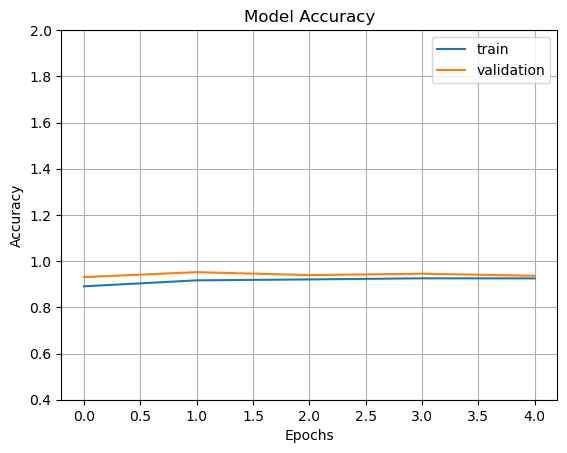

In [30]:
fig = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=2)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

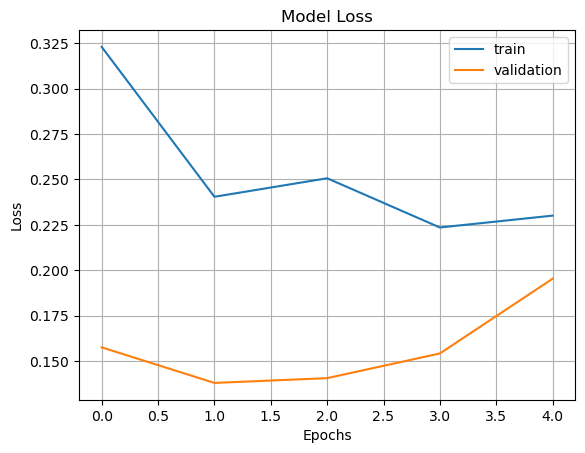

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [36]:
import cv2
def predict_image(model, image_path, class_names):
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (img_height, img_width))
    image = np.expand_dims(image_resized, axis=0)

    pred = efficientnet_model.predict(image)
    print(pred)
    confidence_threshold = 0.5
    if np.max(pred) < confidence_threshold:
        return "unknown"
    
    output_class = class_names[np.argmax(pred)]
    return output_class

image_path = '/Users/admin/Downloads/German-Shepherd-dog-Alsatian.jpg.webp'
predicted_class = predict_image(efficientnet_model, image_path, class_names)

print("The fruit is ", predicted_class)

1/1 [==============================] - 1s 893ms/step
[[0.01307918 0.03785988 0.9490609 ]]
The fruit is  Unripe
